# <center>Model of Power output from wind turbine</center>


***

In [9]:
#Load libraries required for this notebook
# Neural networks.
import tensorflow.keras as kr

# Numerical arrays
import numpy as np

# Data frames.
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

In [10]:
# Plot style.
plt.style.use("ggplot")

# Plot size.
plt.rcParams['figure.figsize'] = [14, 8]

## 1. Read in and familiarise ourselves with the dataset

In [11]:
# Read in the powerproduction dataset from the Data folder in the repository. Although it is a text file, we can read it in as a csv file, such is the format of the data contained within.
data = pd.read_csv('Data/powerproduction.txt')

In [12]:
# Complete a statistical summary of the dataset
data.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


From this we can see there are 500 data points of speed and corresponding power. The average speed is 12.59 and average power output is 48. Units are not given in the dataset, but based on some research, we will assume the units of speed are m/s (Metres per second) and the power output in MW (MegaWatts)
[https://en.wikipedia.org/wiki/Wind_turbine_design#Design_specification](https://en.wikipedia.org/wiki/Wind_turbine_design#Design_specification)

In [13]:
# View the head of the dataset
data.head(20)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [14]:
# View the head of the dataset
data.tail(20)

,speed,power
480,23.974,94.270
481,24.024,105.992
482,24.049,93.524
483,24.174,95.869
484,24.199,101.419
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223
489,24.399,95.117


At the outset, viewing the head and the tail of the dataset is always a good idea to give us a flavour of the data contained within and to give confidence that the dataset has no obvious flaws or quirks

In [17]:
df = pd.DataFrame(data)
df

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


<function matplotlib.pyplot.show(close=None, block=None)>

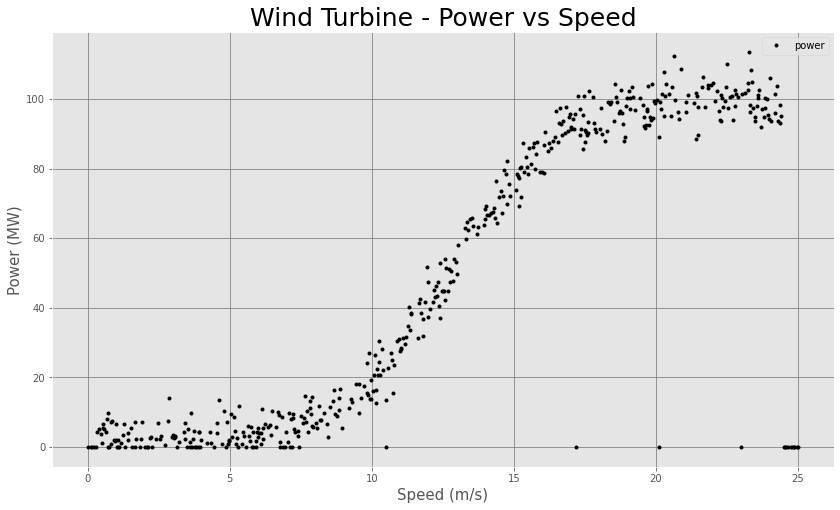

In [18]:
# Plot the values.
df.plot(x="speed", y="power", style='k.')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.show

From a quick observation of the data, we can see that the relationship between Power and Speed is in the shape of a sigmoid, where somewhere between about 7m/s and 17m/s wind speed is where the Power generated varies from <20MW to approximately 100MW. Outside the window of 7m/s to 17m/s there is relatively litte change with increasing or decreasiing wind speed.<br>
It is worth noting that there are a number of outliers showing where zero power is generated despite considerable wind speed being recorded. Because the Power in each of these outliers is exactly 0MW,it is assumed that there is some operational issue with the turbine and it is not working as per normal at these data points. This may be something worth notifying the turbine operator about. However, When modelling it would be worth pre-processing this data to ignore such obvious outliers, as these will skew any model trying to obtain normal operation modelling.

## 2. Pre process the data

From our above observation, we see there are outliers. For each of these outliers, the Power output is zero eventhough the wind speed is considerable. This is particularly noticeable at wind speeds ~>7.5m/s. It is important to deal with outliers prior to modelling or machine learning, as outliers certainly lead to more innacurate results.<br>
The outliers in this dataset are easy to identify from the above plot, hence we will deal wwith them in simple terms. However, with datasets of more than 2 variables, it is most often not as easy to identfy outliers from plotting. In these cases, using mathematical functions such as z-score or IQR score are required.[https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba).<br>
For the purpose of this assignment, we will assume a zero Power output corresponds to the turbine being turned off, so we will ignore these data points

In [19]:
# delete any rows from the dataset where a zero Power output is recorded
df = df[df.power != 0]
print('Number of rows remaining in dataset: %.d' % len(df))

Number of rows remaining in dataset: 451


<function matplotlib.pyplot.show(close=None, block=None)>

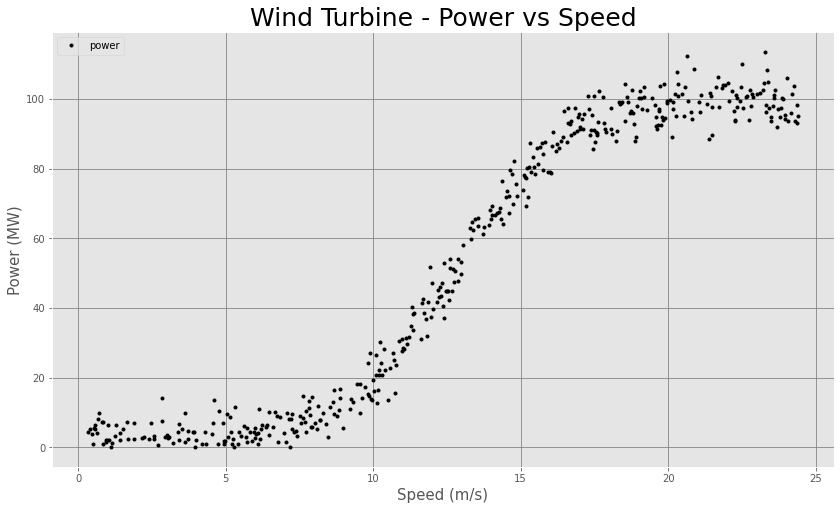

In [20]:
# Plot the values of the dataset with the outliers removed.
df.plot(x="speed", y="power", style='k.')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.show

## 3. Playing with polyfit function as a regression tool

By experimentation with the below polyfit function, a polynomial of degree 5 was found to best fit the data. Below has the calculated doefficients and corresonding fitted line to the data.

In [21]:
# Select the columns of the DataFrame
Speed = df['speed']
Power = df["power"]

In [22]:
# Convert to arrays
x = Speed.to_numpy()
y = Power.to_numpy()

Now, we will use polyfit function in numpy to fit a a line to a set of stat using the least squares [https://en.wikipedia.org/wiki/Least_squares](https://en.wikipedia.org/wiki/Least_squares)

In [23]:
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html 
a, b, c, d, e, f = np.polyfit(x, y, 5) 
a, b, c, d, e, f

(0.00039630172192963434,
 -0.02523629166747932,
 0.5364697791523846,
 -4.104980455352897,
 11.155542997851406,
 -2.82537457777539)

<function matplotlib.pyplot.show(close=None, block=None)>

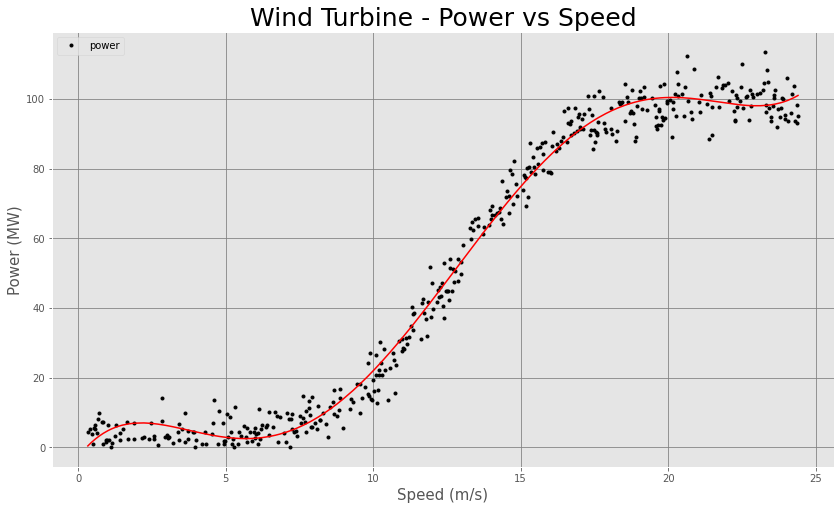

In [24]:
# Plot the values.
df.plot(x="speed", y="power", style='k.')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
# Add the plot of the 5th degree polymomial along with the calculated coefficients from polyfit
plt.plot(x, a * x *x*x*x*x + b *x*x*x*x +c *x*x*x +d*x*x +e*x +f, 'r-')
plt.show

Visually, the line seems to track the data set quite well.<br>

## 4. Using Scikit-Learn to train a model and test a dataset

We will now use scikit-learn to model and obtain the same results as above. The only difference bewteen below and above is that we have obtained the same results by use of scikit learn modelling rather than our own manual playing with the numpy polyfit function.

In [25]:
# Import required scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

In [26]:
# Prepare the dataset for training and testing
data = df.values
# split into inpiut and output elements
X, y = data[:, :-1], data[:, -1]
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [27]:
# fit the model using a 5th degree polynomial
# https://towardsdatascience.com/machine-learning-basics-polynomial-regression-3f9dd30223d1
poly_reg = PolynomialFeatures(degree = 5) 
X_poly = poly_reg.fit_transform(X_train)
model = LinearRegression()
model.fit(X_poly, y_train)

LinearRegression()

In [28]:
# Calculate the predicted y values from passing the given X_train values through the model
y_pred = model.predict(X_poly)

<function matplotlib.pyplot.show(close=None, block=None)>

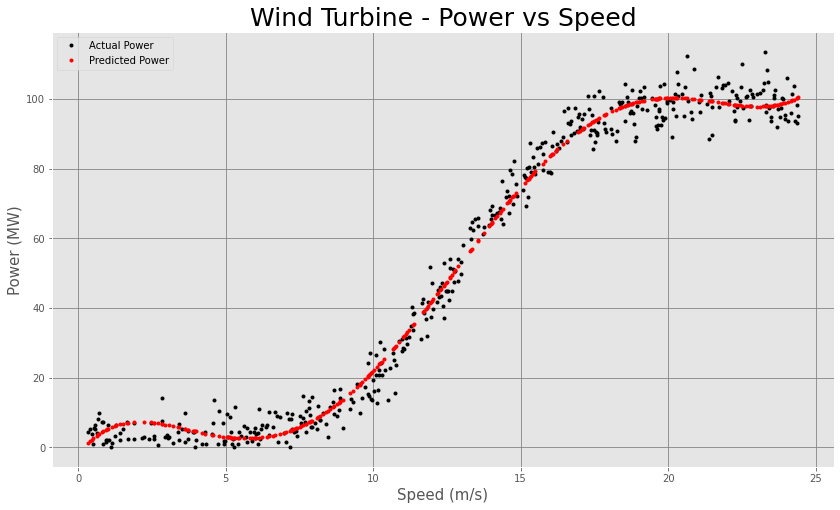

In [29]:
# Plot the results.
df.plot(x="speed", y="power", style='k.', label="Actual Power")
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.plot(X_train, y_pred, 'r.',label='Predicted Power')
plt.legend()
plt.show

In [29]:
# evaluate the model
poly_reg = PolynomialFeatures(degree = 5)
X_test_poly = poly_reg.fit_transform(X_test)

yhat = model.predict(X_test_poly)

In [30]:
#Calculate the accuracy of the y predicted results with the y actual results for the test dataset
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3fMW' % mae)

MAE: 3.487MW


In [31]:
from sklearn.metrics import max_error
max_error = max_error(y_test, yhat)
print('Max error: %.3fMW' % max_error)

Max error: 12.870MW


Using the regression model above, we get a mean absolute error between the actual power output of the turbine and the predicted output power of 3.487MW, and a maximum eroor across the test dataset of 12.87MW

## 5. Machine Learning - Neural Networks

We will now construct a neural network that will use meachhine learning to train a model to fit to the dataset. Our dataset consists of 1 input (wind speed) and 1 output (Power). Therefore, our Neural network required for this is relatively simple, with no need for deep neural networks. <br>
Below, by varing certain characteristics, we will build 5 neural networks, apply the training data set to each network (running 5000 epochs), compare the predicted output Power values with the actual Power obtained for both the training dataset and the test dataset. The 5 conditions of network we will examine are outlined below: <br>

1. Hidden layer with 1 neuron, and default batch size of 1
2. Hidden layer with 1 neuron and batch size of 10
3. Hidden layer with 2 neurons and batch size of 10
4. Hidden layer with 3 neurons and batch siize of 10
5. Hidden layer with 5 neurons and batch size of 10<br><br>

We will compute the loss obtained on each experiment and compare results

### 5.1 - Test model consisting of: 1 neuron, 5000 epochs, batch size=1

![1-neuron](Images/1-neuron.JPG)<br><p style='text-align: right;'>(http://alexlenail.me/NN-SVG/index.html, 2020)</p>

In [63]:
# Build a model using Keras
model = kr.models.Sequential()

# Add a layer with 50 neurons, 1 input (wind speed), using the sigmoid activation function to applied to each neuron, 
# initialise weights and bias with Glorot_uniform Draws samples from a uniform distribution within [-limit, limit], where 
# limit = sqrt(6 / (fan_in + fan_out)) (fan_in is the number of input units in the weight tensor and fan_out is the number 
# of output units).https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform
model.add(kr.layers.Dense(1, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

# Add a layer for the output neuron (Power), using 1 neuron, a linear activation function and, again, glorot_uniform 
# initialisers. Not, we use a linear activation function in this last layer, as we know power outputs are >1, which is the 
# approx the maximum we would obtain if we used a sigmoid activation function.
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

# Compile the model using the above defined neural network, calculating the loss after each epoch using "mean_squared_error"
# method, and applying the Optimizer that implements the Adam algorithm used to affect small changes to weights and bises
# based on the loss calculated after each eopch.https://keras.io/api/optimizers/adam/
model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')

In [64]:
# Fit the training dataset to the above model and run 5000 epochs in batches of 10 at a time.
model.fit(X_train, y_train, epochs=5000, batch_size=1)

Epoch 1/5000
302/302 [==============================] - 0s 675us/step - loss: 4586.3818
Epoch 2/5000
302/302 [==============================] - 0s 731us/step - loss: 3801.9658
Epoch 3/5000
302/302 [==============================] - 0s 702us/step - loss: 4400.7908
Epoch 4/5000
302/302 [==============================] - 0s 738us/step - loss: 4353.5063
Epoch 5/5000
302/302 [==============================] - 0s 754us/step - loss: 3903.1551
Epoch 6/5000
302/302 [==============================] - 0s 789us/step - loss: 4133.7809
Epoch 7/5000
302/302 [==============================] - 0s 733us/step - loss: 3765.4324
Epoch 8/5000
302/302 [==============================] - 0s 766us/step - loss: 3865.3894
Epoch 9/5000
302/302 [==============================] - 0s 769us/step - loss: 3776.6414
Epoch 10/5000
302/302 [==============================] - 0s 788us/step - loss: 3538.7622
Epoch 11/5000
302/302 [==============================] - 0s 824us/step - loss: 3984.9360
Epoch 12/5000
302/302 [=======

Epoch 183/5000
302/302 [==============================] - 0s 913us/step - loss: 1657.1416
Epoch 184/5000
302/302 [==============================] - 0s 704us/step - loss: 1614.9594
Epoch 185/5000
302/302 [==============================] - 0s 686us/step - loss: 1592.9235
Epoch 186/5000
302/302 [==============================] - 0s 676us/step - loss: 1595.1104
Epoch 187/5000
302/302 [==============================] - 0s 841us/step - loss: 1458.4533
Epoch 188/5000
302/302 [==============================] - 0s 814us/step - loss: 1567.1353
Epoch 189/5000
302/302 [==============================] - 0s 669us/step - loss: 1518.6424
Epoch 190/5000
302/302 [==============================] - 0s 676us/step - loss: 1520.64630s - loss: 1537.
Epoch 191/5000
302/302 [==============================] - 0s 667us/step - loss: 1442.6806
Epoch 192/5000
302/302 [==============================] - 0s 698us/step - loss: 1513.2983
Epoch 193/5000
302/302 [==============================] - 0s 706us/step - loss: 1417

302/302 [==============================] - 0s 737us/step - loss: 374.8420
Epoch 364/5000
302/302 [==============================] - 0s 781us/step - loss: 379.0621
Epoch 365/5000
302/302 [==============================] - 0s 775us/step - loss: 411.7337
Epoch 366/5000
302/302 [==============================] - 0s 725us/step - loss: 409.9109
Epoch 367/5000
302/302 [==============================] - 0s 713us/step - loss: 373.2333
Epoch 368/5000
302/302 [==============================] - 0s 709us/step - loss: 384.1106
Epoch 369/5000
302/302 [==============================] - 0s 704us/step - loss: 385.4002
Epoch 370/5000
302/302 [==============================] - 0s 783us/step - loss: 388.8312
Epoch 371/5000
302/302 [==============================] - 0s 711us/step - loss: 354.5438
Epoch 372/5000
302/302 [==============================] - 0s 712us/step - loss: 338.4296
Epoch 373/5000
302/302 [==============================] - 0s 789us/step - loss: 412.7808
Epoch 374/5000
302/302 [============

302/302 [==============================] - 0s 660us/step - loss: 76.6628
Epoch 545/5000
302/302 [==============================] - 0s 651us/step - loss: 73.6691
Epoch 546/5000
302/302 [==============================] - 0s 654us/step - loss: 85.2680
Epoch 547/5000
302/302 [==============================] - 0s 786us/step - loss: 75.4350
Epoch 548/5000
302/302 [==============================] - 0s 937us/step - loss: 83.6220
Epoch 549/5000
302/302 [==============================] - 0s 746us/step - loss: 74.9896
Epoch 550/5000
302/302 [==============================] - 0s 643us/step - loss: 74.3431
Epoch 551/5000
302/302 [==============================] - 0s 662us/step - loss: 76.9878
Epoch 552/5000
302/302 [==============================] - 0s 642us/step - loss: 66.6860
Epoch 553/5000
302/302 [==============================] - 0s 648us/step - loss: 63.6197
Epoch 554/5000
302/302 [==============================] - 0s 651us/step - loss: 69.3193
Epoch 555/5000
302/302 [=======================

302/302 [==============================] - 0s 931us/step - loss: 34.2133
Epoch 729/5000
302/302 [==============================] - 0s 962us/step - loss: 34.8590
Epoch 730/5000
302/302 [==============================] - 0s 1ms/step - loss: 30.5099
Epoch 731/5000
302/302 [==============================] - 0s 949us/step - loss: 31.1191
Epoch 732/5000
302/302 [==============================] - 0s 862us/step - loss: 30.3042
Epoch 733/5000
302/302 [==============================] - 0s 927us/step - loss: 40.4825
Epoch 734/5000
302/302 [==============================] - 0s 946us/step - loss: 29.3155
Epoch 735/5000
302/302 [==============================] - 0s 1ms/step - loss: 33.4019
Epoch 736/5000
302/302 [==============================] - 0s 893us/step - loss: 33.2636
Epoch 737/5000
302/302 [==============================] - 0s 912us/step - loss: 26.2246
Epoch 738/5000
302/302 [==============================] - 0s 927us/step - loss: 33.4870
Epoch 739/5000
302/302 [===========================

302/302 [==============================] - 0s 666us/step - loss: 20.5308
Epoch 914/5000
302/302 [==============================] - 0s 712us/step - loss: 24.0128
Epoch 915/5000
302/302 [==============================] - 0s 696us/step - loss: 21.7880
Epoch 916/5000
302/302 [==============================] - 0s 667us/step - loss: 20.4224
Epoch 917/5000
302/302 [==============================] - 0s 756us/step - loss: 22.1094
Epoch 918/5000
302/302 [==============================] - 0s 725us/step - loss: 20.7966
Epoch 919/5000
302/302 [==============================] - 0s 848us/step - loss: 21.4392
Epoch 920/5000
302/302 [==============================] - 0s 917us/step - loss: 26.8284
Epoch 921/5000
302/302 [==============================] - 0s 1ms/step - loss: 20.0938
Epoch 922/5000
302/302 [==============================] - 0s 758us/step - loss: 19.3350
Epoch 923/5000
302/302 [==============================] - 0s 1ms/step - loss: 19.8802
Epoch 924/5000
302/302 [===========================

302/302 [==============================] - 0s 725us/step - loss: 19.1089
Epoch 1099/5000
302/302 [==============================] - 0s 711us/step - loss: 16.2981
Epoch 1100/5000
302/302 [==============================] - 0s 708us/step - loss: 18.9958
Epoch 1101/5000
302/302 [==============================] - 0s 730us/step - loss: 19.0456
Epoch 1102/5000
302/302 [==============================] - 0s 724us/step - loss: 18.8282
Epoch 1103/5000
302/302 [==============================] - 0s 704us/step - loss: 19.0634
Epoch 1104/5000
302/302 [==============================] - 0s 691us/step - loss: 19.7744
Epoch 1105/5000
302/302 [==============================] - 0s 694us/step - loss: 19.19490s - loss:
Epoch 1106/5000
302/302 [==============================] - 0s 706us/step - loss: 16.4786
Epoch 1107/5000
302/302 [==============================] - 0s 709us/step - loss: 19.3185
Epoch 1108/5000
302/302 [==============================] - 0s 742us/step - loss: 17.6209
Epoch 1109/5000
302/302 [==

302/302 [==============================] - 0s 668us/step - loss: 15.6553
Epoch 1191/5000
302/302 [==============================] - 0s 649us/step - loss: 17.3442
Epoch 1192/5000
302/302 [==============================] - 0s 651us/step - loss: 17.1802
Epoch 1193/5000
302/302 [==============================] - 0s 668us/step - loss: 18.1235
Epoch 1194/5000
302/302 [==============================] - 0s 662us/step - loss: 18.3753
Epoch 1195/5000
302/302 [==============================] - 0s 653us/step - loss: 19.8923
Epoch 1196/5000
302/302 [==============================] - 0s 661us/step - loss: 20.0330
Epoch 1197/5000
302/302 [==============================] - 0s 654us/step - loss: 20.3203
Epoch 1198/5000
302/302 [==============================] - 0s 653us/step - loss: 18.5292
Epoch 1199/5000
302/302 [==============================] - 0s 675us/step - loss: 18.4040
Epoch 1200/5000
302/302 [==============================] - ETA: 0s - loss: 17.99 - 0s 665us/step - loss: 18.2243
Epoch 1201/50

302/302 [==============================] - 0s 1ms/step - loss: 17.2750
Epoch 1372/5000
302/302 [==============================] - 0s 795us/step - loss: 17.8902
Epoch 1373/5000
302/302 [==============================] - 0s 654us/step - loss: 18.4317
Epoch 1374/5000
302/302 [==============================] - 0s 661us/step - loss: 18.8885
Epoch 1375/5000
302/302 [==============================] - 0s 912us/step - loss: 18.7087
Epoch 1376/5000
302/302 [==============================] - 0s 999us/step - loss: 17.2624
Epoch 1377/5000
302/302 [==============================] - 0s 736us/step - loss: 17.0655
Epoch 1378/5000
302/302 [==============================] - 0s 653us/step - loss: 15.7905
Epoch 1379/5000
302/302 [==============================] - 0s 1ms/step - loss: 16.8545
Epoch 1380/5000
302/302 [==============================] - 0s 834us/step - loss: 17.7198
Epoch 1381/5000
302/302 [==============================] - 0s 659us/step - loss: 23.32640s - loss: 24.66
Epoch 1382/5000
302/302 [

302/302 [==============================] - 0s 656us/step - loss: 20.5205
Epoch 1553/5000
302/302 [==============================] - 0s 652us/step - loss: 16.8169
Epoch 1554/5000
302/302 [==============================] - 0s 646us/step - loss: 18.7243
Epoch 1555/5000
302/302 [==============================] - 0s 675us/step - loss: 17.70990s - loss: 17.70
Epoch 1556/5000
302/302 [==============================] - 0s 645us/step - loss: 17.8354
Epoch 1557/5000
302/302 [==============================] - 0s 646us/step - loss: 18.6284
Epoch 1558/5000
302/302 [==============================] - 0s 671us/step - loss: 19.4962
Epoch 1559/5000
302/302 [==============================] - 0s 646us/step - loss: 19.2352
Epoch 1560/5000
302/302 [==============================] - 0s 730us/step - loss: 15.9936
Epoch 1561/5000
302/302 [==============================] - 0s 643us/step - loss: 19.0652
Epoch 1562/5000
302/302 [==============================] - 0s 647us/step - loss: 18.3744
Epoch 1563/5000
302/3

302/302 [==============================] - 0s 795us/step - loss: 19.7983
Epoch 1644/5000
302/302 [==============================] - 0s 823us/step - loss: 19.0986
Epoch 1645/5000
302/302 [==============================] - 0s 701us/step - loss: 15.8315
Epoch 1646/5000
302/302 [==============================] - 0s 663us/step - loss: 17.8850
Epoch 1647/5000
302/302 [==============================] - 0s 750us/step - loss: 17.3130
Epoch 1648/5000
302/302 [==============================] - 0s 687us/step - loss: 19.0833
Epoch 1649/5000
302/302 [==============================] - 0s 661us/step - loss: 16.1155
Epoch 1650/5000
302/302 [==============================] - 0s 678us/step - loss: 19.0372
Epoch 1651/5000
302/302 [==============================] - 0s 690us/step - loss: 19.3862
Epoch 1652/5000
302/302 [==============================] - 0s 842us/step - loss: 18.4404
Epoch 1653/5000
302/302 [==============================] - 0s 655us/step - loss: 20.80080s - loss: 23.
Epoch 1654/5000
302/302

Epoch 1734/5000
302/302 [==============================] - 0s 648us/step - loss: 16.7254
Epoch 1735/5000
302/302 [==============================] - 0s 644us/step - loss: 18.9984
Epoch 1736/5000
302/302 [==============================] - 0s 659us/step - loss: 18.4370
Epoch 1737/5000
302/302 [==============================] - 0s 646us/step - loss: 19.4106
Epoch 1738/5000
302/302 [==============================] - 0s 643us/step - loss: 20.0440
Epoch 1739/5000
302/302 [==============================] - 0s 649us/step - loss: 16.2693
Epoch 1740/5000
302/302 [==============================] - 0s 674us/step - loss: 17.9306
Epoch 1741/5000
302/302 [==============================] - 0s 667us/step - loss: 16.8866
Epoch 1742/5000
302/302 [==============================] - 0s 729us/step - loss: 19.9901
Epoch 1743/5000
302/302 [==============================] - 0s 642us/step - loss: 18.0370
Epoch 1744/5000
302/302 [==============================] - 0s 638us/step - loss: 18.1984
Epoch 1745/5000
302/3

302/302 [==============================] - 0s 916us/step - loss: 19.7184
Epoch 1916/5000
302/302 [==============================] - 0s 643us/step - loss: 18.0724
Epoch 1917/5000
302/302 [==============================] - 0s 832us/step - loss: 16.9539
Epoch 1918/5000
302/302 [==============================] - 0s 792us/step - loss: 17.5012
Epoch 1919/5000
302/302 [==============================] - 0s 812us/step - loss: 15.6431
Epoch 1920/5000
302/302 [==============================] - 0s 758us/step - loss: 20.6477
Epoch 1921/5000
302/302 [==============================] - 0s 876us/step - loss: 17.6804
Epoch 1922/5000
302/302 [==============================] - 0s 657us/step - loss: 17.0980
Epoch 1923/5000
302/302 [==============================] - 0s 814us/step - loss: 16.4649
Epoch 1924/5000
302/302 [==============================] - 0s 749us/step - loss: 17.4883
Epoch 1925/5000
302/302 [==============================] - 0s 817us/step - loss: 18.0752
Epoch 1926/5000
302/302 [============

302/302 [==============================] - 0s 713us/step - loss: 16.5621
Epoch 2096/5000
302/302 [==============================] - 0s 699us/step - loss: 16.7020
Epoch 2097/5000
302/302 [==============================] - 0s 695us/step - loss: 17.3949
Epoch 2098/5000
302/302 [==============================] - 0s 723us/step - loss: 16.9154
Epoch 2099/5000
302/302 [==============================] - 0s 702us/step - loss: 19.0084
Epoch 2100/5000
302/302 [==============================] - 0s 706us/step - loss: 20.4832
Epoch 2101/5000
302/302 [==============================] - 0s 708us/step - loss: 17.0982
Epoch 2102/5000
302/302 [==============================] - 0s 678us/step - loss: 19.4788
Epoch 2103/5000
302/302 [==============================] - 0s 748us/step - loss: 17.0035
Epoch 2104/5000
302/302 [==============================] - 0s 752us/step - loss: 21.0169
Epoch 2105/5000
302/302 [==============================] - 0s 783us/step - loss: 18.7563
Epoch 2106/5000
302/302 [============

Epoch 2187/5000
302/302 [==============================] - 0s 705us/step - loss: 21.4741
Epoch 2188/5000
302/302 [==============================] - 0s 695us/step - loss: 14.7744
Epoch 2189/5000
302/302 [==============================] - 0s 698us/step - loss: 16.4842
Epoch 2190/5000
302/302 [==============================] - 0s 689us/step - loss: 15.7111
Epoch 2191/5000
302/302 [==============================] - 0s 719us/step - loss: 16.0397
Epoch 2192/5000
302/302 [==============================] - 0s 689us/step - loss: 20.0111
Epoch 2193/5000
302/302 [==============================] - 0s 694us/step - loss: 19.3148
Epoch 2194/5000
302/302 [==============================] - 0s 695us/step - loss: 20.6622
Epoch 2195/5000
302/302 [==============================] - 0s 702us/step - loss: 16.6080
Epoch 2196/5000
302/302 [==============================] - 0s 699us/step - loss: 18.36720s - loss: 18.
Epoch 2197/5000
302/302 [==============================] - 0s 682us/step - loss: 16.0656
Epoch 2

302/302 [==============================] - 0s 693us/step - loss: 18.4967
Epoch 2370/5000
302/302 [==============================] - 0s 694us/step - loss: 19.0094
Epoch 2371/5000
302/302 [==============================] - 0s 682us/step - loss: 17.6877
Epoch 2372/5000
302/302 [==============================] - 0s 692us/step - loss: 17.0984
Epoch 2373/5000
302/302 [==============================] - 0s 672us/step - loss: 17.6443
Epoch 2374/5000
302/302 [==============================] - 0s 693us/step - loss: 18.1142
Epoch 2375/5000
302/302 [==============================] - 0s 683us/step - loss: 21.1145
Epoch 2376/5000
302/302 [==============================] - 0s 700us/step - loss: 16.9848
Epoch 2377/5000
302/302 [==============================] - 0s 685us/step - loss: 16.46090s - loss: 1
Epoch 2378/5000
302/302 [==============================] - 0s 680us/step - loss: 16.7822
Epoch 2379/5000
302/302 [==============================] - 0s 685us/step - loss: 19.3322
Epoch 2380/5000
302/302 [

302/302 [==============================] - 0s 695us/step - loss: 19.0757
Epoch 2552/5000
302/302 [==============================] - 0s 687us/step - loss: 19.0173
Epoch 2553/5000
302/302 [==============================] - 0s 688us/step - loss: 16.1721
Epoch 2554/5000
302/302 [==============================] - 0s 692us/step - loss: 17.0350
Epoch 2555/5000
302/302 [==============================] - 0s 670us/step - loss: 17.5708
Epoch 2556/5000
302/302 [==============================] - 0s 674us/step - loss: 14.5109
Epoch 2557/5000
302/302 [==============================] - 0s 694us/step - loss: 21.7927
Epoch 2558/5000
302/302 [==============================] - 0s 690us/step - loss: 18.7604
Epoch 2559/5000
302/302 [==============================] - 0s 692us/step - loss: 18.8070
Epoch 2560/5000
302/302 [==============================] - 0s 690us/step - loss: 18.8010
Epoch 2561/5000
302/302 [==============================] - 0s 679us/step - loss: 17.6029
Epoch 2562/5000
302/302 [============

302/302 [==============================] - 0s 702us/step - loss: 17.2278
Epoch 2733/5000
302/302 [==============================] - 0s 681us/step - loss: 17.1998
Epoch 2734/5000
302/302 [==============================] - 0s 670us/step - loss: 19.2074
Epoch 2735/5000
302/302 [==============================] - 0s 673us/step - loss: 20.0219
Epoch 2736/5000
302/302 [==============================] - 0s 683us/step - loss: 20.1709
Epoch 2737/5000
302/302 [==============================] - 0s 695us/step - loss: 17.40270s - loss: 17.37
Epoch 2738/5000
302/302 [==============================] - 0s 677us/step - loss: 18.9381
Epoch 2739/5000
302/302 [==============================] - 0s 674us/step - loss: 16.5500
Epoch 2740/5000
302/302 [==============================] - 0s 699us/step - loss: 17.7727
Epoch 2741/5000
302/302 [==============================] - 0s 699us/step - loss: 18.0799
Epoch 2742/5000
302/302 [==============================] - 0s 684us/step - loss: 14.4459
Epoch 2743/5000
302/3

302/302 [==============================] - 0s 681us/step - loss: 17.4249
Epoch 2915/5000
302/302 [==============================] - 0s 673us/step - loss: 18.5611
Epoch 2916/5000
302/302 [==============================] - 0s 691us/step - loss: 19.5037
Epoch 2917/5000
302/302 [==============================] - 0s 688us/step - loss: 19.4254
Epoch 2918/5000
302/302 [==============================] - 0s 695us/step - loss: 16.8157
Epoch 2919/5000
302/302 [==============================] - 0s 689us/step - loss: 17.4943
Epoch 2920/5000
302/302 [==============================] - 0s 673us/step - loss: 18.37470s - loss: 18.37
Epoch 2921/5000
302/302 [==============================] - 0s 693us/step - loss: 19.3995
Epoch 2922/5000
302/302 [==============================] - 0s 684us/step - loss: 17.4173
Epoch 2923/5000
302/302 [==============================] - 0s 687us/step - loss: 15.8192
Epoch 2924/5000
302/302 [==============================] - 0s 679us/step - loss: 17.4763
Epoch 2925/5000
302/3

302/302 [==============================] - 0s 798us/step - loss: 18.7006
Epoch 3097/5000
302/302 [==============================] - 0s 701us/step - loss: 17.8105
Epoch 3098/5000
302/302 [==============================] - 0s 690us/step - loss: 17.2141
Epoch 3099/5000
302/302 [==============================] - 0s 808us/step - loss: 17.1957
Epoch 3100/5000
302/302 [==============================] - 0s 799us/step - loss: 17.8202
Epoch 3101/5000
302/302 [==============================] - 0s 827us/step - loss: 21.5187
Epoch 3102/5000
302/302 [==============================] - 0s 670us/step - loss: 17.0244
Epoch 3103/5000
302/302 [==============================] - 0s 687us/step - loss: 19.2747
Epoch 3104/5000
302/302 [==============================] - 0s 679us/step - loss: 17.0849
Epoch 3105/5000
302/302 [==============================] - 0s 677us/step - loss: 16.6106
Epoch 3106/5000
302/302 [==============================] - 0s 762us/step - loss: 18.7927
Epoch 3107/5000
302/302 [============

302/302 [==============================] - 0s 687us/step - loss: 18.0045
Epoch 3279/5000
302/302 [==============================] - 0s 754us/step - loss: 20.2619
Epoch 3280/5000
302/302 [==============================] - 0s 882us/step - loss: 16.3602
Epoch 3281/5000
302/302 [==============================] - 0s 775us/step - loss: 18.0651
Epoch 3282/5000
302/302 [==============================] - 0s 687us/step - loss: 16.1900
Epoch 3283/5000
302/302 [==============================] - 0s 717us/step - loss: 17.8413
Epoch 3284/5000
302/302 [==============================] - 0s 886us/step - loss: 17.0894
Epoch 3285/5000
302/302 [==============================] - 0s 734us/step - loss: 20.2184
Epoch 3286/5000
302/302 [==============================] - 0s 821us/step - loss: 20.4687
Epoch 3287/5000
302/302 [==============================] - 0s 681us/step - loss: 19.8958
Epoch 3288/5000
302/302 [==============================] - 0s 735us/step - loss: 18.1813
Epoch 3289/5000
302/302 [============

302/302 [==============================] - 0s 704us/step - loss: 15.1626
Epoch 3371/5000
302/302 [==============================] - 0s 684us/step - loss: 18.7665
Epoch 3372/5000
302/302 [==============================] - 0s 721us/step - loss: 19.2853
Epoch 3373/5000
302/302 [==============================] - 0s 742us/step - loss: 18.3225
Epoch 3374/5000
302/302 [==============================] - 0s 697us/step - loss: 19.4823
Epoch 3375/5000
302/302 [==============================] - 0s 738us/step - loss: 16.9142
Epoch 3376/5000
302/302 [==============================] - 0s 722us/step - loss: 17.8817
Epoch 3377/5000
302/302 [==============================] - 0s 699us/step - loss: 17.2948
Epoch 3378/5000
302/302 [==============================] - 0s 675us/step - loss: 16.9145
Epoch 3379/5000
302/302 [==============================] - 0s 688us/step - loss: 17.13080s - loss: 17.09
Epoch 3380/5000
302/302 [==============================] - 0s 742us/step - loss: 17.2228
Epoch 3381/5000
302/3

302/302 [==============================] - 0s 696us/step - loss: 18.7091
Epoch 3553/5000
302/302 [==============================] - 0s 689us/step - loss: 21.4716
Epoch 3554/5000
302/302 [==============================] - 0s 675us/step - loss: 17.8108
Epoch 3555/5000
302/302 [==============================] - 0s 689us/step - loss: 18.9658
Epoch 3556/5000
302/302 [==============================] - 0s 674us/step - loss: 17.8489
Epoch 3557/5000
302/302 [==============================] - 0s 666us/step - loss: 17.1805
Epoch 3558/5000
302/302 [==============================] - 0s 713us/step - loss: 15.4832
Epoch 3559/5000
302/302 [==============================] - 0s 687us/step - loss: 18.9764
Epoch 3560/5000
302/302 [==============================] - 0s 687us/step - loss: 17.4149
Epoch 3561/5000
302/302 [==============================] - 0s 688us/step - loss: 18.1951
Epoch 3562/5000
302/302 [==============================] - 0s 686us/step - loss: 17.4628
Epoch 3563/5000
302/302 [============

302/302 [==============================] - 0s 685us/step - loss: 16.4753
Epoch 3645/5000
302/302 [==============================] - 0s 677us/step - loss: 16.0078
Epoch 3646/5000
302/302 [==============================] - 0s 675us/step - loss: 17.1911
Epoch 3647/5000
302/302 [==============================] - 0s 744us/step - loss: 16.1663
Epoch 3648/5000
302/302 [==============================] - 0s 898us/step - loss: 17.1935
Epoch 3649/5000
302/302 [==============================] - 0s 737us/step - loss: 16.3398
Epoch 3650/5000
302/302 [==============================] - 0s 681us/step - loss: 20.2118
Epoch 3651/5000
302/302 [==============================] - 0s 783us/step - loss: 19.2056
Epoch 3652/5000
302/302 [==============================] - 0s 828us/step - loss: 18.7694
Epoch 3653/5000
302/302 [==============================] - 0s 683us/step - loss: 18.2199
Epoch 3654/5000
302/302 [==============================] - 0s 685us/step - loss: 19.5079
Epoch 3655/5000
302/302 [============

302/302 [==============================] - 0s 686us/step - loss: 16.0594
Epoch 3826/5000
302/302 [==============================] - 0s 865us/step - loss: 17.6708
Epoch 3827/5000
302/302 [==============================] - 0s 878us/step - loss: 18.8213
Epoch 3828/5000
302/302 [==============================] - 0s 871us/step - loss: 17.8577
Epoch 3829/5000
302/302 [==============================] - 0s 679us/step - loss: 19.4558
Epoch 3830/5000
302/302 [==============================] - 0s 837us/step - loss: 19.9149
Epoch 3831/5000
302/302 [==============================] - 0s 799us/step - loss: 18.5690
Epoch 3832/5000
302/302 [==============================] - 0s 835us/step - loss: 17.0131
Epoch 3833/5000
302/302 [==============================] - 0s 723us/step - loss: 17.9606
Epoch 3834/5000
302/302 [==============================] - 0s 875us/step - loss: 17.0096
Epoch 3835/5000
302/302 [==============================] - 0s 735us/step - loss: 15.1902
Epoch 3836/5000
302/302 [============

302/302 [==============================] - 0s 721us/step - loss: 17.5987
Epoch 4008/5000
302/302 [==============================] - 0s 701us/step - loss: 16.9372
Epoch 4009/5000
302/302 [==============================] - 0s 696us/step - loss: 19.4546
Epoch 4010/5000
302/302 [==============================] - 0s 676us/step - loss: 19.3724
Epoch 4011/5000
302/302 [==============================] - 0s 703us/step - loss: 18.1042
Epoch 4012/5000
302/302 [==============================] - 0s 719us/step - loss: 19.7576
Epoch 4013/5000
302/302 [==============================] - 0s 714us/step - loss: 19.8770
Epoch 4014/5000
302/302 [==============================] - 0s 690us/step - loss: 18.0344
Epoch 4015/5000
302/302 [==============================] - 0s 715us/step - loss: 17.2298
Epoch 4016/5000
302/302 [==============================] - 0s 705us/step - loss: 17.1329
Epoch 4017/5000
302/302 [==============================] - 0s 692us/step - loss: 14.4305
Epoch 4018/5000
302/302 [============

302/302 [==============================] - 0s 702us/step - loss: 20.3801
Epoch 4190/5000
302/302 [==============================] - 0s 697us/step - loss: 18.4623
Epoch 4191/5000
302/302 [==============================] - 0s 712us/step - loss: 15.92170s - loss:
Epoch 4192/5000
302/302 [==============================] - 0s 681us/step - loss: 18.6710
Epoch 4193/5000
302/302 [==============================] - 0s 701us/step - loss: 18.17900s - loss:
Epoch 4194/5000
302/302 [==============================] - 0s 700us/step - loss: 20.2813
Epoch 4195/5000
302/302 [==============================] - 0s 709us/step - loss: 18.7344
Epoch 4196/5000
302/302 [==============================] - 0s 701us/step - loss: 19.8381
Epoch 4197/5000
302/302 [==============================] - 0s 704us/step - loss: 20.4219
Epoch 4198/5000
302/302 [==============================] - 0s 688us/step - loss: 17.3473
Epoch 4199/5000
302/302 [==============================] - 0s 689us/step - loss: 16.4896
Epoch 4200/5000
3

302/302 [==============================] - 0s 746us/step - loss: 14.0532
Epoch 4372/5000
302/302 [==============================] - 0s 705us/step - loss: 19.2460
Epoch 4373/5000
302/302 [==============================] - 0s 699us/step - loss: 18.6646
Epoch 4374/5000
302/302 [==============================] - 0s 680us/step - loss: 19.1346
Epoch 4375/5000
302/302 [==============================] - 0s 850us/step - loss: 19.9586
Epoch 4376/5000
302/302 [==============================] - 0s 744us/step - loss: 21.4827
Epoch 4377/5000
302/302 [==============================] - 0s 684us/step - loss: 18.0376
Epoch 4378/5000
302/302 [==============================] - 0s 679us/step - loss: 19.0350
Epoch 4379/5000
302/302 [==============================] - 0s 728us/step - loss: 16.8438
Epoch 4380/5000
302/302 [==============================] - 0s 704us/step - loss: 18.7188
Epoch 4381/5000
302/302 [==============================] - 0s 688us/step - loss: 18.4545
Epoch 4382/5000
302/302 [============

Epoch 4554/5000
302/302 [==============================] - 0s 692us/step - loss: 19.4786
Epoch 4555/5000
302/302 [==============================] - 0s 692us/step - loss: 19.8577
Epoch 4556/5000
302/302 [==============================] - 0s 684us/step - loss: 18.5824
Epoch 4557/5000
302/302 [==============================] - 0s 726us/step - loss: 17.5944
Epoch 4558/5000
302/302 [==============================] - 0s 682us/step - loss: 18.0784
Epoch 4559/5000
302/302 [==============================] - 0s 688us/step - loss: 16.4873
Epoch 4560/5000
302/302 [==============================] - 0s 687us/step - loss: 21.4483
Epoch 4561/5000
302/302 [==============================] - 0s 701us/step - loss: 17.2516
Epoch 4562/5000
302/302 [==============================] - 0s 691us/step - loss: 18.1640
Epoch 4563/5000
302/302 [==============================] - 0s 696us/step - loss: 18.3139
Epoch 4564/5000
302/302 [==============================] - 0s 698us/step - loss: 17.2746
Epoch 4565/5000
302/3

Epoch 4737/5000
302/302 [==============================] - 0s 705us/step - loss: 18.5315
Epoch 4738/5000
302/302 [==============================] - 0s 711us/step - loss: 18.17020s - loss: 17.
Epoch 4739/5000
302/302 [==============================] - 0s 700us/step - loss: 21.0594
Epoch 4740/5000
302/302 [==============================] - 0s 735us/step - loss: 19.8435
Epoch 4741/5000
302/302 [==============================] - 0s 702us/step - loss: 16.9193
Epoch 4742/5000
302/302 [==============================] - 0s 711us/step - loss: 16.4300
Epoch 4743/5000
302/302 [==============================] - 0s 711us/step - loss: 20.7445
Epoch 4744/5000
302/302 [==============================] - 0s 696us/step - loss: 19.2027
Epoch 4745/5000
302/302 [==============================] - 0s 696us/step - loss: 20.6451
Epoch 4746/5000
302/302 [==============================] - 0s 699us/step - loss: 16.3606
Epoch 4747/5000
302/302 [==============================] - 0s 685us/step - loss: 17.4898
Epoch 4

302/302 [==============================] - 0s 713us/step - loss: 17.4683
Epoch 4920/5000
302/302 [==============================] - 0s 712us/step - loss: 18.0996
Epoch 4921/5000
302/302 [==============================] - 0s 726us/step - loss: 17.8385
Epoch 4922/5000
302/302 [==============================] - 0s 679us/step - loss: 18.8912
Epoch 4923/5000
302/302 [==============================] - 0s 695us/step - loss: 17.6615
Epoch 4924/5000
302/302 [==============================] - 0s 750us/step - loss: 16.9419
Epoch 4925/5000
302/302 [==============================] - 0s 816us/step - loss: 16.4672
Epoch 4926/5000
302/302 [==============================] - 0s 797us/step - loss: 21.4091
Epoch 4927/5000
302/302 [==============================] - 0s 737us/step - loss: 19.1413
Epoch 4928/5000
302/302 [==============================] - 0s 692us/step - loss: 19.7407
Epoch 4929/5000
302/302 [==============================] - 0s 712us/step - loss: 16.9828
Epoch 4930/5000
302/302 [============

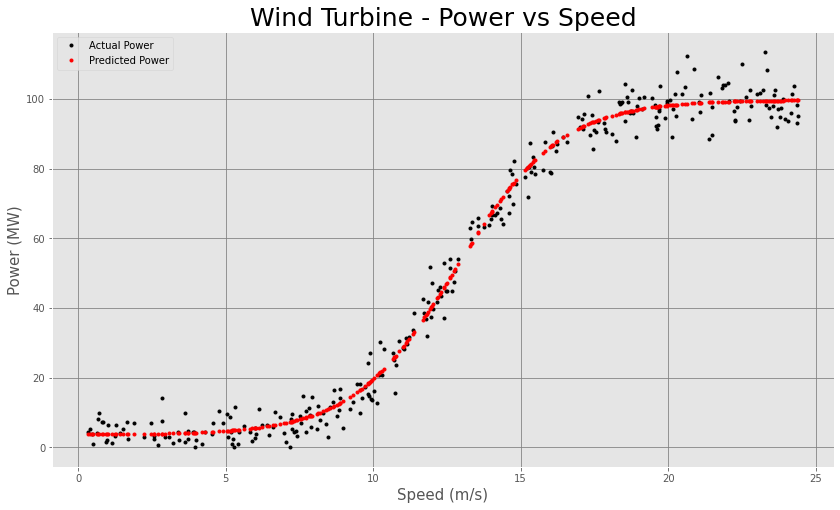

In [65]:
# Now let's see what the train dataset looks like for both the actual data and the predicted values from the model
plt.plot(X_train, y_train, 'k.', label='Actual Power')
plt.plot(X_train, model.predict(X_train), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

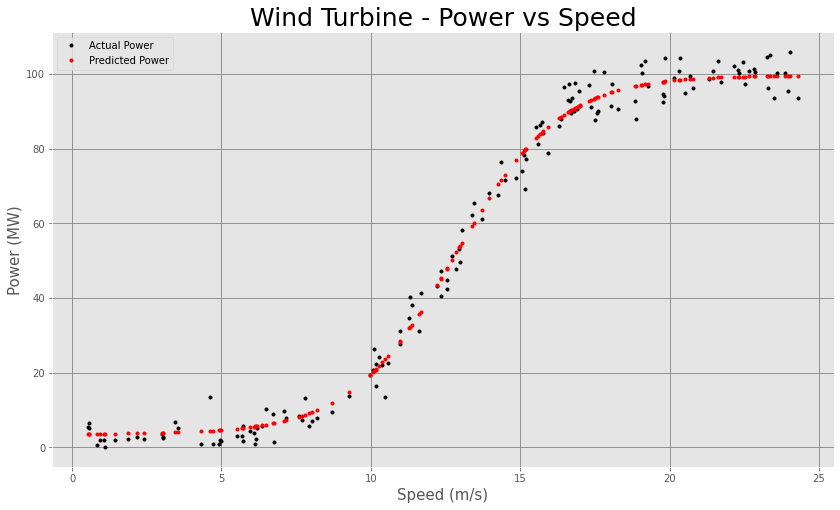

In [66]:
# The ultimate test is how the test dataset fits to its predicted reusults
# Now let's see how the test sample actual and predicted results compare, using the trained model
plt.plot(X_test, y_test, 'k.', label='Actual Power')
plt.plot(X_test, model.predict(X_test), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

In [67]:
# Evaluate the neural network on the test data.
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 998us/step - loss: 14.4219


14.421893119812012

### 5.2 - Test model consisting of: 1 neuron, 5000 epochs, batch size=10

In [68]:
# Build a model using Keras
model = kr.models.Sequential()

# Add a layer with 50 neurons, 1 input (wind speed), using the sigmoid activation function to applied to each neuron, 
# initialise weights and bias with Glorot_uniform Draws samples from a uniform distribution within [-limit, limit], where 
# limit = sqrt(6 / (fan_in + fan_out)) (fan_in is the number of input units in the weight tensor and fan_out is the number 
# of output units).https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform
model.add(kr.layers.Dense(1, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

# Add a layer for the output neuron (Power), using 1 neuron, a linear activation function and, again, glorot_uniform 
# initialisers. Not, we use a linear activation function in this last layer, as we know power outputs are >1, which is the 
# approx the maximum we would obtain if we used a sigmoid activation function.
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

# Compile the model using the above defined neural network, calculating the loss after each epoch using "mean_squared_error"
# method, and applying the Optimizer that implements the Adam algorithm used to affect small changes to weights and bises
# based on the loss calculated after each eopch.https://keras.io/api/optimizers/adam/
model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')

In [69]:
# Fit the training dataset to the above model and run 5000 epochs in batches of 10 at a time.
model.fit(X_train, y_train, epochs=5000, batch_size=10)

Epoch 1/5000
31/31 [==============================] - 0s 733us/step - loss: 3594.8288
Epoch 2/5000
31/31 [==============================] - 0s 997us/step - loss: 3831.4267
Epoch 3/5000
31/31 [==============================] - 0s 931us/step - loss: 4117.7762
Epoch 4/5000
31/31 [==============================] - 0s 997us/step - loss: 3894.7098
Epoch 5/5000
31/31 [==============================] - 0s 997us/step - loss: 3956.8333
Epoch 6/5000
31/31 [==============================] - 0s 999us/step - loss: 4033.3897
Epoch 7/5000
31/31 [==============================] - 0s 1ms/step - loss: 3995.9656
Epoch 8/5000
31/31 [==============================] - 0s 997us/step - loss: 3858.5719
Epoch 9/5000
31/31 [==============================] - 0s 964us/step - loss: 3989.4016
Epoch 10/5000
31/31 [==============================] - 0s 965us/step - loss: 3923.9118
Epoch 11/5000
31/31 [==============================] - 0s 931us/step - loss: 4110.4432
Epoch 12/5000
31/31 [==============================] -

31/31 [==============================] - 0s 1ms/step - loss: 3058.6329
Epoch 189/5000
31/31 [==============================] - 0s 997us/step - loss: 3061.7516
Epoch 190/5000
31/31 [==============================] - 0s 998us/step - loss: 2956.9343
Epoch 191/5000
31/31 [==============================] - 0s 798us/step - loss: 2999.8791
Epoch 192/5000
31/31 [==============================] - 0s 864us/step - loss: 3069.7907
Epoch 193/5000
31/31 [==============================] - 0s 931us/step - loss: 2879.1417
Epoch 194/5000
31/31 [==============================] - 0s 981us/step - loss: 3117.4426
Epoch 195/5000
31/31 [==============================] - 0s 864us/step - loss: 2966.1442
Epoch 196/5000
31/31 [==============================] - 0s 765us/step - loss: 3067.2155
Epoch 197/5000
31/31 [==============================] - 0s 928us/step - loss: 2874.1052
Epoch 198/5000
31/31 [==============================] - 0s 1ms/step - loss: 2998.2263
Epoch 199/5000
31/31 [=============================

31/31 [==============================] - 0s 831us/step - loss: 2277.2315
Epoch 375/5000
31/31 [==============================] - 0s 836us/step - loss: 2305.5454
Epoch 376/5000
31/31 [==============================] - 0s 932us/step - loss: 2124.5511
Epoch 377/5000
31/31 [==============================] - 0s 893us/step - loss: 2245.7148
Epoch 378/5000
31/31 [==============================] - 0s 1ms/step - loss: 2219.9143
Epoch 379/5000
31/31 [==============================] - 0s 858us/step - loss: 2317.2846
Epoch 380/5000
31/31 [==============================] - 0s 808us/step - loss: 2319.8838
Epoch 381/5000
31/31 [==============================] - 0s 869us/step - loss: 2105.1910
Epoch 382/5000
31/31 [==============================] - 0s 957us/step - loss: 2170.0479
Epoch 383/5000
31/31 [==============================] - 0s 858us/step - loss: 2331.9683
Epoch 384/5000
31/31 [==============================] - 0s 862us/step - loss: 2352.3772
Epoch 385/5000
31/31 [===========================

31/31 [==============================] - 0s 798us/step - loss: 1851.5262
Epoch 560/5000
31/31 [==============================] - 0s 916us/step - loss: 1752.8679
Epoch 561/5000
31/31 [==============================] - 0s 864us/step - loss: 1691.6968
Epoch 562/5000
31/31 [==============================] - 0s 798us/step - loss: 1550.0725
Epoch 563/5000
31/31 [==============================] - 0s 826us/step - loss: 1891.4417
Epoch 564/5000
31/31 [==============================] - 0s 863us/step - loss: 1579.2399
Epoch 565/5000
31/31 [==============================] - 0s 854us/step - loss: 1742.5462
Epoch 566/5000
31/31 [==============================] - 0s 868us/step - loss: 1661.0472
Epoch 567/5000
31/31 [==============================] - 0s 841us/step - loss: 1569.5116
Epoch 568/5000
31/31 [==============================] - 0s 861us/step - loss: 1732.0189
Epoch 569/5000
31/31 [==============================] - 0s 826us/step - loss: 1575.2401
Epoch 570/5000
31/31 [=========================

31/31 [==============================] - 0s 931us/step - loss: 1290.2747
Epoch 745/5000
31/31 [==============================] - 0s 865us/step - loss: 1262.3676
Epoch 746/5000
31/31 [==============================] - 0s 869us/step - loss: 1124.8099
Epoch 747/5000
31/31 [==============================] - 0s 1ms/step - loss: 1204.3756
Epoch 748/5000
31/31 [==============================] - 0s 1ms/step - loss: 1366.7492
Epoch 749/5000
31/31 [==============================] - 0s 1ms/step - loss: 1246.3456
Epoch 750/5000
31/31 [==============================] - 0s 1ms/step - loss: 1330.7716
Epoch 751/5000
31/31 [==============================] - 0s 1ms/step - loss: 1155.0161
Epoch 752/5000
31/31 [==============================] - 0s 1ms/step - loss: 1142.5402
Epoch 753/5000
31/31 [==============================] - ETA: 0s - loss: 1149.15 - 0s 1ms/step - loss: 1260.8235
Epoch 754/5000
31/31 [==============================] - 0s 979us/step - loss: 1179.8208
Epoch 755/5000
31/31 [=============

Epoch 837/5000
31/31 [==============================] - 0s 898us/step - loss: 1037.6559
Epoch 838/5000
31/31 [==============================] - 0s 829us/step - loss: 1074.2377
Epoch 839/5000
31/31 [==============================] - 0s 826us/step - loss: 1071.9111
Epoch 840/5000
31/31 [==============================] - 0s 907us/step - loss: 1004.3003
Epoch 841/5000
31/31 [==============================] - 0s 823us/step - loss: 1027.6619
Epoch 842/5000
31/31 [==============================] - 0s 830us/step - loss: 1100.8278
Epoch 843/5000
31/31 [==============================] - 0s 923us/step - loss: 1024.8874
Epoch 844/5000
31/31 [==============================] - 0s 918us/step - loss: 991.5388
Epoch 845/5000
31/31 [==============================] - 0s 896us/step - loss: 1037.0411
Epoch 846/5000
31/31 [==============================] - 0s 786us/step - loss: 1141.2806
Epoch 847/5000
31/31 [==============================] - 0s 917us/step - loss: 1031.2564
Epoch 848/5000
31/31 [===========

31/31 [==============================] - 0s 898us/step - loss: 745.4318
Epoch 1025/5000
31/31 [==============================] - 0s 830us/step - loss: 795.4450
Epoch 1026/5000
31/31 [==============================] - 0s 887us/step - loss: 774.2259
Epoch 1027/5000
31/31 [==============================] - 0s 932us/step - loss: 835.5465
Epoch 1028/5000
31/31 [==============================] - 0s 955us/step - loss: 805.6634
Epoch 1029/5000
31/31 [==============================] - 0s 897us/step - loss: 749.9018
Epoch 1030/5000
31/31 [==============================] - 0s 775us/step - loss: 811.9233
Epoch 1031/5000
31/31 [==============================] - 0s 888us/step - loss: 762.8586
Epoch 1032/5000
31/31 [==============================] - 0s 917us/step - loss: 775.7085
Epoch 1033/5000
31/31 [==============================] - 0s 860us/step - loss: 771.1976
Epoch 1034/5000
31/31 [==============================] - 0s 892us/step - loss: 783.2805
Epoch 1035/5000
31/31 [=========================

31/31 [==============================] - 0s 898us/step - loss: 597.7926
Epoch 1211/5000
31/31 [==============================] - 0s 923us/step - loss: 608.6267
Epoch 1212/5000
31/31 [==============================] - 0s 814us/step - loss: 592.7371
Epoch 1213/5000
31/31 [==============================] - 0s 915us/step - loss: 586.1979
Epoch 1214/5000
31/31 [==============================] - 0s 931us/step - loss: 583.4360
Epoch 1215/5000
31/31 [==============================] - 0s 831us/step - loss: 612.6748
Epoch 1216/5000
31/31 [==============================] - 0s 885us/step - loss: 592.0900
Epoch 1217/5000
31/31 [==============================] - 0s 911us/step - loss: 584.4700
Epoch 1218/5000
31/31 [==============================] - 0s 864us/step - loss: 600.0683
Epoch 1219/5000
31/31 [==============================] - 0s 850us/step - loss: 603.5084
Epoch 1220/5000
31/31 [==============================] - 0s 868us/step - loss: 614.0791
Epoch 1221/5000
31/31 [=========================

31/31 [==============================] - 0s 1ms/step - loss: 477.4323
Epoch 1397/5000
31/31 [==============================] - 0s 859us/step - loss: 472.6478
Epoch 1398/5000
31/31 [==============================] - 0s 864us/step - loss: 477.3164
Epoch 1399/5000
31/31 [==============================] - 0s 879us/step - loss: 487.4996
Epoch 1400/5000
31/31 [==============================] - 0s 853us/step - loss: 486.3019
Epoch 1401/5000
31/31 [==============================] - 0s 965us/step - loss: 506.2180
Epoch 1402/5000
31/31 [==============================] - 0s 916us/step - loss: 480.6580
Epoch 1403/5000
31/31 [==============================] - 0s 887us/step - loss: 489.0302
Epoch 1404/5000
31/31 [==============================] - 0s 851us/step - loss: 502.3171
Epoch 1405/5000
31/31 [==============================] - 0s 884us/step - loss: 459.4065
Epoch 1406/5000
31/31 [==============================] - 0s 930us/step - loss: 486.1624
Epoch 1407/5000
31/31 [===========================

31/31 [==============================] - 0s 876us/step - loss: 379.7655
Epoch 1583/5000
31/31 [==============================] - 0s 865us/step - loss: 386.7088
Epoch 1584/5000
31/31 [==============================] - 0s 946us/step - loss: 386.0121
Epoch 1585/5000
31/31 [==============================] - 0s 856us/step - loss: 415.5144
Epoch 1586/5000
31/31 [==============================] - 0s 883us/step - loss: 381.9253
Epoch 1587/5000
31/31 [==============================] - 0s 898us/step - loss: 381.8364
Epoch 1588/5000
31/31 [==============================] - 0s 964us/step - loss: 419.3220
Epoch 1589/5000
31/31 [==============================] - 0s 857us/step - loss: 390.8321
Epoch 1590/5000
31/31 [==============================] - 0s 923us/step - loss: 406.8839
Epoch 1591/5000
31/31 [==============================] - 0s 919us/step - loss: 406.2219
Epoch 1592/5000
31/31 [==============================] - 0s 863us/step - loss: 414.5473
Epoch 1593/5000
31/31 [=========================

31/31 [==============================] - 0s 1ms/step - loss: 314.7316
Epoch 1769/5000
31/31 [==============================] - 0s 945us/step - loss: 322.9307
Epoch 1770/5000
31/31 [==============================] - 0s 864us/step - loss: 305.5700
Epoch 1771/5000
31/31 [==============================] - 0s 898us/step - loss: 325.8640
Epoch 1772/5000
31/31 [==============================] - 0s 864us/step - loss: 313.5645
Epoch 1773/5000
31/31 [==============================] - 0s 855us/step - loss: 332.3207
Epoch 1774/5000
31/31 [==============================] - 0s 883us/step - loss: 348.4162
Epoch 1775/5000
31/31 [==============================] - 0s 886us/step - loss: 304.5275
Epoch 1776/5000
31/31 [==============================] - 0s 998us/step - loss: 328.3922
Epoch 1777/5000
31/31 [==============================] - 0s 925us/step - loss: 314.7645
Epoch 1778/5000
31/31 [==============================] - 0s 913us/step - loss: 322.5249
Epoch 1779/5000
31/31 [===========================

31/31 [==============================] - 0s 853us/step - loss: 287.2965
Epoch 1862/5000
31/31 [==============================] - 0s 832us/step - loss: 307.9723
Epoch 1863/5000
31/31 [==============================] - 0s 931us/step - loss: 292.4247
Epoch 1864/5000
31/31 [==============================] - 0s 967us/step - loss: 278.5345
Epoch 1865/5000
31/31 [==============================] - 0s 810us/step - loss: 289.6972
Epoch 1866/5000
31/31 [==============================] - 0s 861us/step - loss: 277.3714
Epoch 1867/5000
31/31 [==============================] - 0s 899us/step - loss: 291.2147
Epoch 1868/5000
31/31 [==============================] - 0s 898us/step - loss: 291.4952
Epoch 1869/5000
31/31 [==============================] - 0s 791us/step - loss: 293.1575
Epoch 1870/5000
31/31 [==============================] - 0s 892us/step - loss: 291.1307
Epoch 1871/5000
31/31 [==============================] - 0s 964us/step - loss: 296.1096
Epoch 1872/5000
31/31 [=========================

31/31 [==============================] - 0s 858us/step - loss: 237.2974
Epoch 2048/5000
31/31 [==============================] - 0s 961us/step - loss: 213.2267
Epoch 2049/5000
31/31 [==============================] - 0s 847us/step - loss: 222.4271
Epoch 2050/5000
31/31 [==============================] - 0s 864us/step - loss: 230.5390
Epoch 2051/5000
31/31 [==============================] - 0s 850us/step - loss: 223.8784
Epoch 2052/5000
31/31 [==============================] - 0s 935us/step - loss: 218.3365
Epoch 2053/5000
31/31 [==============================] - 0s 933us/step - loss: 235.1726
Epoch 2054/5000
31/31 [==============================] - 0s 931us/step - loss: 215.5858
Epoch 2055/5000
31/31 [==============================] - 0s 863us/step - loss: 245.8611
Epoch 2056/5000
31/31 [==============================] - 0s 916us/step - loss: 209.8569
Epoch 2057/5000
31/31 [==============================] - 0s 840us/step - loss: 224.3805
Epoch 2058/5000
31/31 [=========================

31/31 [==============================] - 0s 938us/step - loss: 172.9115
Epoch 2234/5000
31/31 [==============================] - 0s 846us/step - loss: 171.6111
Epoch 2235/5000
31/31 [==============================] - 0s 896us/step - loss: 158.9645
Epoch 2236/5000
31/31 [==============================] - 0s 836us/step - loss: 174.1852
Epoch 2237/5000
31/31 [==============================] - 0s 971us/step - loss: 175.8375
Epoch 2238/5000
31/31 [==============================] - 0s 930us/step - loss: 155.2287
Epoch 2239/5000
31/31 [==============================] - 0s 964us/step - loss: 165.9829
Epoch 2240/5000
31/31 [==============================] - 0s 829us/step - loss: 173.5762
Epoch 2241/5000
31/31 [==============================] - 0s 1ms/step - loss: 174.7497
Epoch 2242/5000
31/31 [==============================] - 0s 1ms/step - loss: 160.9476
Epoch 2243/5000
31/31 [==============================] - 0s 943us/step - loss: 183.7632
Epoch 2244/5000
31/31 [=============================

31/31 [==============================] - 0s 964us/step - loss: 129.9547
Epoch 2420/5000
31/31 [==============================] - 0s 964us/step - loss: 129.0284
Epoch 2421/5000
31/31 [==============================] - 0s 931us/step - loss: 130.5480
Epoch 2422/5000
31/31 [==============================] - 0s 892us/step - loss: 122.1120
Epoch 2423/5000
31/31 [==============================] - 0s 896us/step - loss: 139.2360
Epoch 2424/5000
31/31 [==============================] - 0s 997us/step - loss: 130.9986
Epoch 2425/5000
31/31 [==============================] - 0s 1ms/step - loss: 128.4103
Epoch 2426/5000
31/31 [==============================] - 0s 918us/step - loss: 120.4778
Epoch 2427/5000
31/31 [==============================] - 0s 866us/step - loss: 138.2463
Epoch 2428/5000
31/31 [==============================] - 0s 931us/step - loss: 131.0088
Epoch 2429/5000
31/31 [==============================] - 0s 931us/step - loss: 133.2223
Epoch 2430/5000
31/31 [===========================

31/31 [==============================] - 0s 1ms/step - loss: 96.8993
Epoch 2606/5000
31/31 [==============================] - 0s 965us/step - loss: 98.9997
Epoch 2607/5000
31/31 [==============================] - 0s 961us/step - loss: 88.0122
Epoch 2608/5000
31/31 [==============================] - 0s 930us/step - loss: 101.1039
Epoch 2609/5000
31/31 [==============================] - 0s 843us/step - loss: 96.0186
Epoch 2610/5000
31/31 [==============================] - 0s 898us/step - loss: 98.1450
Epoch 2611/5000
31/31 [==============================] - 0s 867us/step - loss: 97.4036
Epoch 2612/5000
31/31 [==============================] - 0s 919us/step - loss: 96.1582
Epoch 2613/5000
31/31 [==============================] - 0s 944us/step - loss: 94.2417
Epoch 2614/5000
31/31 [==============================] - 0s 846us/step - loss: 94.6018
Epoch 2615/5000
31/31 [==============================] - 0s 837us/step - loss: 99.0286
Epoch 2616/5000
31/31 [==============================] - 0s 

31/31 [==============================] - 0s 864us/step - loss: 78.4201
Epoch 2796/5000
31/31 [==============================] - 0s 795us/step - loss: 85.6333
Epoch 2797/5000
31/31 [==============================] - 0s 814us/step - loss: 71.4532
Epoch 2798/5000
31/31 [==============================] - 0s 893us/step - loss: 79.2425
Epoch 2799/5000
31/31 [==============================] - 0s 863us/step - loss: 76.6001
Epoch 2800/5000
31/31 [==============================] - 0s 880us/step - loss: 76.3646
Epoch 2801/5000
31/31 [==============================] - 0s 864us/step - loss: 74.5341
Epoch 2802/5000
31/31 [==============================] - 0s 931us/step - loss: 78.8424
Epoch 2803/5000
31/31 [==============================] - 0s 931us/step - loss: 77.2169
Epoch 2804/5000
31/31 [==============================] - 0s 787us/step - loss: 72.1334
Epoch 2805/5000
31/31 [==============================] - 0s 931us/step - loss: 80.1180
Epoch 2806/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 1ms/step - loss: 65.0000
Epoch 2984/5000
31/31 [==============================] - 0s 1ms/step - loss: 63.9815
Epoch 2985/5000
31/31 [==============================] - 0s 1ms/step - loss: 60.2592
Epoch 2986/5000
31/31 [==============================] - 0s 1ms/step - loss: 64.3573
Epoch 2987/5000
31/31 [==============================] - 0s 1ms/step - loss: 64.7291
Epoch 2988/5000
31/31 [==============================] - 0s 1ms/step - loss: 55.7653
Epoch 2989/5000
31/31 [==============================] - 0s 1ms/step - loss: 65.8687
Epoch 2990/5000
31/31 [==============================] - 0s 1ms/step - loss: 65.3864
Epoch 2991/5000
31/31 [==============================] - 0s 1ms/step - loss: 60.9348
Epoch 2992/5000
31/31 [==============================] - 0s 1ms/step - loss: 62.0035
Epoch 2993/5000
31/31 [==============================] - 0s 1ms/step - loss: 64.2849
Epoch 2994/5000
31/31 [==============================] - 0s 1ms/step - loss: 55.7

31/31 [==============================] - 0s 826us/step - loss: 51.6997
Epoch 3172/5000
31/31 [==============================] - 0s 930us/step - loss: 51.2936
Epoch 3173/5000
31/31 [==============================] - 0s 877us/step - loss: 46.4179
Epoch 3174/5000
31/31 [==============================] - 0s 877us/step - loss: 50.4161
Epoch 3175/5000
31/31 [==============================] - 0s 782us/step - loss: 52.7194
Epoch 3176/5000
31/31 [==============================] - 0s 889us/step - loss: 54.9516
Epoch 3177/5000
31/31 [==============================] - 0s 765us/step - loss: 48.4849
Epoch 3178/5000
31/31 [==============================] - 0s 868us/step - loss: 53.5006
Epoch 3179/5000
31/31 [==============================] - 0s 896us/step - loss: 54.5225
Epoch 3180/5000
31/31 [==============================] - 0s 828us/step - loss: 49.0044
Epoch 3181/5000
31/31 [==============================] - 0s 845us/step - loss: 51.2427
Epoch 3182/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 1ms/step - loss: 42.3746
Epoch 3360/5000
31/31 [==============================] - 0s 1ms/step - loss: 49.6533
Epoch 3361/5000
31/31 [==============================] - 0s 1ms/step - loss: 43.4594
Epoch 3362/5000
31/31 [==============================] - 0s 979us/step - loss: 41.4852
Epoch 3363/5000
31/31 [==============================] - 0s 899us/step - loss: 36.3157
Epoch 3364/5000
31/31 [==============================] - 0s 1ms/step - loss: 46.3418
Epoch 3365/5000
31/31 [==============================] - 0s 914us/step - loss: 44.7490
Epoch 3366/5000
31/31 [==============================] - 0s 964us/step - loss: 45.2014
Epoch 3367/5000
31/31 [==============================] - 0s 1ms/step - loss: 45.4574
Epoch 3368/5000
31/31 [==============================] - 0s 1ms/step - loss: 41.7057
Epoch 3369/5000
31/31 [==============================] - 0s 792us/step - loss: 49.0858
Epoch 3370/5000
31/31 [==============================] - 0s 997us/step 

31/31 [==============================] - 0s 864us/step - loss: 41.6502
Epoch 3548/5000
31/31 [==============================] - 0s 964us/step - loss: 38.8007
Epoch 3549/5000
31/31 [==============================] - 0s 917us/step - loss: 42.2147
Epoch 3550/5000
31/31 [==============================] - 0s 862us/step - loss: 42.5710
Epoch 3551/5000
31/31 [==============================] - 0s 926us/step - loss: 44.7692
Epoch 3552/5000
31/31 [==============================] - 0s 898us/step - loss: 48.0163
Epoch 3553/5000
31/31 [==============================] - 0s 782us/step - loss: 40.7639
Epoch 3554/5000
31/31 [==============================] - 0s 899us/step - loss: 41.6375
Epoch 3555/5000
31/31 [==============================] - 0s 910us/step - loss: 46.4465
Epoch 3556/5000
31/31 [==============================] - 0s 864us/step - loss: 42.1399
Epoch 3557/5000
31/31 [==============================] - 0s 1ms/step - loss: 40.9246
Epoch 3558/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 898us/step - loss: 37.2953
Epoch 3736/5000
31/31 [==============================] - 0s 931us/step - loss: 39.6874
Epoch 3737/5000
31/31 [==============================] - 0s 923us/step - loss: 37.4962
Epoch 3738/5000
31/31 [==============================] - 0s 800us/step - loss: 35.1979
Epoch 3739/5000
31/31 [==============================] - 0s 931us/step - loss: 37.2547
Epoch 3740/5000
31/31 [==============================] - 0s 929us/step - loss: 34.7408
Epoch 3741/5000
31/31 [==============================] - 0s 855us/step - loss: 36.4394
Epoch 3742/5000
31/31 [==============================] - 0s 873us/step - loss: 36.2963
Epoch 3743/5000
31/31 [==============================] - 0s 863us/step - loss: 37.4259
Epoch 3744/5000
31/31 [==============================] - 0s 822us/step - loss: 33.8661
Epoch 3745/5000
31/31 [==============================] - 0s 898us/step - loss: 35.0402
Epoch 3746/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 810us/step - loss: 32.1739
Epoch 3924/5000
31/31 [==============================] - 0s 802us/step - loss: 34.7159
Epoch 3925/5000
31/31 [==============================] - 0s 890us/step - loss: 29.0411
Epoch 3926/5000
31/31 [==============================] - 0s 787us/step - loss: 28.4791
Epoch 3927/5000
31/31 [==============================] - 0s 864us/step - loss: 30.4005
Epoch 3928/5000
31/31 [==============================] - 0s 895us/step - loss: 32.2287
Epoch 3929/5000
31/31 [==============================] - 0s 898us/step - loss: 31.5407
Epoch 3930/5000
31/31 [==============================] - 0s 973us/step - loss: 33.4565
Epoch 3931/5000
31/31 [==============================] - 0s 848us/step - loss: 31.2849
Epoch 3932/5000
31/31 [==============================] - 0s 853us/step - loss: 33.2426
Epoch 3933/5000
31/31 [==============================] - 0s 891us/step - loss: 36.8748
Epoch 3934/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 964us/step - loss: 31.8097
Epoch 4112/5000
31/31 [==============================] - 0s 1ms/step - loss: 29.0955
Epoch 4113/5000
31/31 [==============================] - 0s 1ms/step - loss: 26.5330
Epoch 4114/5000
31/31 [==============================] - 0s 1ms/step - loss: 29.0186
Epoch 4115/5000
31/31 [==============================] - 0s 1ms/step - loss: 28.1278
Epoch 4116/5000
31/31 [==============================] - 0s 1ms/step - loss: 29.5135
Epoch 4117/5000
31/31 [==============================] - 0s 1ms/step - loss: 29.5914
Epoch 4118/5000
31/31 [==============================] - 0s 1ms/step - loss: 30.7402
Epoch 4119/5000
31/31 [==============================] - 0s 1ms/step - loss: 28.6942
Epoch 4120/5000
31/31 [==============================] - 0s 935us/step - loss: 27.8859
Epoch 4121/5000
31/31 [==============================] - 0s 952us/step - loss: 29.8428
Epoch 4122/5000
31/31 [==============================] - 0s 965us/step - lo

31/31 [==============================] - 0s 827us/step - loss: 25.9634
Epoch 4302/5000
31/31 [==============================] - 0s 921us/step - loss: 22.6531
Epoch 4303/5000
31/31 [==============================] - 0s 1ms/step - loss: 26.5702
Epoch 4304/5000
31/31 [==============================] - 0s 879us/step - loss: 25.1558
Epoch 4305/5000
31/31 [==============================] - 0s 841us/step - loss: 24.0660
Epoch 4306/5000
31/31 [==============================] - 0s 997us/step - loss: 27.3350
Epoch 4307/5000
31/31 [==============================] - 0s 1ms/step - loss: 25.7897
Epoch 4308/5000
31/31 [==============================] - 0s 816us/step - loss: 28.4251
Epoch 4309/5000
31/31 [==============================] - 0s 1ms/step - loss: 27.4568
Epoch 4310/5000
31/31 [==============================] - 0s 934us/step - loss: 24.2762
Epoch 4311/5000
31/31 [==============================] - 0s 1ms/step - loss: 27.6461
Epoch 4312/5000
31/31 [==============================] - 0s 824us/s

31/31 [==============================] - 0s 997us/step - loss: 22.6028
Epoch 4491/5000
31/31 [==============================] - 0s 898us/step - loss: 22.8117
Epoch 4492/5000
31/31 [==============================] - 0s 831us/step - loss: 28.1429
Epoch 4493/5000
31/31 [==============================] - 0s 898us/step - loss: 22.6015
Epoch 4494/5000
31/31 [==============================] - 0s 880us/step - loss: 24.2943
Epoch 4495/5000
31/31 [==============================] - 0s 864us/step - loss: 19.6047
Epoch 4496/5000
31/31 [==============================] - 0s 931us/step - loss: 21.4744
Epoch 4497/5000
31/31 [==============================] - 0s 898us/step - loss: 23.1862
Epoch 4498/5000
31/31 [==============================] - 0s 931us/step - loss: 26.7329
Epoch 4499/5000
31/31 [==============================] - 0s 803us/step - loss: 21.3585
Epoch 4500/5000
31/31 [==============================] - 0s 800us/step - loss: 24.8008
Epoch 4501/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 888us/step - loss: 24.4343
Epoch 4586/5000
31/31 [==============================] - 0s 896us/step - loss: 23.8594
Epoch 4587/5000
31/31 [==============================] - 0s 852us/step - loss: 23.5396
Epoch 4588/5000
31/31 [==============================] - 0s 801us/step - loss: 22.6933
Epoch 4589/5000
31/31 [==============================] - 0s 892us/step - loss: 20.2426
Epoch 4590/5000
31/31 [==============================] - 0s 864us/step - loss: 22.8702
Epoch 4591/5000
31/31 [==============================] - 0s 776us/step - loss: 19.4770
Epoch 4592/5000
31/31 [==============================] - 0s 874us/step - loss: 25.0298
Epoch 4593/5000
31/31 [==============================] - 0s 864us/step - loss: 21.8296
Epoch 4594/5000
31/31 [==============================] - 0s 865us/step - loss: 20.0344
Epoch 4595/5000
31/31 [==============================] - 0s 882us/step - loss: 25.2953
Epoch 4596/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 931us/step - loss: 18.6125
Epoch 4775/5000
31/31 [==============================] - 0s 942us/step - loss: 20.5525
Epoch 4776/5000
31/31 [==============================] - 0s 1ms/step - loss: 21.6927
Epoch 4777/5000
31/31 [==============================] - 0s 970us/step - loss: 19.6894
Epoch 4778/5000
31/31 [==============================] - 0s 996us/step - loss: 22.7986
Epoch 4779/5000
31/31 [==============================] - 0s 899us/step - loss: 22.4170
Epoch 4780/5000
31/31 [==============================] - 0s 896us/step - loss: 22.2218
Epoch 4781/5000
31/31 [==============================] - 0s 963us/step - loss: 19.2728
Epoch 4782/5000
31/31 [==============================] - 0s 1ms/step - loss: 20.7782
Epoch 4783/5000
31/31 [==============================] - 0s 930us/step - loss: 20.6488
Epoch 4784/5000
31/31 [==============================] - 0s 866us/step - loss: 21.4754
Epoch 4785/5000
31/31 [==============================] - 0s 905

31/31 [==============================] - 0s 1ms/step - loss: 18.1285
Epoch 4964/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1941
Epoch 4965/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.1523
Epoch 4966/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.5593
Epoch 4967/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.6809
Epoch 4968/5000
31/31 [==============================] - 0s 1ms/step - loss: 20.2475
Epoch 4969/5000
31/31 [==============================] - 0s 997us/step - loss: 18.3808
Epoch 4970/5000
31/31 [==============================] - 0s 915us/step - loss: 19.6109
Epoch 4971/5000
31/31 [==============================] - 0s 831us/step - loss: 17.6096
Epoch 4972/5000
31/31 [==============================] - 0s 864us/step - loss: 18.5173
Epoch 4973/5000
31/31 [==============================] - 0s 995us/step - loss: 18.4708
Epoch 4974/5000
31/31 [==============================] - 0s 879us/step 

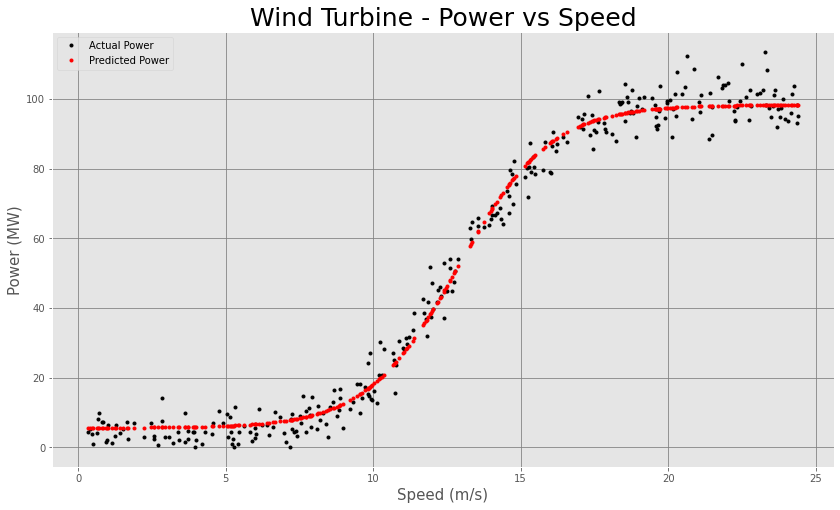

In [70]:
# Now let's see what the train dataset looks like for both the actual data and the predicted values from the model
plt.plot(X_train, y_train, 'k.', label='Actual Power')
plt.plot(X_train, model.predict(X_train), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

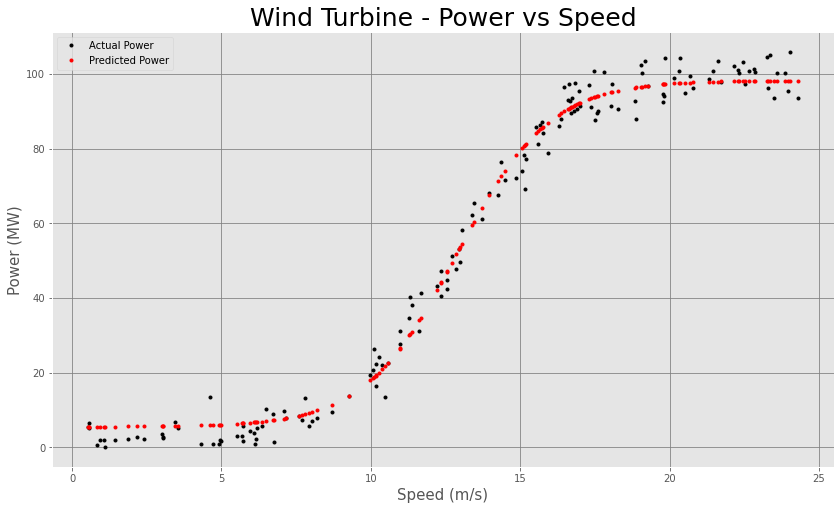

In [71]:
# The ultimate test is how the test dataset fits to its predicted reusults
# Now let's see how the test sample actual and predicted results compare, using the trained model
plt.plot(X_test, y_test, 'k.', label='Actual Power')
plt.plot(X_test, model.predict(X_test), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

In [72]:
# Evaluate the neural network on the test data.
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 748us/step - loss: 16.8196


16.8195858001709

### 5.3 - Test model consisting of: 2 neurons 5000 epochs, batch size=10

![2-neurons](Images/2-neurons.JPG)<br><p style='text-align: right;'>(http://alexlenail.me/NN-SVG/index.html, 2020)</p>

In [73]:
# Build a model using Keras
model = kr.models.Sequential()

# Add a layer with 50 neurons, 1 input (wind speed), using the sigmoid activation function to applied to each neuron, 
# initialise weights and bias with Glorot_uniform Draws samples from a uniform distribution within [-limit, limit], where 
# limit = sqrt(6 / (fan_in + fan_out)) (fan_in is the number of input units in the weight tensor and fan_out is the number 
# of output units).https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform
model.add(kr.layers.Dense(2, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

# Add a layer for the output neuron (Power), using 1 neuron, a linear activation function and, again, glorot_uniform 
# initialisers. Not, we use a linear activation function in this last layer, as we know power outputs are >1, which is the 
# approx the maximum we would obtain if we used a sigmoid activation function.
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

# Compile the model using the above defined neural network, calculating the loss after each epoch using "mean_squared_error"
# method, and applying the Optimizer that implements the Adam algorithm used to affect small changes to weights and bises
# based on the loss calculated after each eopch.https://keras.io/api/optimizers/adam/
model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')

In [74]:
# Fit the training dataset to the above model and run 5000 epochs in batches of 10 at a time.
model.fit(X_train, y_train, epochs=5000, batch_size=10)

Epoch 1/5000
31/31 [==============================] - 0s 655us/step - loss: 4631.2431
Epoch 2/5000
31/31 [==============================] - 0s 797us/step - loss: 4625.1082
Epoch 3/5000
31/31 [==============================] - 0s 898us/step - loss: 4277.6197
Epoch 4/5000
31/31 [==============================] - 0s 967us/step - loss: 4255.4666
Epoch 5/5000
31/31 [==============================] - 0s 997us/step - loss: 4196.9195
Epoch 6/5000
31/31 [==============================] - 0s 997us/step - loss: 4263.2344
Epoch 7/5000
31/31 [==============================] - 0s 864us/step - loss: 4319.2940
Epoch 8/5000
31/31 [==============================] - 0s 831us/step - loss: 4451.8341
Epoch 9/5000
31/31 [==============================] - 0s 931us/step - loss: 4316.5171
Epoch 10/5000
31/31 [==============================] - 0s 964us/step - loss: 4274.3454
Epoch 11/5000
31/31 [==============================] - 0s 965us/step - loss: 4279.2727
Epoch 12/5000
31/31 [==============================]

31/31 [==============================] - 0s 931us/step - loss: 2951.8187
Epoch 189/5000
31/31 [==============================] - 0s 964us/step - loss: 3081.7609
Epoch 190/5000
31/31 [==============================] - 0s 997us/step - loss: 3163.2373
Epoch 191/5000
31/31 [==============================] - 0s 898us/step - loss: 2876.6199
Epoch 192/5000
31/31 [==============================] - 0s 964us/step - loss: 2969.5735
Epoch 193/5000
31/31 [==============================] - 0s 811us/step - loss: 2850.1273
Epoch 194/5000
31/31 [==============================] - 0s 931us/step - loss: 3133.8587
Epoch 195/5000
31/31 [==============================] - 0s 965us/step - loss: 3004.8993
Epoch 196/5000
31/31 [==============================] - 0s 964us/step - loss: 2844.6210
Epoch 197/5000
31/31 [==============================] - 0s 1ms/step - loss: 2953.4100
Epoch 198/5000
31/31 [==============================] - 0s 897us/step - loss: 3017.2805
Epoch 199/5000
31/31 [===========================

31/31 [==============================] - 0s 931us/step - loss: 2064.2986
Epoch 375/5000
31/31 [==============================] - 0s 964us/step - loss: 2099.9148
Epoch 376/5000
31/31 [==============================] - 0s 870us/step - loss: 1724.1116
Epoch 377/5000
31/31 [==============================] - 0s 927us/step - loss: 2004.5086
Epoch 378/5000
31/31 [==============================] - 0s 805us/step - loss: 2033.8153
Epoch 379/5000
31/31 [==============================] - 0s 839us/step - loss: 1958.6346
Epoch 380/5000
31/31 [==============================] - 0s 951us/step - loss: 1859.8252
Epoch 381/5000
31/31 [==============================] - 0s 864us/step - loss: 1891.2611
Epoch 382/5000
31/31 [==============================] - 0s 767us/step - loss: 1915.1717
Epoch 383/5000
31/31 [==============================] - 0s 901us/step - loss: 1847.4146
Epoch 384/5000
31/31 [==============================] - 0s 931us/step - loss: 1783.3770
Epoch 385/5000
31/31 [=========================

31/31 [==============================] - 0s 1ms/step - loss: 1106.8680
Epoch 561/5000
31/31 [==============================] - 0s 1ms/step - loss: 1184.0317
Epoch 562/5000
31/31 [==============================] - 0s 927us/step - loss: 1145.0167
Epoch 563/5000
31/31 [==============================] - 0s 1ms/step - loss: 1027.5912
Epoch 564/5000
31/31 [==============================] - 0s 908us/step - loss: 1105.7810
Epoch 565/5000
31/31 [==============================] - 0s 1ms/step - loss: 1133.5488
Epoch 566/5000
31/31 [==============================] - 0s 898us/step - loss: 1047.5448
Epoch 567/5000
31/31 [==============================] - 0s 1ms/step - loss: 1142.1315
Epoch 568/5000
31/31 [==============================] - 0s 928us/step - loss: 1125.6445
Epoch 569/5000
31/31 [==============================] - 0s 1ms/step - loss: 1105.2358
Epoch 570/5000
31/31 [==============================] - 0s 981us/step - loss: 1002.6973
Epoch 571/5000
31/31 [==============================] - 0s 

31/31 [==============================] - 0s 898us/step - loss: 881.4560
Epoch 656/5000
31/31 [==============================] - 0s 1ms/step - loss: 732.8264
Epoch 657/5000
31/31 [==============================] - 0s 870us/step - loss: 760.8909
Epoch 658/5000
31/31 [==============================] - 0s 1ms/step - loss: 799.2057
Epoch 659/5000
31/31 [==============================] - 0s 1ms/step - loss: 889.6422
Epoch 660/5000
31/31 [==============================] - 0s 1ms/step - loss: 730.1595
Epoch 661/5000
31/31 [==============================] - 0s 1ms/step - loss: 912.5094
Epoch 662/5000
31/31 [==============================] - 0s 920us/step - loss: 845.6644
Epoch 663/5000
31/31 [==============================] - 0s 1ms/step - loss: 784.9293
Epoch 664/5000
31/31 [==============================] - 0s 1ms/step - loss: 743.7600
Epoch 665/5000
31/31 [==============================] - 0s 1ms/step - loss: 842.7241
Epoch 666/5000
31/31 [==============================] - 0s 1ms/step - loss

31/31 [==============================] - 0s 806us/step - loss: 453.2700
Epoch 845/5000
31/31 [==============================] - 0s 964us/step - loss: 415.9572
Epoch 846/5000
31/31 [==============================] - 0s 929us/step - loss: 425.6519
Epoch 847/5000
31/31 [==============================] - 0s 859us/step - loss: 444.9358
Epoch 848/5000
31/31 [==============================] - 0s 901us/step - loss: 441.2635
Epoch 849/5000
31/31 [==============================] - 0s 914us/step - loss: 436.6787
Epoch 850/5000
31/31 [==============================] - 0s 931us/step - loss: 441.2978
Epoch 851/5000
31/31 [==============================] - 0s 808us/step - loss: 424.5671
Epoch 852/5000
31/31 [==============================] - 0s 798us/step - loss: 422.4337
Epoch 853/5000
31/31 [==============================] - 0s 963us/step - loss: 423.0229
Epoch 854/5000
31/31 [==============================] - 0s 888us/step - loss: 442.8101
Epoch 855/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 898us/step - loss: 306.5788
Epoch 939/5000
31/31 [==============================] - 0s 899us/step - loss: 298.8892
Epoch 940/5000
31/31 [==============================] - 0s 829us/step - loss: 293.4369
Epoch 941/5000
31/31 [==============================] - 0s 864us/step - loss: 322.1003
Epoch 942/5000
31/31 [==============================] - 0s 891us/step - loss: 317.4006
Epoch 943/5000
31/31 [==============================] - ETA: 0s - loss: 299.257 - 0s 978us/step - loss: 326.4322
Epoch 944/5000
31/31 [==============================] - 0s 849us/step - loss: 301.1225
Epoch 945/5000
31/31 [==============================] - 0s 864us/step - loss: 320.7642
Epoch 946/5000
31/31 [==============================] - 0s 850us/step - loss: 310.5988
Epoch 947/5000
31/31 [==============================] - 0s 929us/step - loss: 278.4290
Epoch 948/5000
31/31 [==============================] - 0s 964us/step - loss: 295.5363
Epoch 949/5000
31/31 [==========

Epoch 1032/5000
31/31 [==============================] - 0s 765us/step - loss: 223.2808
Epoch 1033/5000
31/31 [==============================] - 0s 1ms/step - loss: 212.6130
Epoch 1034/5000
31/31 [==============================] - 0s 940us/step - loss: 230.6157
Epoch 1035/5000
31/31 [==============================] - 0s 1ms/step - loss: 221.0089
Epoch 1036/5000
31/31 [==============================] - 0s 970us/step - loss: 216.7668
Epoch 1037/5000
31/31 [==============================] - 0s 941us/step - loss: 219.7891
Epoch 1038/5000
31/31 [==============================] - 0s 843us/step - loss: 218.8658
Epoch 1039/5000
31/31 [==============================] - 0s 863us/step - loss: 236.2514
Epoch 1040/5000
31/31 [==============================] - 0s 931us/step - loss: 247.2170
Epoch 1041/5000
31/31 [==============================] - 0s 867us/step - loss: 220.6052
Epoch 1042/5000
31/31 [==============================] - 0s 898us/step - loss: 235.3148
Epoch 1043/5000
31/31 [=============

31/31 [==============================] - 0s 977us/step - loss: 143.6875
Epoch 1219/5000
31/31 [==============================] - 0s 986us/step - loss: 141.4084
Epoch 1220/5000
31/31 [==============================] - 0s 1ms/step - loss: 125.8525
Epoch 1221/5000
31/31 [==============================] - 0s 962us/step - loss: 130.8630
Epoch 1222/5000
31/31 [==============================] - 0s 897us/step - loss: 148.5873
Epoch 1223/5000
31/31 [==============================] - 0s 1ms/step - loss: 138.9077
Epoch 1224/5000
31/31 [==============================] - 0s 924us/step - loss: 139.4118
Epoch 1225/5000
31/31 [==============================] - 0s 982us/step - loss: 139.0759
Epoch 1226/5000
31/31 [==============================] - 0s 1ms/step - loss: 156.6787
Epoch 1227/5000
31/31 [==============================] - 0s 896us/step - loss: 141.5860
Epoch 1228/5000
31/31 [==============================] - 0s 1ms/step - loss: 141.0860
Epoch 1229/5000
31/31 [==============================] -

31/31 [==============================] - 0s 859us/step - loss: 76.9570
Epoch 1407/5000
31/31 [==============================] - 0s 912us/step - loss: 77.5631
Epoch 1408/5000
31/31 [==============================] - 0s 997us/step - loss: 79.6022
Epoch 1409/5000
31/31 [==============================] - 0s 1ms/step - loss: 79.3604
Epoch 1410/5000
31/31 [==============================] - 0s 960us/step - loss: 77.4175
Epoch 1411/5000
31/31 [==============================] - 0s 1ms/step - loss: 79.5770
Epoch 1412/5000
31/31 [==============================] - 0s 898us/step - loss: 90.6639
Epoch 1413/5000
31/31 [==============================] - 0s 839us/step - loss: 78.9844
Epoch 1414/5000
31/31 [==============================] - 0s 946us/step - loss: 80.7184
Epoch 1415/5000
31/31 [==============================] - 0s 1ms/step - loss: 87.0381
Epoch 1416/5000
31/31 [==============================] - 0s 948us/step - loss: 75.8940
Epoch 1417/5000
31/31 [==============================] - 0s 912us

31/31 [==============================] - 0s 820us/step - loss: 46.0988
Epoch 1595/5000
31/31 [==============================] - 0s 997us/step - loss: 46.4317
Epoch 1596/5000
31/31 [==============================] - 0s 899us/step - loss: 43.9222
Epoch 1597/5000
31/31 [==============================] - 0s 965us/step - loss: 42.0004
Epoch 1598/5000
31/31 [==============================] - 0s 962us/step - loss: 47.4021
Epoch 1599/5000
31/31 [==============================] - 0s 826us/step - loss: 46.5067
Epoch 1600/5000
31/31 [==============================] - 0s 931us/step - loss: 42.1460
Epoch 1601/5000
31/31 [==============================] - 0s 960us/step - loss: 48.4771
Epoch 1602/5000
31/31 [==============================] - 0s 944us/step - loss: 45.7549
Epoch 1603/5000
31/31 [==============================] - 0s 921us/step - loss: 40.5785
Epoch 1604/5000
31/31 [==============================] - 0s 847us/step - loss: 43.2633
Epoch 1605/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 965us/step - loss: 29.3074
Epoch 1785/5000
31/31 [==============================] - 0s 1ms/step - loss: 26.1803
Epoch 1786/5000
31/31 [==============================] - 0s 1ms/step - loss: 25.6371
Epoch 1787/5000
31/31 [==============================] - 0s 1ms/step - loss: 24.6847
Epoch 1788/5000
31/31 [==============================] - 0s 872us/step - loss: 25.8297
Epoch 1789/5000
31/31 [==============================] - 0s 964us/step - loss: 23.4723
Epoch 1790/5000
31/31 [==============================] - 0s 827us/step - loss: 26.6984
Epoch 1791/5000
31/31 [==============================] - 0s 1ms/step - loss: 27.0995
Epoch 1792/5000
31/31 [==============================] - 0s 927us/step - loss: 26.3139
Epoch 1793/5000
31/31 [==============================] - 0s 883us/step - loss: 28.4093
Epoch 1794/5000
31/31 [==============================] - 0s 935us/step - loss: 24.6316
Epoch 1795/5000
31/31 [==============================] - 0s 1ms/ste

31/31 [==============================] - 0s 847us/step - loss: 23.6973
Epoch 1973/5000
31/31 [==============================] - 0s 946us/step - loss: 19.0114
Epoch 1974/5000
31/31 [==============================] - 0s 854us/step - loss: 21.7164
Epoch 1975/5000
31/31 [==============================] - 0s 866us/step - loss: 17.8462
Epoch 1976/5000
31/31 [==============================] - 0s 874us/step - loss: 20.3379
Epoch 1977/5000
31/31 [==============================] - 0s 900us/step - loss: 22.3439
Epoch 1978/5000
31/31 [==============================] - 0s 964us/step - loss: 19.9704
Epoch 1979/5000
31/31 [==============================] - 0s 866us/step - loss: 21.0500
Epoch 1980/5000
31/31 [==============================] - 0s 898us/step - loss: 21.4229
Epoch 1981/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.8893
Epoch 1982/5000
31/31 [==============================] - 0s 932us/step - loss: 19.5338
Epoch 1983/5000
31/31 [==============================] - 0s 1

31/31 [==============================] - 0s 965us/step - loss: 20.2656
Epoch 2162/5000
31/31 [==============================] - 0s 964us/step - loss: 20.4603
Epoch 2163/5000
31/31 [==============================] - 0s 898us/step - loss: 17.1878
Epoch 2164/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.7295
Epoch 2165/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.8571
Epoch 2166/5000
31/31 [==============================] - 0s 1ms/step - loss: 21.9949
Epoch 2167/5000
31/31 [==============================] - 0s 931us/step - loss: 20.0828
Epoch 2168/5000
31/31 [==============================] - 0s 931us/step - loss: 20.3176
Epoch 2169/5000
31/31 [==============================] - 0s 1ms/step - loss: 20.6012
Epoch 2170/5000
31/31 [==============================] - 0s 986us/step - loss: 17.8815
Epoch 2171/5000
31/31 [==============================] - 0s 774us/step - loss: 19.0837
Epoch 2172/5000
31/31 [==============================] - 0s 1ms/ste

31/31 [==============================] - 0s 964us/step - loss: 22.1144
Epoch 2350/5000
31/31 [==============================] - 0s 798us/step - loss: 22.2665
Epoch 2351/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.6611
Epoch 2352/5000
31/31 [==============================] - 0s 931us/step - loss: 19.6272
Epoch 2353/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.9806
Epoch 2354/5000
31/31 [==============================] - 0s 964us/step - loss: 19.5884
Epoch 2355/5000
31/31 [==============================] - 0s 896us/step - loss: 19.6764
Epoch 2356/5000
31/31 [==============================] - 0s 931us/step - loss: 19.0619
Epoch 2357/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3915
Epoch 2358/5000
31/31 [==============================] - 0s 997us/step - loss: 20.8930
Epoch 2359/5000
31/31 [==============================] - 0s 898us/step - loss: 16.3095
Epoch 2360/5000
31/31 [==============================] - 0s 865us

31/31 [==============================] - 0s 898us/step - loss: 19.0377
Epoch 2538/5000
31/31 [==============================] - 0s 997us/step - loss: 17.2391
Epoch 2539/5000
31/31 [==============================] - 0s 997us/step - loss: 18.3930
Epoch 2540/5000
31/31 [==============================] - 0s 864us/step - loss: 21.3743
Epoch 2541/5000
31/31 [==============================] - 0s 929us/step - loss: 17.6322
Epoch 2542/5000
31/31 [==============================] - 0s 896us/step - loss: 16.5560
Epoch 2543/5000
31/31 [==============================] - 0s 949us/step - loss: 18.1070
Epoch 2544/5000
31/31 [==============================] - 0s 858us/step - loss: 18.3707
Epoch 2545/5000
31/31 [==============================] - 0s 964us/step - loss: 17.8659
Epoch 2546/5000
31/31 [==============================] - 0s 838us/step - loss: 18.2388
Epoch 2547/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.6730
Epoch 2548/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 931us/step - loss: 18.7184
Epoch 2726/5000
31/31 [==============================] - 0s 866us/step - loss: 17.5913
Epoch 2727/5000
31/31 [==============================] - 0s 821us/step - loss: 17.2138
Epoch 2728/5000
31/31 [==============================] - 0s 888us/step - loss: 19.4727
Epoch 2729/5000
31/31 [==============================] - 0s 964us/step - loss: 18.8686
Epoch 2730/5000
31/31 [==============================] - 0s 876us/step - loss: 17.8160
Epoch 2731/5000
31/31 [==============================] - 0s 798us/step - loss: 21.0799
Epoch 2732/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.5630
Epoch 2733/5000
31/31 [==============================] - 0s 897us/step - loss: 21.3785
Epoch 2734/5000
31/31 [==============================] - 0s 1ms/step - loss: 21.8730
Epoch 2735/5000
31/31 [==============================] - 0s 815us/step - loss: 18.5998
Epoch 2736/5000
31/31 [==============================] - 0s 899

31/31 [==============================] - 0s 898us/step - loss: 21.8692
Epoch 2914/5000
31/31 [==============================] - 0s 964us/step - loss: 17.6196
Epoch 2915/5000
31/31 [==============================] - 0s 932us/step - loss: 18.9433
Epoch 2916/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.7351
Epoch 2917/5000
31/31 [==============================] - 0s 997us/step - loss: 17.4094
Epoch 2918/5000
31/31 [==============================] - 0s 1ms/step - loss: 21.3669
Epoch 2919/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.8683
Epoch 2920/5000
31/31 [==============================] - 0s 997us/step - loss: 16.1509
Epoch 2921/5000
31/31 [==============================] - 0s 997us/step - loss: 17.3884
Epoch 2922/5000
31/31 [==============================] - 0s 895us/step - loss: 17.9695
Epoch 2923/5000
31/31 [==============================] - 0s 831us/step - loss: 18.6276
Epoch 2924/5000
31/31 [==============================] - 0s 1ms/s

31/31 [==============================] - 0s 894us/step - loss: 16.3780
Epoch 3103/5000
31/31 [==============================] - 0s 931us/step - loss: 19.7184
Epoch 3104/5000
31/31 [==============================] - 0s 932us/step - loss: 17.7786
Epoch 3105/5000
31/31 [==============================] - 0s 932us/step - loss: 19.1241
Epoch 3106/5000
31/31 [==============================] - 0s 921us/step - loss: 17.3595
Epoch 3107/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.1148
Epoch 3108/5000
31/31 [==============================] - 0s 963us/step - loss: 18.6621
Epoch 3109/5000
31/31 [==============================] - 0s 964us/step - loss: 20.0894
Epoch 3110/5000
31/31 [==============================] - 0s 899us/step - loss: 21.7007
Epoch 3111/5000
31/31 [==============================] - 0s 861us/step - loss: 18.2298
Epoch 3112/5000
31/31 [==============================] - 0s 965us/step - loss: 17.0254
Epoch 3113/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 997us/step - loss: 20.8659
Epoch 3291/5000
31/31 [==============================] - 0s 931us/step - loss: 17.7733
Epoch 3292/5000
31/31 [==============================] - 0s 899us/step - loss: 18.4908
Epoch 3293/5000
31/31 [==============================] - 0s 898us/step - loss: 18.0071
Epoch 3294/5000
31/31 [==============================] - 0s 958us/step - loss: 18.3064
Epoch 3295/5000
31/31 [==============================] - 0s 788us/step - loss: 17.7490
Epoch 3296/5000
31/31 [==============================] - 0s 898us/step - loss: 15.7368
Epoch 3297/5000
31/31 [==============================] - 0s 860us/step - loss: 19.7400
Epoch 3298/5000
31/31 [==============================] - 0s 882us/step - loss: 17.8890
Epoch 3299/5000
31/31 [==============================] - 0s 859us/step - loss: 17.0618
Epoch 3300/5000
31/31 [==============================] - 0s 932us/step - loss: 19.4768
Epoch 3301/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 780us/step - loss: 20.8473
Epoch 3479/5000
31/31 [==============================] - 0s 931us/step - loss: 16.2988
Epoch 3480/5000
31/31 [==============================] - 0s 864us/step - loss: 18.4238
Epoch 3481/5000
31/31 [==============================] - 0s 931us/step - loss: 16.3760
Epoch 3482/5000
31/31 [==============================] - 0s 809us/step - loss: 17.1248
Epoch 3483/5000
31/31 [==============================] - 0s 931us/step - loss: 17.7324
Epoch 3484/5000
31/31 [==============================] - 0s 945us/step - loss: 18.7971
Epoch 3485/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1424
Epoch 3486/5000
31/31 [==============================] - 0s 931us/step - loss: 18.1559
Epoch 3487/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.1154
Epoch 3488/5000
31/31 [==============================] - 0s 998us/step - loss: 16.1160
Epoch 3489/5000
31/31 [==============================] - 0s 967

31/31 [==============================] - 0s 931us/step - loss: 19.1939
Epoch 3667/5000
31/31 [==============================] - 0s 836us/step - loss: 16.4924
Epoch 3668/5000
31/31 [==============================] - 0s 897us/step - loss: 19.7071
Epoch 3669/5000
31/31 [==============================] - 0s 887us/step - loss: 18.1378
Epoch 3670/5000
31/31 [==============================] - 0s 931us/step - loss: 19.4786
Epoch 3671/5000
31/31 [==============================] - 0s 864us/step - loss: 20.4427
Epoch 3672/5000
31/31 [==============================] - 0s 792us/step - loss: 17.9671
Epoch 3673/5000
31/31 [==============================] - 0s 880us/step - loss: 16.5803
Epoch 3674/5000
31/31 [==============================] - 0s 786us/step - loss: 15.2657
Epoch 3675/5000
31/31 [==============================] - 0s 897us/step - loss: 20.2058
Epoch 3676/5000
31/31 [==============================] - 0s 960us/step - loss: 20.1212
Epoch 3677/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 898us/step - loss: 17.3698
Epoch 3855/5000
31/31 [==============================] - 0s 898us/step - loss: 16.8165
Epoch 3856/5000
31/31 [==============================] - 0s 931us/step - loss: 15.7788
Epoch 3857/5000
31/31 [==============================] - 0s 826us/step - loss: 18.7321
Epoch 3858/5000
31/31 [==============================] - 0s 898us/step - loss: 16.9279
Epoch 3859/5000
31/31 [==============================] - 0s 852us/step - loss: 18.4570
Epoch 3860/5000
31/31 [==============================] - 0s 898us/step - loss: 17.0603
Epoch 3861/5000
31/31 [==============================] - 0s 897us/step - loss: 16.7705
Epoch 3862/5000
31/31 [==============================] - 0s 958us/step - loss: 19.1109
Epoch 3863/5000
31/31 [==============================] - 0s 964us/step - loss: 17.9736
Epoch 3864/5000
31/31 [==============================] - 0s 802us/step - loss: 15.4889
Epoch 3865/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 965us/step - loss: 17.7864
Epoch 4043/5000
31/31 [==============================] - 0s 931us/step - loss: 18.6549
Epoch 4044/5000
31/31 [==============================] - 0s 826us/step - loss: 17.3503
Epoch 4045/5000
31/31 [==============================] - 0s 899us/step - loss: 18.7749
Epoch 4046/5000
31/31 [==============================] - 0s 921us/step - loss: 20.1153
Epoch 4047/5000
31/31 [==============================] - 0s 938us/step - loss: 18.5047
Epoch 4048/5000
31/31 [==============================] - 0s 931us/step - loss: 18.5108
Epoch 4049/5000
31/31 [==============================] - 0s 964us/step - loss: 18.8614
Epoch 4050/5000
31/31 [==============================] - 0s 930us/step - loss: 19.6481
Epoch 4051/5000
31/31 [==============================] - 0s 880us/step - loss: 20.3063
Epoch 4052/5000
31/31 [==============================] - 0s 898us/step - loss: 17.8770
Epoch 4053/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 931us/step - loss: 17.9749
Epoch 4231/5000
31/31 [==============================] - 0s 866us/step - loss: 16.8320
Epoch 4232/5000
31/31 [==============================] - 0s 863us/step - loss: 16.7764
Epoch 4233/5000
31/31 [==============================] - 0s 997us/step - loss: 20.8786
Epoch 4234/5000
31/31 [==============================] - 0s 964us/step - loss: 18.5287
Epoch 4235/5000
31/31 [==============================] - 0s 866us/step - loss: 18.8688
Epoch 4236/5000
31/31 [==============================] - 0s 939us/step - loss: 18.4462
Epoch 4237/5000
31/31 [==============================] - 0s 864us/step - loss: 17.8597
Epoch 4238/5000
31/31 [==============================] - 0s 930us/step - loss: 16.4925
Epoch 4239/5000
31/31 [==============================] - 0s 833us/step - loss: 19.9155
Epoch 4240/5000
31/31 [==============================] - 0s 964us/step - loss: 17.3216
Epoch 4241/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 942us/step - loss: 19.6707
Epoch 4419/5000
31/31 [==============================] - 0s 931us/step - loss: 15.6178
Epoch 4420/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3996
Epoch 4421/5000
31/31 [==============================] - 0s 997us/step - loss: 15.1795
Epoch 4422/5000
31/31 [==============================] - 0s 998us/step - loss: 16.1763
Epoch 4423/5000
31/31 [==============================] - 0s 793us/step - loss: 18.4215
Epoch 4424/5000
31/31 [==============================] - 0s 964us/step - loss: 14.5928
Epoch 4425/5000
31/31 [==============================] - 0s 864us/step - loss: 18.1981
Epoch 4426/5000
31/31 [==============================] - 0s 830us/step - loss: 17.3968
Epoch 4427/5000
31/31 [==============================] - 0s 875us/step - loss: 17.3677
Epoch 4428/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.5955
Epoch 4429/5000
31/31 [==============================] - 0s 997

31/31 [==============================] - 0s 931us/step - loss: 18.9122
Epoch 4607/5000
31/31 [==============================] - 0s 997us/step - loss: 16.2648
Epoch 4608/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.8657
Epoch 4609/5000
31/31 [==============================] - 0s 964us/step - loss: 21.1965
Epoch 4610/5000
31/31 [==============================] - 0s 854us/step - loss: 17.4531
Epoch 4611/5000
31/31 [==============================] - 0s 985us/step - loss: 20.3303
Epoch 4612/5000
31/31 [==============================] - 0s 887us/step - loss: 19.4153
Epoch 4613/5000
31/31 [==============================] - 0s 931us/step - loss: 22.0252
Epoch 4614/5000
31/31 [==============================] - 0s 849us/step - loss: 17.6315
Epoch 4615/5000
31/31 [==============================] - 0s 892us/step - loss: 16.9726
Epoch 4616/5000
31/31 [==============================] - 0s 953us/step - loss: 20.0520
Epoch 4617/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 931us/step - loss: 18.3566
Epoch 4702/5000
31/31 [==============================] - 0s 897us/step - loss: 17.1529
Epoch 4703/5000
31/31 [==============================] - 0s 899us/step - loss: 14.8769
Epoch 4704/5000
31/31 [==============================] - 0s 963us/step - loss: 18.6564
Epoch 4705/5000
31/31 [==============================] - 0s 965us/step - loss: 18.1653
Epoch 4706/5000
31/31 [==============================] - 0s 925us/step - loss: 18.2486
Epoch 4707/5000
31/31 [==============================] - 0s 864us/step - loss: 16.3137
Epoch 4708/5000
31/31 [==============================] - 0s 961us/step - loss: 20.6294
Epoch 4709/5000
31/31 [==============================] - 0s 939us/step - loss: 18.0630
Epoch 4710/5000
31/31 [==============================] - 0s 832us/step - loss: 18.3170
Epoch 4711/5000
31/31 [==============================] - 0s 836us/step - loss: 17.2168
Epoch 4712/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 1ms/step - loss: 16.1031
Epoch 4891/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.3794
Epoch 4892/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.5455
Epoch 4893/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.5577
Epoch 4894/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.3456
Epoch 4895/5000
31/31 [==============================] - 0s 1ms/step - loss: 20.7541
Epoch 4896/5000
31/31 [==============================] - 0s 963us/step - loss: 17.6557
Epoch 4897/5000
31/31 [==============================] - 0s 997us/step - loss: 17.3714
Epoch 4898/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.2164
Epoch 4899/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.2556
Epoch 4900/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.6204
Epoch 4901/5000
31/31 [==============================] - 0s 1ms/step - loss: 

Epoch 4985/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9815
Epoch 4986/5000
31/31 [==============================] - 0s 964us/step - loss: 17.6344
Epoch 4987/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.2867
Epoch 4988/5000
31/31 [==============================] - 0s 830us/step - loss: 17.7400
Epoch 4989/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8583
Epoch 4990/5000
31/31 [==============================] - 0s 897us/step - loss: 17.7484
Epoch 4991/5000
31/31 [==============================] - 0s 793us/step - loss: 18.5151
Epoch 4992/5000
31/31 [==============================] - 0s 931us/step - loss: 17.5922
Epoch 4993/5000
31/31 [==============================] - 0s 864us/step - loss: 18.0226
Epoch 4994/5000
31/31 [==============================] - 0s 788us/step - loss: 17.4229
Epoch 4995/5000
31/31 [==============================] - 0s 964us/step - loss: 17.1798
Epoch 4996/5000
31/31 [==========================

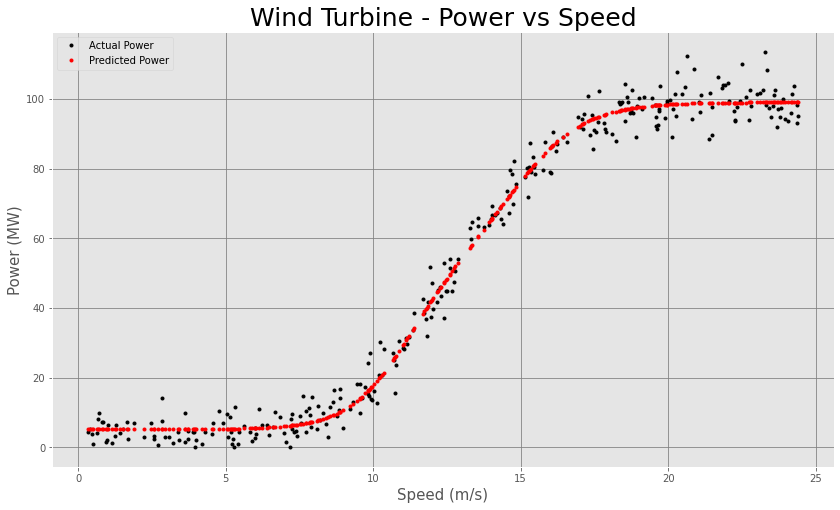

In [75]:
# Now let's see what the train dataset looks like for both the actual data and the predicted values from the model
plt.plot(X_train, y_train, 'k.', label='Actual Power')
plt.plot(X_train, model.predict(X_train), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

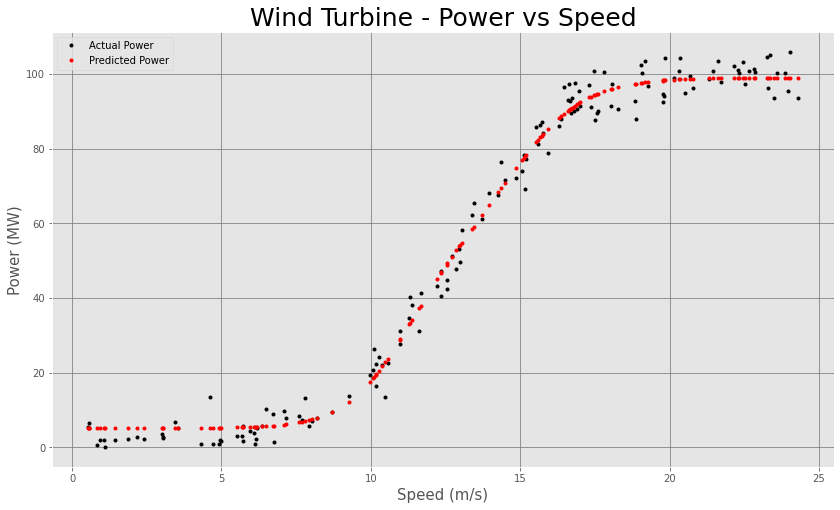

In [76]:
# The ultimate test is how the test dataset fits to its predicted reusults
# Now let's see how the test sample actual and predicted results compare, using the trained model
plt.plot(X_test, y_test, 'k.', label='Actual Power')
plt.plot(X_test, model.predict(X_test), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

In [77]:
# Evaluate the neural network on the test data.
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 998us/step - loss: 14.9920


14.992018699645996

### 5.4 - Test model consisting of: 3 neurons 5000 epochs, batch size=10

![3-neurons](Images/3-neurons.JPG)<br><p style='text-align: right;'>(http://alexlenail.me/NN-SVG/index.html, 2020)</p>

In [78]:
# Build a model using Keras
model = kr.models.Sequential()

# Add a layer with 50 neurons, 1 input (wind speed), using the sigmoid activation function to applied to each neuron, 
# initialise weights and bias with Glorot_uniform Draws samples from a uniform distribution within [-limit, limit], where 
# limit = sqrt(6 / (fan_in + fan_out)) (fan_in is the number of input units in the weight tensor and fan_out is the number 
# of output units).https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform
model.add(kr.layers.Dense(3, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

# Add a layer for the output neuron (Power), using 1 neuron, a linear activation function and, again, glorot_uniform 
# initialisers. Not, we use a linear activation function in this last layer, as we know power outputs are >1, which is the 
# approx the maximum we would obtain if we used a sigmoid activation function.
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

# Compile the model using the above defined neural network, calculating the loss after each epoch using "mean_squared_error"
# method, and applying the Optimizer that implements the Adam algorithm used to affect small changes to weights and bises
# based on the loss calculated after each eopch.https://keras.io/api/optimizers/adam/
model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')

In [79]:
# Fit the training dataset to the above model and run 5000 epochs in batches of 10 at a time.
model.fit(X_train, y_train, epochs=5000, batch_size=10)

Epoch 1/5000
31/31 [==============================] - 0s 820us/step - loss: 4215.7630
Epoch 2/5000
31/31 [==============================] - 0s 931us/step - loss: 4236.4489
Epoch 3/5000
31/31 [==============================] - 0s 898us/step - loss: 3986.2430
Epoch 4/5000
31/31 [==============================] - 0s 964us/step - loss: 4015.5075
Epoch 5/5000
31/31 [==============================] - 0s 898us/step - loss: 4206.4881
Epoch 6/5000
31/31 [==============================] - 0s 832us/step - loss: 4121.3556
Epoch 7/5000
31/31 [==============================] - 0s 1ms/step - loss: 4016.3617
Epoch 8/5000
31/31 [==============================] - 0s 997us/step - loss: 4033.9351
Epoch 9/5000
31/31 [==============================] - 0s 798us/step - loss: 3731.7184
Epoch 10/5000
31/31 [==============================] - 0s 931us/step - loss: 4097.0546
Epoch 11/5000
31/31 [==============================] - 0s 963us/step - loss: 4294.0762
Epoch 12/5000
31/31 [==============================] -

31/31 [==============================] - 0s 832us/step - loss: 2470.5330
Epoch 189/5000
31/31 [==============================] - 0s 817us/step - loss: 2194.1147
Epoch 190/5000
31/31 [==============================] - 0s 931us/step - loss: 2232.4444
Epoch 191/5000
31/31 [==============================] - 0s 864us/step - loss: 2327.4671
Epoch 192/5000
31/31 [==============================] - 0s 931us/step - loss: 2569.6311
Epoch 193/5000
31/31 [==============================] - 0s 847us/step - loss: 2258.9460
Epoch 194/5000
31/31 [==============================] - 0s 997us/step - loss: 2457.0187
Epoch 195/5000
31/31 [==============================] - 0s 929us/step - loss: 2244.0484
Epoch 196/5000
31/31 [==============================] - 0s 931us/step - loss: 2245.0895
Epoch 197/5000
31/31 [==============================] - 0s 898us/step - loss: 2267.9750
Epoch 198/5000
31/31 [==============================] - 0s 888us/step - loss: 2318.8346
Epoch 199/5000
31/31 [=========================

31/31 [==============================] - 0s 864us/step - loss: 1345.2838
Epoch 375/5000
31/31 [==============================] - 0s 931us/step - loss: 1119.0045
Epoch 376/5000
31/31 [==============================] - 0s 898us/step - loss: 1111.0193
Epoch 377/5000
31/31 [==============================] - 0s 830us/step - loss: 1212.6305
Epoch 378/5000
31/31 [==============================] - 0s 898us/step - loss: 1332.3989
Epoch 379/5000
31/31 [==============================] - 0s 808us/step - loss: 1298.9144
Epoch 380/5000
31/31 [==============================] - 0s 889us/step - loss: 1292.3153
Epoch 381/5000
31/31 [==============================] - 0s 864us/step - loss: 1217.8796
Epoch 382/5000
31/31 [==============================] - 0s 853us/step - loss: 1292.2050
Epoch 383/5000
31/31 [==============================] - 0s 822us/step - loss: 1245.4899
Epoch 384/5000
31/31 [==============================] - 0s 884us/step - loss: 1196.5560
Epoch 385/5000
31/31 [=========================

31/31 [==============================] - 0s 963us/step - loss: 555.8542
Epoch 562/5000
31/31 [==============================] - 0s 798us/step - loss: 584.2829
Epoch 563/5000
31/31 [==============================] - 0s 866us/step - loss: 533.3161
Epoch 564/5000
31/31 [==============================] - 0s 1ms/step - loss: 465.5063
Epoch 565/5000
31/31 [==============================] - 0s 1ms/step - loss: 498.4990
Epoch 566/5000
31/31 [==============================] - 0s 1ms/step - loss: 536.5728
Epoch 567/5000
31/31 [==============================] - 0s 896us/step - loss: 484.5639
Epoch 568/5000
31/31 [==============================] - 0s 848us/step - loss: 513.2715
Epoch 569/5000
31/31 [==============================] - 0s 974us/step - loss: 490.3860
Epoch 570/5000
31/31 [==============================] - 0s 964us/step - loss: 521.3566
Epoch 571/5000
31/31 [==============================] - 0s 832us/step - loss: 475.1085
Epoch 572/5000
31/31 [==============================] - 0s 899us

31/31 [==============================] - 0s 898us/step - loss: 170.2959
Epoch 750/5000
31/31 [==============================] - 0s 864us/step - loss: 199.8233
Epoch 751/5000
31/31 [==============================] - 0s 964us/step - loss: 194.3924
Epoch 752/5000
31/31 [==============================] - 0s 940us/step - loss: 171.4110
Epoch 753/5000
31/31 [==============================] - 0s 898us/step - loss: 185.4912
Epoch 754/5000
31/31 [==============================] - 0s 967us/step - loss: 192.6057
Epoch 755/5000
31/31 [==============================] - 0s 865us/step - loss: 207.1400
Epoch 756/5000
31/31 [==============================] - 0s 931us/step - loss: 198.2863
Epoch 757/5000
31/31 [==============================] - 0s 832us/step - loss: 182.8177
Epoch 758/5000
31/31 [==============================] - 0s 835us/step - loss: 174.7680
Epoch 759/5000
31/31 [==============================] - 0s 899us/step - loss: 197.8168
Epoch 760/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 999us/step - loss: 80.4854
Epoch 940/5000
31/31 [==============================] - 0s 1ms/step - loss: 83.5256
Epoch 941/5000
31/31 [==============================] - 0s 999us/step - loss: 74.5903
Epoch 942/5000
31/31 [==============================] - 0s 997us/step - loss: 68.9322
Epoch 943/5000
31/31 [==============================] - 0s 831us/step - loss: 74.2902
Epoch 944/5000
31/31 [==============================] - 0s 878us/step - loss: 82.2866
Epoch 945/5000
31/31 [==============================] - 0s 997us/step - loss: 85.1748
Epoch 946/5000
31/31 [==============================] - 0s 915us/step - loss: 87.6179
Epoch 947/5000
31/31 [==============================] - 0s 931us/step - loss: 76.3108
Epoch 948/5000
31/31 [==============================] - 0s 948us/step - loss: 80.9801
Epoch 949/5000
31/31 [==============================] - 0s 898us/step - loss: 81.6376
Epoch 950/5000
31/31 [==============================] - 0s 922us/step -

31/31 [==============================] - 0s 923us/step - loss: 56.6462
Epoch 1036/5000
31/31 [==============================] - 0s 931us/step - loss: 49.2792
Epoch 1037/5000
31/31 [==============================] - 0s 931us/step - loss: 53.1185
Epoch 1038/5000
31/31 [==============================] - 0s 902us/step - loss: 52.0210
Epoch 1039/5000
31/31 [==============================] - 0s 851us/step - loss: 53.5144
Epoch 1040/5000
31/31 [==============================] - 0s 898us/step - loss: 52.5786
Epoch 1041/5000
31/31 [==============================] - 0s 831us/step - loss: 61.3124
Epoch 1042/5000
31/31 [==============================] - 0s 786us/step - loss: 58.6857
Epoch 1043/5000
31/31 [==============================] - 0s 898us/step - loss: 50.1692
Epoch 1044/5000
31/31 [==============================] - 0s 997us/step - loss: 54.0925
Epoch 1045/5000
31/31 [==============================] - 0s 1ms/step - loss: 56.4065
Epoch 1046/5000
31/31 [==============================] - 0s 1

31/31 [==============================] - 0s 898us/step - loss: 29.2654
Epoch 1226/5000
31/31 [==============================] - 0s 898us/step - loss: 27.6416
Epoch 1227/5000
31/31 [==============================] - 0s 864us/step - loss: 31.4839
Epoch 1228/5000
31/31 [==============================] - 0s 776us/step - loss: 32.1240
Epoch 1229/5000
31/31 [==============================] - 0s 965us/step - loss: 31.6537
Epoch 1230/5000
31/31 [==============================] - 0s 964us/step - loss: 29.1022
Epoch 1231/5000
31/31 [==============================] - 0s 905us/step - loss: 28.3195
Epoch 1232/5000
31/31 [==============================] - 0s 864us/step - loss: 29.7791
Epoch 1233/5000
31/31 [==============================] - 0s 932us/step - loss: 28.9587
Epoch 1234/5000
31/31 [==============================] - 0s 931us/step - loss: 31.3628
Epoch 1235/5000
31/31 [==============================] - 0s 964us/step - loss: 27.5497
Epoch 1236/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 831us/step - loss: 20.2525
Epoch 1414/5000
31/31 [==============================] - 0s 898us/step - loss: 19.3818
Epoch 1415/5000
31/31 [==============================] - 0s 931us/step - loss: 20.4526
Epoch 1416/5000
31/31 [==============================] - 0s 964us/step - loss: 19.0088
Epoch 1417/5000
31/31 [==============================] - 0s 998us/step - loss: 19.3511
Epoch 1418/5000
31/31 [==============================] - 0s 1ms/step - loss: 21.4356
Epoch 1419/5000
31/31 [==============================] - 0s 1ms/step - loss: 21.5065
Epoch 1420/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.4601
Epoch 1421/5000
31/31 [==============================] - 0s 1ms/step - loss: 23.0139
Epoch 1422/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3819
Epoch 1423/5000
31/31 [==============================] - 0s 866us/step - loss: 22.2024
Epoch 1424/5000
31/31 [==============================] - 0s 864us/ste

31/31 [==============================] - 0s 913us/step - loss: 18.1870
Epoch 1602/5000
31/31 [==============================] - 0s 860us/step - loss: 18.6822
Epoch 1603/5000
31/31 [==============================] - 0s 931us/step - loss: 20.1678
Epoch 1604/5000
31/31 [==============================] - 0s 932us/step - loss: 17.4412
Epoch 1605/5000
31/31 [==============================] - 0s 964us/step - loss: 19.6697
Epoch 1606/5000
31/31 [==============================] - 0s 899us/step - loss: 17.0094
Epoch 1607/5000
31/31 [==============================] - 0s 866us/step - loss: 17.7873
Epoch 1608/5000
31/31 [==============================] - 0s 825us/step - loss: 17.0392
Epoch 1609/5000
31/31 [==============================] - 0s 965us/step - loss: 16.7743
Epoch 1610/5000
31/31 [==============================] - 0s 964us/step - loss: 18.0630
Epoch 1611/5000
31/31 [==============================] - 0s 898us/step - loss: 19.1161
Epoch 1612/5000
31/31 [==============================] - 0s

Epoch 1696/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.5528
Epoch 1697/5000
31/31 [==============================] - 0s 997us/step - loss: 19.1165
Epoch 1698/5000
31/31 [==============================] - 0s 859us/step - loss: 17.7237
Epoch 1699/5000
31/31 [==============================] - 0s 859us/step - loss: 17.1398
Epoch 1700/5000
31/31 [==============================] - 0s 964us/step - loss: 18.6322
Epoch 1701/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.7478
Epoch 1702/5000
31/31 [==============================] - 0s 963us/step - loss: 21.6691
Epoch 1703/5000
31/31 [==============================] - 0s 864us/step - loss: 17.8687
Epoch 1704/5000
31/31 [==============================] - 0s 862us/step - loss: 18.2384
Epoch 1705/5000
31/31 [==============================] - 0s 822us/step - loss: 17.5612
Epoch 1706/5000
31/31 [==============================] - 0s 932us/step - loss: 17.8271
Epoch 1707/5000
31/31 [========================

31/31 [==============================] - 0s 896us/step - loss: 17.2677
Epoch 1885/5000
31/31 [==============================] - 0s 864us/step - loss: 21.0931
Epoch 1886/5000
31/31 [==============================] - 0s 964us/step - loss: 16.8351
Epoch 1887/5000
31/31 [==============================] - 0s 964us/step - loss: 15.1740
Epoch 1888/5000
31/31 [==============================] - 0s 999us/step - loss: 17.2772
Epoch 1889/5000
31/31 [==============================] - 0s 931us/step - loss: 16.3579
Epoch 1890/5000
31/31 [==============================] - 0s 831us/step - loss: 19.2747
Epoch 1891/5000
31/31 [==============================] - 0s 852us/step - loss: 16.5883
Epoch 1892/5000
31/31 [==============================] - 0s 870us/step - loss: 17.5551
Epoch 1893/5000
31/31 [==============================] - 0s 898us/step - loss: 16.1627
Epoch 1894/5000
31/31 [==============================] - 0s 829us/step - loss: 17.2614
Epoch 1895/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 964us/step - loss: 17.7900
Epoch 2073/5000
31/31 [==============================] - 0s 964us/step - loss: 16.7387
Epoch 2074/5000
31/31 [==============================] - 0s 898us/step - loss: 17.7589
Epoch 2075/5000
31/31 [==============================] - 0s 864us/step - loss: 17.9501
Epoch 2076/5000
31/31 [==============================] - 0s 997us/step - loss: 17.4569
Epoch 2077/5000
31/31 [==============================] - 0s 964us/step - loss: 18.4849
Epoch 2078/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.5411
Epoch 2079/5000
31/31 [==============================] - 0s 906us/step - loss: 20.2270
Epoch 2080/5000
31/31 [==============================] - 0s 798us/step - loss: 18.7179
Epoch 2081/5000
31/31 [==============================] - 0s 898us/step - loss: 17.1538
Epoch 2082/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.6249
Epoch 2083/5000
31/31 [==============================] - 0s 898

31/31 [==============================] - 0s 866us/step - loss: 17.7367
Epoch 2261/5000
31/31 [==============================] - 0s 931us/step - loss: 20.7159
Epoch 2262/5000
31/31 [==============================] - 0s 911us/step - loss: 18.6787
Epoch 2263/5000
31/31 [==============================] - 0s 899us/step - loss: 15.8397
Epoch 2264/5000
31/31 [==============================] - 0s 823us/step - loss: 15.5774
Epoch 2265/5000
31/31 [==============================] - 0s 903us/step - loss: 18.4211
Epoch 2266/5000
31/31 [==============================] - 0s 898us/step - loss: 17.2600
Epoch 2267/5000
31/31 [==============================] - 0s 794us/step - loss: 21.0236
Epoch 2268/5000
31/31 [==============================] - 0s 932us/step - loss: 17.6677
Epoch 2269/5000
31/31 [==============================] - 0s 997us/step - loss: 18.4922
Epoch 2270/5000
31/31 [==============================] - 0s 919us/step - loss: 16.2229
Epoch 2271/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 964us/step - loss: 16.0799
Epoch 2449/5000
31/31 [==============================] - 0s 898us/step - loss: 18.9739
Epoch 2450/5000
31/31 [==============================] - 0s 841us/step - loss: 15.8984
Epoch 2451/5000
31/31 [==============================] - 0s 930us/step - loss: 16.3924
Epoch 2452/5000
31/31 [==============================] - 0s 999us/step - loss: 17.1472
Epoch 2453/5000
31/31 [==============================] - 0s 987us/step - loss: 16.4393
Epoch 2454/5000
31/31 [==============================] - 0s 960us/step - loss: 20.3745
Epoch 2455/5000
31/31 [==============================] - 0s 975us/step - loss: 17.9727
Epoch 2456/5000
31/31 [==============================] - 0s 837us/step - loss: 17.6899
Epoch 2457/5000
31/31 [==============================] - 0s 964us/step - loss: 19.0039
Epoch 2458/5000
31/31 [==============================] - 0s 805us/step - loss: 19.2878
Epoch 2459/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 931us/step - loss: 18.6821
Epoch 2637/5000
31/31 [==============================] - 0s 894us/step - loss: 17.8560
Epoch 2638/5000
31/31 [==============================] - 0s 877us/step - loss: 18.9867
Epoch 2639/5000
31/31 [==============================] - 0s 954us/step - loss: 17.9879
Epoch 2640/5000
31/31 [==============================] - 0s 852us/step - loss: 20.0356
Epoch 2641/5000
31/31 [==============================] - 0s 829us/step - loss: 17.2687
Epoch 2642/5000
31/31 [==============================] - 0s 916us/step - loss: 18.2459
Epoch 2643/5000
31/31 [==============================] - ETA: 0s - loss: 16.76 - 0s 911us/step - loss: 16.3842
Epoch 2644/5000
31/31 [==============================] - 0s 997us/step - loss: 20.3963
Epoch 2645/5000
31/31 [==============================] - 0s 845us/step - loss: 17.4852
Epoch 2646/5000
31/31 [==============================] - 0s 898us/step - loss: 17.3958
Epoch 2647/5000
31/31 [============

31/31 [==============================] - 0s 931us/step - loss: 17.0698
Epoch 2825/5000
31/31 [==============================] - 0s 997us/step - loss: 21.1464
Epoch 2826/5000
31/31 [==============================] - 0s 850us/step - loss: 17.0587
Epoch 2827/5000
31/31 [==============================] - 0s 931us/step - loss: 18.9090
Epoch 2828/5000
31/31 [==============================] - 0s 949us/step - loss: 17.6390
Epoch 2829/5000
31/31 [==============================] - 0s 898us/step - loss: 17.2839
Epoch 2830/5000
31/31 [==============================] - 0s 848us/step - loss: 18.7114
Epoch 2831/5000
31/31 [==============================] - 0s 898us/step - loss: 16.6594
Epoch 2832/5000
31/31 [==============================] - 0s 855us/step - loss: 18.2411
Epoch 2833/5000
31/31 [==============================] - 0s 886us/step - loss: 18.1353
Epoch 2834/5000
31/31 [==============================] - 0s 864us/step - loss: 17.2072
Epoch 2835/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 1ms/step - loss: 19.8410
Epoch 3013/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.3418
Epoch 3014/5000
31/31 [==============================] - 0s 964us/step - loss: 17.7626
Epoch 3015/5000
31/31 [==============================] - 0s 931us/step - loss: 16.4836
Epoch 3016/5000
31/31 [==============================] - 0s 931us/step - loss: 17.4107
Epoch 3017/5000
31/31 [==============================] - 0s 829us/step - loss: 17.0749
Epoch 3018/5000
31/31 [==============================] - 0s 899us/step - loss: 17.5157
Epoch 3019/5000
31/31 [==============================] - 0s 931us/step - loss: 16.1804
Epoch 3020/5000
31/31 [==============================] - 0s 864us/step - loss: 15.5148
Epoch 3021/5000
31/31 [==============================] - 0s 924us/step - loss: 17.3024
Epoch 3022/5000
31/31 [==============================] - 0s 931us/step - loss: 14.8617
Epoch 3023/5000
31/31 [==============================] - 0s 815

31/31 [==============================] - 0s 789us/step - loss: 17.1195
Epoch 3201/5000
31/31 [==============================] - 0s 898us/step - loss: 15.2052
Epoch 3202/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9157
Epoch 3203/5000
31/31 [==============================] - 0s 998us/step - loss: 17.8454
Epoch 3204/5000
31/31 [==============================] - 0s 931us/step - loss: 17.4449
Epoch 3205/5000
31/31 [==============================] - 0s 846us/step - loss: 19.6885
Epoch 3206/5000
31/31 [==============================] - 0s 932us/step - loss: 18.5808
Epoch 3207/5000
31/31 [==============================] - 0s 831us/step - loss: 20.0192
Epoch 3208/5000
31/31 [==============================] - 0s 896us/step - loss: 16.5414
Epoch 3209/5000
31/31 [==============================] - 0s 964us/step - loss: 16.2560
Epoch 3210/5000
31/31 [==============================] - 0s 932us/step - loss: 18.5180
Epoch 3211/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 931us/step - loss: 16.7303
Epoch 3389/5000
31/31 [==============================] - 0s 930us/step - loss: 18.6793
Epoch 3390/5000
31/31 [==============================] - 0s 831us/step - loss: 18.3676
Epoch 3391/5000
31/31 [==============================] - 0s 898us/step - loss: 19.1880
Epoch 3392/5000
31/31 [==============================] - 0s 964us/step - loss: 17.3310
Epoch 3393/5000
31/31 [==============================] - 0s 964us/step - loss: 18.2717
Epoch 3394/5000
31/31 [==============================] - 0s 997us/step - loss: 16.4284
Epoch 3395/5000
31/31 [==============================] - 0s 933us/step - loss: 18.1908
Epoch 3396/5000
31/31 [==============================] - 0s 997us/step - loss: 15.7028
Epoch 3397/5000
31/31 [==============================] - 0s 964us/step - loss: 17.1063
Epoch 3398/5000
31/31 [==============================] - 0s 980us/step - loss: 18.2733
Epoch 3399/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 902us/step - loss: 18.0149
Epoch 3483/5000
31/31 [==============================] - 0s 931us/step - loss: 17.9039
Epoch 3484/5000
31/31 [==============================] - 0s 964us/step - loss: 14.5460
Epoch 3485/5000
31/31 [==============================] - 0s 880us/step - loss: 17.8534
Epoch 3486/5000
31/31 [==============================] - 0s 898us/step - loss: 14.6720
Epoch 3487/5000
31/31 [==============================] - 0s 798us/step - loss: 18.0736
Epoch 3488/5000
31/31 [==============================] - 0s 899us/step - loss: 17.8210
Epoch 3489/5000
31/31 [==============================] - 0s 932us/step - loss: 16.6155
Epoch 3490/5000
31/31 [==============================] - 0s 816us/step - loss: 16.2413
Epoch 3491/5000
31/31 [==============================] - 0s 898us/step - loss: 19.1189
Epoch 3492/5000
31/31 [==============================] - 0s 964us/step - loss: 19.5575
Epoch 3493/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 931us/step - loss: 17.5240
Epoch 3671/5000
31/31 [==============================] - 0s 931us/step - loss: 18.4494
Epoch 3672/5000
31/31 [==============================] - 0s 964us/step - loss: 17.8831
Epoch 3673/5000
31/31 [==============================] - 0s 913us/step - loss: 16.0081
Epoch 3674/5000
31/31 [==============================] - 0s 865us/step - loss: 17.3146
Epoch 3675/5000
31/31 [==============================] - 0s 855us/step - loss: 14.8638
Epoch 3676/5000
31/31 [==============================] - 0s 912us/step - loss: 17.4148
Epoch 3677/5000
31/31 [==============================] - 0s 834us/step - loss: 17.6041
Epoch 3678/5000
31/31 [==============================] - 0s 997us/step - loss: 15.2162
Epoch 3679/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.3670
Epoch 3680/5000
31/31 [==============================] - 0s 898us/step - loss: 18.1160
Epoch 3681/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 907us/step - loss: 17.9445
Epoch 3859/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.9947
Epoch 3860/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.8590
Epoch 3861/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.1030
Epoch 3862/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.2160
Epoch 3863/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.3107
Epoch 3864/5000
31/31 [==============================] - 0s 964us/step - loss: 16.9006
Epoch 3865/5000
31/31 [==============================] - 0s 988us/step - loss: 17.2561
Epoch 3866/5000
31/31 [==============================] - 0s 999us/step - loss: 17.8965
Epoch 3867/5000
31/31 [==============================] - 0s 939us/step - loss: 16.3150
Epoch 3868/5000
31/31 [==============================] - 0s 997us/step - loss: 19.2408
Epoch 3869/5000
31/31 [==============================] - 0s 1ms/step 

31/31 [==============================] - 0s 931us/step - loss: 16.1547
Epoch 4047/5000
31/31 [==============================] - 0s 864us/step - loss: 14.5968
Epoch 4048/5000
31/31 [==============================] - 0s 831us/step - loss: 16.9825
Epoch 4049/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.7040
Epoch 4050/5000
31/31 [==============================] - 0s 931us/step - loss: 16.5454
Epoch 4051/5000
31/31 [==============================] - 0s 845us/step - loss: 20.1647
Epoch 4052/5000
31/31 [==============================] - 0s 866us/step - loss: 17.4469
Epoch 4053/5000
31/31 [==============================] - 0s 796us/step - loss: 18.7344
Epoch 4054/5000
31/31 [==============================] - 0s 955us/step - loss: 17.0645
Epoch 4055/5000
31/31 [==============================] - 0s 864us/step - loss: 17.7272
Epoch 4056/5000
31/31 [==============================] - 0s 866us/step - loss: 17.9924
Epoch 4057/5000
31/31 [==============================] - 0s 1

31/31 [==============================] - 0s 864us/step - loss: 17.0020
Epoch 4235/5000
31/31 [==============================] - 0s 863us/step - loss: 17.5738
Epoch 4236/5000
31/31 [==============================] - 0s 821us/step - loss: 17.6741
Epoch 4237/5000
31/31 [==============================] - 0s 931us/step - loss: 17.7170
Epoch 4238/5000
31/31 [==============================] - 0s 832us/step - loss: 18.4745
Epoch 4239/5000
31/31 [==============================] - 0s 898us/step - loss: 16.5885
Epoch 4240/5000
31/31 [==============================] - 0s 821us/step - loss: 16.1106
Epoch 4241/5000
31/31 [==============================] - 0s 898us/step - loss: 18.0882
Epoch 4242/5000
31/31 [==============================] - 0s 819us/step - loss: 16.4880
Epoch 4243/5000
31/31 [==============================] - 0s 898us/step - loss: 18.1837
Epoch 4244/5000
31/31 [==============================] - 0s 933us/step - loss: 16.5144
Epoch 4245/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 832us/step - loss: 15.4039
Epoch 4329/5000
31/31 [==============================] - 0s 799us/step - loss: 18.9080
Epoch 4330/5000
31/31 [==============================] - 0s 931us/step - loss: 18.4122
Epoch 4331/5000
31/31 [==============================] - 0s 931us/step - loss: 18.3598
Epoch 4332/5000
31/31 [==============================] - 0s 912us/step - loss: 17.5315
Epoch 4333/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2136
Epoch 4334/5000
31/31 [==============================] - 0s 931us/step - loss: 15.7399
Epoch 4335/5000
31/31 [==============================] - 0s 965us/step - loss: 18.6845
Epoch 4336/5000
31/31 [==============================] - 0s 915us/step - loss: 17.0693
Epoch 4337/5000
31/31 [==============================] - 0s 822us/step - loss: 16.8298
Epoch 4338/5000
31/31 [==============================] - 0s 997us/step - loss: 18.6297
Epoch 4339/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 931us/step - loss: 16.1555
Epoch 4517/5000
31/31 [==============================] - 0s 864us/step - loss: 17.4180
Epoch 4518/5000
31/31 [==============================] - 0s 939us/step - loss: 17.7524
Epoch 4519/5000
31/31 [==============================] - 0s 856us/step - loss: 15.2547
Epoch 4520/5000
31/31 [==============================] - 0s 964us/step - loss: 18.5388
Epoch 4521/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.0752
Epoch 4522/5000
31/31 [==============================] - 0s 831us/step - loss: 18.2222
Epoch 4523/5000
31/31 [==============================] - 0s 864us/step - loss: 18.4378
Epoch 4524/5000
31/31 [==============================] - 0s 898us/step - loss: 18.3445
Epoch 4525/5000
31/31 [==============================] - 0s 964us/step - loss: 16.3496
Epoch 4526/5000
31/31 [==============================] - 0s 898us/step - loss: 20.8814
Epoch 4527/5000
31/31 [==============================] - 0s 7

31/31 [==============================] - 0s 810us/step - loss: 17.0893
Epoch 4705/5000
31/31 [==============================] - 0s 964us/step - loss: 17.3976
Epoch 4706/5000
31/31 [==============================] - 0s 931us/step - loss: 16.0875
Epoch 4707/5000
31/31 [==============================] - 0s 931us/step - loss: 16.3267
Epoch 4708/5000
31/31 [==============================] - 0s 931us/step - loss: 16.5105
Epoch 4709/5000
31/31 [==============================] - 0s 778us/step - loss: 16.1912
Epoch 4710/5000
31/31 [==============================] - 0s 863us/step - loss: 17.2281
Epoch 4711/5000
31/31 [==============================] - 0s 964us/step - loss: 16.6689
Epoch 4712/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.9529
Epoch 4713/5000
31/31 [==============================] - 0s 898us/step - loss: 15.9692
Epoch 4714/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.8203
Epoch 4715/5000
31/31 [==============================] - 0s 864

31/31 [==============================] - 0s 931us/step - loss: 18.7120
Epoch 4893/5000
31/31 [==============================] - 0s 866us/step - loss: 17.3892
Epoch 4894/5000
31/31 [==============================] - 0s 964us/step - loss: 16.1018
Epoch 4895/5000
31/31 [==============================] - 0s 931us/step - loss: 17.8954
Epoch 4896/5000
31/31 [==============================] - 0s 825us/step - loss: 18.0364
Epoch 4897/5000
31/31 [==============================] - 0s 864us/step - loss: 17.7238
Epoch 4898/5000
31/31 [==============================] - 0s 929us/step - loss: 15.9426
Epoch 4899/5000
31/31 [==============================] - 0s 955us/step - loss: 17.9756
Epoch 4900/5000
31/31 [==============================] - 0s 898us/step - loss: 18.4752
Epoch 4901/5000
31/31 [==============================] - 0s 929us/step - loss: 18.7511
Epoch 4902/5000
31/31 [==============================] - 0s 863us/step - loss: 17.3405
Epoch 4903/5000
31/31 [==============================] - 0s

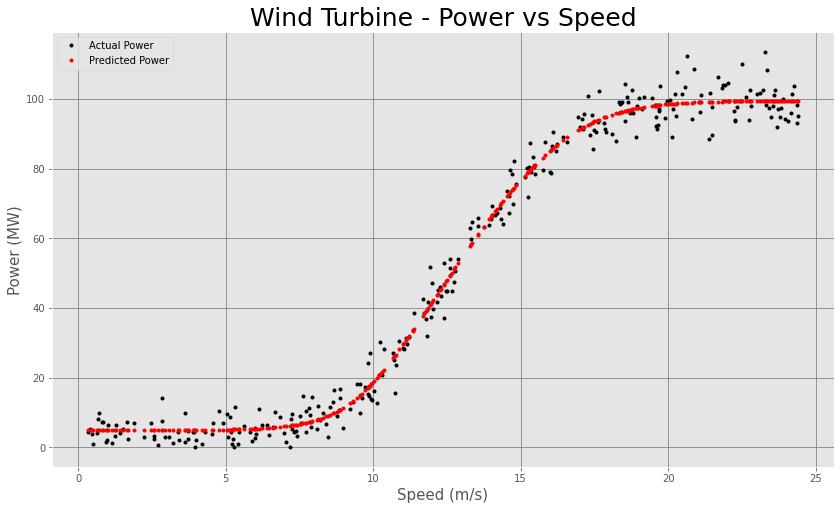

In [80]:
# Now let's see what the train dataset looks like for both the actual data and the predicted values from the model
plt.plot(X_train, y_train, 'k.', label='Actual Power')
plt.plot(X_train, model.predict(X_train), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

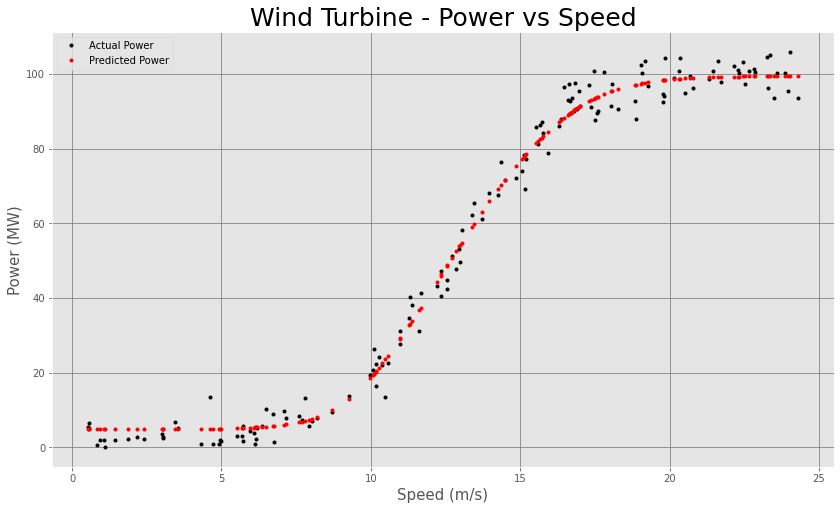

In [81]:
# The ultimate test is how the test dataset fits to its predicted reusults
# Now let's see how the test sample actual and predicted results compare, using the trained model
plt.plot(X_test, y_test, 'k.', label='Actual Power')
plt.plot(X_test, model.predict(X_test), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

In [82]:
# Evaluate the neural network on the test data.
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 998us/step - loss: 14.7500


14.750008583068848

### 5.5 - Test model consisting of: 5 neurons 5000 epochs, batch size=10

![5-neurons](Images/5-neurons.JPG)<br><p style='text-align: right;'>(http://alexlenail.me/NN-SVG/index.html, 2020)</p>

In [32]:
# Build a model using Keras
model = kr.models.Sequential()

# Add a layer with 50 neurons, 1 input (wind speed), using the sigmoid activation function to applied to each neuron, 
# initialise weights and bias with Glorot_uniform Draws samples from a uniform distribution within [-limit, limit], where 
# limit = sqrt(6 / (fan_in + fan_out)) (fan_in is the number of input units in the weight tensor and fan_out is the number 
# of output units).https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform
model.add(kr.layers.Dense(5, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

# Add a layer for the output neuron (Power), using 1 neuron, a linear activation function and, again, glorot_uniform 
# initialisers. Not, we use a linear activation function in this last layer, as we know power outputs are >1, which is the 
# approx the maximum we would obtain if we used a sigmoid activation function.
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

# Compile the model using the above defined neural network, calculating the loss after each epoch using "mean_squared_error"
# method, and applying the Optimizer that implements the Adam algorithm used to affect small changes to weights and bises
# based on the loss calculated after each eopch.https://keras.io/api/optimizers/adam/
model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')

In [33]:
# Fit the training dataset to the above model and run 5000 epochs in batches of 10 at a time.
model.fit(X_train, y_train, epochs=5000, batch_size=10)

Epoch 1/5000
31/31 [==============================] - 0s 699us/step - loss: 4718.9535
Epoch 2/5000
31/31 [==============================] - 0s 998us/step - loss: 4609.8982
Epoch 3/5000
31/31 [==============================] - 0s 965us/step - loss: 4643.2742
Epoch 4/5000
31/31 [==============================] - 0s 963us/step - loss: 4312.2085
Epoch 5/5000
31/31 [==============================] - 0s 863us/step - loss: 3862.7154
Epoch 6/5000
31/31 [==============================] - 0s 964us/step - loss: 4365.5437
Epoch 7/5000
31/31 [==============================] - 0s 964us/step - loss: 4706.0360
Epoch 8/5000
31/31 [==============================] - 0s 963us/step - loss: 3861.8523
Epoch 9/5000
31/31 [==============================] - 0s 997us/step - loss: 4230.2960
Epoch 10/5000
31/31 [==============================] - 0s 964us/step - loss: 3824.1220
Epoch 11/5000
31/31 [==============================] - 0s 998us/step - loss: 3999.4403
Epoch 12/5000
31/31 [==============================]

31/31 [==============================] - 0s 823us/step - loss: 3517.1086
Epoch 96/5000
31/31 [==============================] - 0s 1ms/step - loss: 3325.6985
Epoch 97/5000
31/31 [==============================] - 0s 1ms/step - loss: 3348.7520
Epoch 98/5000
31/31 [==============================] - 0s 929us/step - loss: 3333.3342
Epoch 99/5000
31/31 [==============================] - 0s 1ms/step - loss: 3644.0162
Epoch 100/5000
31/31 [==============================] - 0s 909us/step - loss: 3545.1329
Epoch 101/5000
31/31 [==============================] - 0s 798us/step - loss: 3363.7053
Epoch 102/5000
31/31 [==============================] - 0s 963us/step - loss: 3495.5727
Epoch 103/5000
31/31 [==============================] - 0s 1ms/step - loss: 3117.7845
Epoch 104/5000
31/31 [==============================] - 0s 1ms/step - loss: 2847.7246
Epoch 105/5000
31/31 [==============================] - 0s 964us/step - loss: 3320.6676
Epoch 106/5000
31/31 [==============================] - 0s 95

31/31 [==============================] - 0s 956us/step - loss: 2664.2340
Epoch 189/5000
31/31 [==============================] - 0s 1ms/step - loss: 2755.9616
Epoch 190/5000
31/31 [==============================] - 0s 1ms/step - loss: 2669.4142
Epoch 191/5000
31/31 [==============================] - 0s 892us/step - loss: 2800.0962
Epoch 192/5000
31/31 [==============================] - 0s 1ms/step - loss: 2684.2858
Epoch 193/5000
31/31 [==============================] - 0s 866us/step - loss: 2576.1300
Epoch 194/5000
31/31 [==============================] - 0s 931us/step - loss: 2728.9863
Epoch 195/5000
31/31 [==============================] - 0s 979us/step - loss: 2777.2154
Epoch 196/5000
31/31 [==============================] - 0s 955us/step - loss: 2596.9640
Epoch 197/5000
31/31 [==============================] - 0s 1ms/step - loss: 2674.0957
Epoch 198/5000
31/31 [==============================] - 0s 898us/step - loss: 2857.0310
Epoch 199/5000
31/31 [==============================] -

31/31 [==============================] - 0s 957us/step - loss: 2048.9171
Epoch 282/5000
31/31 [==============================] - 0s 897us/step - loss: 2155.9705
Epoch 283/5000
31/31 [==============================] - 0s 931us/step - loss: 2239.7007
Epoch 284/5000
31/31 [==============================] - 0s 962us/step - loss: 2040.3066
Epoch 285/5000
31/31 [==============================] - 0s 932us/step - loss: 2233.8182
Epoch 286/5000
31/31 [==============================] - 0s 964us/step - loss: 2277.1095
Epoch 287/5000
31/31 [==============================] - 0s 964us/step - loss: 2115.5584
Epoch 288/5000
31/31 [==============================] - 0s 1ms/step - loss: 2116.4338
Epoch 289/5000
31/31 [==============================] - 0s 942us/step - loss: 2241.1645
Epoch 290/5000
31/31 [==============================] - 0s 1ms/step - loss: 2090.7485
Epoch 291/5000
31/31 [==============================] - 0s 932us/step - loss: 2346.4460
Epoch 292/5000
31/31 [=============================

31/31 [==============================] - 0s 902us/step - loss: 1345.6393
Epoch 375/5000
31/31 [==============================] - 0s 997us/step - loss: 1552.0081
Epoch 376/5000
31/31 [==============================] - 0s 1ms/step - loss: 1718.0212
Epoch 377/5000
31/31 [==============================] - 0s 972us/step - loss: 1389.3116
Epoch 378/5000
31/31 [==============================] - 0s 1ms/step - loss: 1526.5048
Epoch 379/5000
31/31 [==============================] - 0s 964us/step - loss: 1651.3077
Epoch 380/5000
31/31 [==============================] - 0s 1ms/step - loss: 1498.1095
Epoch 381/5000
31/31 [==============================] - 0s 1ms/step - loss: 1601.1067
Epoch 382/5000
31/31 [==============================] - 0s 1ms/step - loss: 1527.6557
Epoch 383/5000
31/31 [==============================] - 0s 972us/step - loss: 1542.7167
Epoch 384/5000
31/31 [==============================] - 0s 1ms/step - loss: 1521.3704
Epoch 385/5000
31/31 [==============================] - 0s 

31/31 [==============================] - 0s 861us/step - loss: 1091.5524
Epoch 468/5000
31/31 [==============================] - 0s 1ms/step - loss: 1004.0342
Epoch 469/5000
31/31 [==============================] - 0s 1ms/step - loss: 979.4097
Epoch 470/5000
31/31 [==============================] - 0s 900us/step - loss: 1055.4645
Epoch 471/5000
31/31 [==============================] - 0s 997us/step - loss: 1021.3000
Epoch 472/5000
31/31 [==============================] - ETA: 0s - loss: 899.780 - 0s 986us/step - loss: 993.7730
Epoch 473/5000
31/31 [==============================] - 0s 931us/step - loss: 1086.1154
Epoch 474/5000
31/31 [==============================] - 0s 930us/step - loss: 967.4601
Epoch 475/5000
31/31 [==============================] - 0s 794us/step - loss: 1061.9269
Epoch 476/5000
31/31 [==============================] - 0s 997us/step - loss: 893.4008
Epoch 477/5000
31/31 [==============================] - 0s 1ms/step - loss: 914.3831
Epoch 478/5000
31/31 [==========

31/31 [==============================] - 0s 997us/step - loss: 646.0396
Epoch 562/5000
31/31 [==============================] - 0s 1ms/step - loss: 622.7957
Epoch 563/5000
31/31 [==============================] - 0s 1ms/step - loss: 733.9411
Epoch 564/5000
31/31 [==============================] - 0s 831us/step - loss: 651.6389
Epoch 565/5000
31/31 [==============================] - 0s 784us/step - loss: 640.6178
Epoch 566/5000
31/31 [==============================] - 0s 917us/step - loss: 664.7805
Epoch 567/5000
31/31 [==============================] - 0s 997us/step - loss: 635.9209
Epoch 568/5000
31/31 [==============================] - 0s 864us/step - loss: 663.5456
Epoch 569/5000
31/31 [==============================] - 0s 922us/step - loss: 573.2607
Epoch 570/5000
31/31 [==============================] - 0s 879us/step - loss: 682.7107
Epoch 571/5000
31/31 [==============================] - 0s 964us/step - loss: 716.4005
Epoch 572/5000
31/31 [==============================] - 0s 1ms

31/31 [==============================] - 0s 1ms/step - loss: 356.1976
Epoch 656/5000
31/31 [==============================] - 0s 759us/step - loss: 349.4756
Epoch 657/5000
31/31 [==============================] - 0s 977us/step - loss: 376.1343
Epoch 658/5000
31/31 [==============================] - 0s 876us/step - loss: 351.2237
Epoch 659/5000
31/31 [==============================] - 0s 884us/step - loss: 350.6644
Epoch 660/5000
31/31 [==============================] - 0s 932us/step - loss: 366.0180
Epoch 661/5000
31/31 [==============================] - 0s 998us/step - loss: 380.3842
Epoch 662/5000
31/31 [==============================] - 0s 900us/step - loss: 363.4331
Epoch 663/5000
31/31 [==============================] - 0s 898us/step - loss: 408.8686
Epoch 664/5000
31/31 [==============================] - 0s 778us/step - loss: 382.1286
Epoch 665/5000
31/31 [==============================] - 0s 965us/step - loss: 363.2499
Epoch 666/5000
31/31 [==============================] - 0s 9

Epoch 750/5000
31/31 [==============================] - 0s 1ms/step - loss: 170.2379
Epoch 751/5000
31/31 [==============================] - 0s 898us/step - loss: 182.3276
Epoch 752/5000
31/31 [==============================] - 0s 935us/step - loss: 189.5405
Epoch 753/5000
31/31 [==============================] - 0s 972us/step - loss: 189.1407
Epoch 754/5000
31/31 [==============================] - 0s 1ms/step - loss: 186.9150
Epoch 755/5000
31/31 [==============================] - 0s 1ms/step - loss: 185.6237
Epoch 756/5000
31/31 [==============================] - 0s 888us/step - loss: 169.5635
Epoch 757/5000
31/31 [==============================] - 0s 931us/step - loss: 171.3265
Epoch 758/5000
31/31 [==============================] - 0s 817us/step - loss: 207.4031
Epoch 759/5000
31/31 [==============================] - 0s 986us/step - loss: 175.0045
Epoch 760/5000
31/31 [==============================] - 0s 955us/step - loss: 159.5988
Epoch 761/5000
31/31 [===========================

31/31 [==============================] - 0s 1ms/step - loss: 79.7430
Epoch 845/5000
31/31 [==============================] - 0s 1ms/step - loss: 86.3321
Epoch 846/5000
31/31 [==============================] - 0s 1ms/step - loss: 87.5729
Epoch 847/5000
31/31 [==============================] - 0s 924us/step - loss: 78.7127
Epoch 848/5000
31/31 [==============================] - 0s 931us/step - loss: 77.7303
Epoch 849/5000
31/31 [==============================] - 0s 897us/step - loss: 83.4982
Epoch 850/5000
31/31 [==============================] - 0s 1ms/step - loss: 80.3291
Epoch 851/5000
31/31 [==============================] - 0s 1ms/step - loss: 76.6761
Epoch 852/5000
31/31 [==============================] - 0s 998us/step - loss: 80.0463
Epoch 853/5000
31/31 [==============================] - 0s 931us/step - loss: 84.2398
Epoch 854/5000
31/31 [==============================] - 0s 973us/step - loss: 77.2488
Epoch 855/5000
31/31 [==============================] - 0s 997us/step - loss: 7

31/31 [==============================] - 0s 932us/step - loss: 40.8348
Epoch 940/5000
31/31 [==============================] - 0s 997us/step - loss: 32.8981
Epoch 941/5000
31/31 [==============================] - 0s 1ms/step - loss: 27.0669
Epoch 942/5000
31/31 [==============================] - 0s 799us/step - loss: 36.5846
Epoch 943/5000
31/31 [==============================] - 0s 894us/step - loss: 29.0278
Epoch 944/5000
31/31 [==============================] - 0s 976us/step - loss: 32.9462
Epoch 945/5000
31/31 [==============================] - 0s 1ms/step - loss: 35.2824
Epoch 946/5000
31/31 [==============================] - 0s 870us/step - loss: 31.3216
Epoch 947/5000
31/31 [==============================] - 0s 898us/step - loss: 34.3661
Epoch 948/5000
31/31 [==============================] - 0s 885us/step - loss: 30.7057
Epoch 949/5000
31/31 [==============================] - 0s 977us/step - loss: 31.5906
Epoch 950/5000
31/31 [==============================] - 0s 983us/step - l

31/31 [==============================] - 0s 781us/step - loss: 18.1188
Epoch 1035/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.7942
Epoch 1036/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.1516
Epoch 1037/5000
31/31 [==============================] - 0s 913us/step - loss: 18.3321
Epoch 1038/5000
31/31 [==============================] - 0s 931us/step - loss: 19.2607
Epoch 1039/5000
31/31 [==============================] - 0s 965us/step - loss: 24.1095
Epoch 1040/5000
31/31 [==============================] - 0s 958us/step - loss: 22.1173
Epoch 1041/5000
31/31 [==============================] - 0s 1ms/step - loss: 21.2047
Epoch 1042/5000
31/31 [==============================] - 0s 998us/step - loss: 18.9920
Epoch 1043/5000
31/31 [==============================] - 0s 998us/step - loss: 21.3059
Epoch 1044/5000
31/31 [==============================] - 0s 977us/step - loss: 19.6929
Epoch 1045/5000
31/31 [==============================] - 0s 953us

31/31 [==============================] - 0s 931us/step - loss: 17.9102
Epoch 1129/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.2572
Epoch 1130/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.1986
Epoch 1131/5000
31/31 [==============================] - 0s 898us/step - loss: 20.4194
Epoch 1132/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.4678
Epoch 1133/5000
31/31 [==============================] - 0s 870us/step - loss: 16.6096
Epoch 1134/5000
31/31 [==============================] - 0s 898us/step - loss: 19.0286
Epoch 1135/5000
31/31 [==============================] - 0s 938us/step - loss: 16.4362
Epoch 1136/5000
31/31 [==============================] - 0s 977us/step - loss: 18.5876
Epoch 1137/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.0911
Epoch 1138/5000
31/31 [==============================] - 0s 999us/step - loss: 17.4473
Epoch 1139/5000
31/31 [==============================] - 0s 1ms/ste

Epoch 1223/5000
31/31 [==============================] - 0s 996us/step - loss: 18.7110
Epoch 1224/5000
31/31 [==============================] - 0s 899us/step - loss: 17.2456
Epoch 1225/5000
31/31 [==============================] - 0s 966us/step - loss: 18.4007
Epoch 1226/5000
31/31 [==============================] - 0s 996us/step - loss: 17.5487
Epoch 1227/5000
31/31 [==============================] - 0s 965us/step - loss: 19.7567
Epoch 1228/5000
31/31 [==============================] - 0s 912us/step - loss: 15.9289
Epoch 1229/5000
31/31 [==============================] - 0s 949us/step - loss: 17.8419
Epoch 1230/5000
31/31 [==============================] - 0s 845us/step - loss: 19.7875
Epoch 1231/5000
31/31 [==============================] - 0s 898us/step - loss: 20.2579
Epoch 1232/5000
31/31 [==============================] - 0s 997us/step - loss: 15.5080
Epoch 1233/5000
31/31 [==============================] - 0s 985us/step - loss: 17.8635
Epoch 1234/5000
31/31 [====================

31/31 [==============================] - 0s 825us/step - loss: 17.1468
Epoch 1318/5000
31/31 [==============================] - 0s 996us/step - loss: 17.3635
Epoch 1319/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.3811
Epoch 1320/5000
31/31 [==============================] - 0s 878us/step - loss: 16.4747
Epoch 1321/5000
31/31 [==============================] - 0s 964us/step - loss: 18.8501
Epoch 1322/5000
31/31 [==============================] - 0s 965us/step - loss: 17.2832
Epoch 1323/5000
31/31 [==============================] - 0s 997us/step - loss: 20.7264
Epoch 1324/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.3180
Epoch 1325/5000
31/31 [==============================] - 0s 820us/step - loss: 18.9564
Epoch 1326/5000
31/31 [==============================] - 0s 964us/step - loss: 16.7062
Epoch 1327/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.0647
Epoch 1328/5000
31/31 [==============================] - 0s 997us

31/31 [==============================] - 0s 1ms/step - loss: 19.6586
Epoch 1412/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.9096
Epoch 1413/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.2480
Epoch 1414/5000
31/31 [==============================] - 0s 935us/step - loss: 14.2667
Epoch 1415/5000
31/31 [==============================] - 0s 897us/step - loss: 15.9065
Epoch 1416/5000
31/31 [==============================] - 0s 931us/step - loss: 17.0407
Epoch 1417/5000
31/31 [==============================] - 0s 931us/step - loss: 17.6168
Epoch 1418/5000
31/31 [==============================] - 0s 896us/step - loss: 15.6770
Epoch 1419/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0175
Epoch 1420/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.5152
Epoch 1421/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.3466
Epoch 1422/5000
31/31 [==============================] - 0s 816us/step 

31/31 [==============================] - 0s 1ms/step - loss: 17.3022
Epoch 1506/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.6578
Epoch 1507/5000
31/31 [==============================] - 0s 974us/step - loss: 18.0966
Epoch 1508/5000
31/31 [==============================] - 0s 991us/step - loss: 18.4952
Epoch 1509/5000
31/31 [==============================] - 0s 927us/step - loss: 18.8816
Epoch 1510/5000
31/31 [==============================] - 0s 964us/step - loss: 16.8850
Epoch 1511/5000
31/31 [==============================] - 0s 1ms/step - loss: 21.3285
Epoch 1512/5000
31/31 [==============================] - 0s 968us/step - loss: 15.6114
Epoch 1513/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8771
Epoch 1514/5000
31/31 [==============================] - 0s 986us/step - loss: 20.5668
Epoch 1515/5000
31/31 [==============================] - 0s 998us/step - loss: 15.3340
Epoch 1516/5000
31/31 [==============================] - 0s 887us/s

Epoch 1600/5000
31/31 [==============================] - 0s 997us/step - loss: 17.6184
Epoch 1601/5000
31/31 [==============================] - 0s 902us/step - loss: 19.4283
Epoch 1602/5000
31/31 [==============================] - 0s 964us/step - loss: 18.1515
Epoch 1603/5000
31/31 [==============================] - 0s 922us/step - loss: 17.2532
Epoch 1604/5000
31/31 [==============================] - 0s 899us/step - loss: 17.3666
Epoch 1605/5000
31/31 [==============================] - 0s 964us/step - loss: 16.8327
Epoch 1606/5000
31/31 [==============================] - 0s 998us/step - loss: 17.7952
Epoch 1607/5000
31/31 [==============================] - 0s 898us/step - loss: 17.5824
Epoch 1608/5000
31/31 [==============================] - 0s 964us/step - loss: 18.9164
Epoch 1609/5000
31/31 [==============================] - 0s 965us/step - loss: 19.3535
Epoch 1610/5000
31/31 [==============================] - 0s 914us/step - loss: 15.7555
Epoch 1611/5000
31/31 [====================

31/31 [==============================] - 0s 898us/step - loss: 19.7334
Epoch 1695/5000
31/31 [==============================] - 0s 931us/step - loss: 16.5362
Epoch 1696/5000
31/31 [==============================] - 0s 964us/step - loss: 17.1855
Epoch 1697/5000
31/31 [==============================] - 0s 965us/step - loss: 16.4576
Epoch 1698/5000
31/31 [==============================] - 0s 914us/step - loss: 17.2945
Epoch 1699/5000
31/31 [==============================] - 0s 930us/step - loss: 16.7953
Epoch 1700/5000
31/31 [==============================] - 0s 949us/step - loss: 18.7644
Epoch 1701/5000
31/31 [==============================] - 0s 922us/step - loss: 18.2552
Epoch 1702/5000
31/31 [==============================] - 0s 956us/step - loss: 17.5668
Epoch 1703/5000
31/31 [==============================] - 0s 944us/step - loss: 14.8234
Epoch 1704/5000
31/31 [==============================] - 0s 895us/step - loss: 19.0679
Epoch 1705/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 1ms/step - loss: 16.3615
Epoch 1790/5000
31/31 [==============================] - 0s 913us/step - loss: 16.5521
Epoch 1791/5000
31/31 [==============================] - 0s 940us/step - loss: 17.8009
Epoch 1792/5000
31/31 [==============================] - 0s 878us/step - loss: 17.0756
Epoch 1793/5000
31/31 [==============================] - 0s 981us/step - loss: 18.4852
Epoch 1794/5000
31/31 [==============================] - 0s 933us/step - loss: 17.7619
Epoch 1795/5000
31/31 [==============================] - 0s 920us/step - loss: 20.4877
Epoch 1796/5000
31/31 [==============================] - 0s 904us/step - loss: 15.5742
Epoch 1797/5000
31/31 [==============================] - 0s 963us/step - loss: 18.2539
Epoch 1798/5000
31/31 [==============================] - 0s 972us/step - loss: 16.4018
Epoch 1799/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.0239
Epoch 1800/5000
31/31 [==============================] - 0s 917

31/31 [==============================] - 0s 1ms/step - loss: 15.1147
Epoch 1884/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0081
Epoch 1885/5000
31/31 [==============================] - 0s 816us/step - loss: 18.5271
Epoch 1886/5000
31/31 [==============================] - 0s 963us/step - loss: 14.8594
Epoch 1887/5000
31/31 [==============================] - 0s 973us/step - loss: 19.6472
Epoch 1888/5000
31/31 [==============================] - 0s 894us/step - loss: 19.4112
Epoch 1889/5000
31/31 [==============================] - 0s 801us/step - loss: 16.6663
Epoch 1890/5000
31/31 [==============================] - 0s 791us/step - loss: 18.5217
Epoch 1891/5000
31/31 [==============================] - 0s 979us/step - loss: 17.6393
Epoch 1892/5000
31/31 [==============================] - 0s 877us/step - loss: 15.6202
Epoch 1893/5000
31/31 [==============================] - 0s 852us/step - loss: 18.6687
Epoch 1894/5000
31/31 [==============================] - 0s 847

31/31 [==============================] - 0s 864us/step - loss: 14.6616
Epoch 1979/5000
31/31 [==============================] - 0s 973us/step - loss: 17.6268
Epoch 1980/5000
31/31 [==============================] - 0s 877us/step - loss: 15.7051
Epoch 1981/5000
31/31 [==============================] - 0s 932us/step - loss: 20.0515
Epoch 1982/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.9095
Epoch 1983/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.5640
Epoch 1984/5000
31/31 [==============================] - 0s 930us/step - loss: 17.1694
Epoch 1985/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.6191
Epoch 1986/5000
31/31 [==============================] - 0s 994us/step - loss: 16.5722
Epoch 1987/5000
31/31 [==============================] - 0s 858us/step - loss: 18.8758
Epoch 1988/5000
31/31 [==============================] - 0s 931us/step - loss: 17.1046
Epoch 1989/5000
31/31 [==============================] - 0s 927us

31/31 [==============================] - 0s 996us/step - loss: 18.0687
Epoch 2073/5000
31/31 [==============================] - 0s 930us/step - loss: 17.9607
Epoch 2074/5000
31/31 [==============================] - 0s 997us/step - loss: 18.7450
Epoch 2075/5000
31/31 [==============================] - 0s 911us/step - loss: 16.6598
Epoch 2076/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.2805
Epoch 2077/5000
31/31 [==============================] - 0s 989us/step - loss: 16.6402
Epoch 2078/5000
31/31 [==============================] - 0s 984us/step - loss: 15.6361
Epoch 2079/5000
31/31 [==============================] - 0s 986us/step - loss: 18.1896
Epoch 2080/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.6351
Epoch 2081/5000
31/31 [==============================] - 0s 964us/step - loss: 17.9999
Epoch 2082/5000
31/31 [==============================] - 0s 900us/step - loss: 15.0510
Epoch 2083/5000
31/31 [==============================] - 0s 931

31/31 [==============================] - 0s 931us/step - loss: 17.0321
Epoch 2167/5000
31/31 [==============================] - 0s 999us/step - loss: 16.6780
Epoch 2168/5000
31/31 [==============================] - 0s 892us/step - loss: 16.5937
Epoch 2169/5000
31/31 [==============================] - 0s 946us/step - loss: 19.0921
Epoch 2170/5000
31/31 [==============================] - 0s 950us/step - loss: 16.6450
Epoch 2171/5000
31/31 [==============================] - 0s 790us/step - loss: 18.0475
Epoch 2172/5000
31/31 [==============================] - 0s 931us/step - loss: 17.5746
Epoch 2173/5000
31/31 [==============================] - 0s 964us/step - loss: 15.0593
Epoch 2174/5000
31/31 [==============================] - 0s 978us/step - loss: 18.9603
Epoch 2175/5000
31/31 [==============================] - 0s 994us/step - loss: 19.7106
Epoch 2176/5000
31/31 [==============================] - 0s 944us/step - loss: 16.7195
Epoch 2177/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 898us/step - loss: 17.7889
Epoch 2261/5000
31/31 [==============================] - 0s 966us/step - loss: 17.6783
Epoch 2262/5000
31/31 [==============================] - 0s 931us/step - loss: 17.8100
Epoch 2263/5000
31/31 [==============================] - 0s 934us/step - loss: 16.0112
Epoch 2264/5000
31/31 [==============================] - 0s 963us/step - loss: 17.1936
Epoch 2265/5000
31/31 [==============================] - 0s 878us/step - loss: 19.9141
Epoch 2266/5000
31/31 [==============================] - 0s 931us/step - loss: 19.2293
Epoch 2267/5000
31/31 [==============================] - 0s 964us/step - loss: 18.3446
Epoch 2268/5000
31/31 [==============================] - 0s 997us/step - loss: 16.7352
Epoch 2269/5000
31/31 [==============================] - 0s 964us/step - loss: 17.0461
Epoch 2270/5000
31/31 [==============================] - 0s 931us/step - loss: 20.0315
Epoch 2271/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 864us/step - loss: 18.5530
Epoch 2355/5000
31/31 [==============================] - 0s 790us/step - loss: 16.5533
Epoch 2356/5000
31/31 [==============================] - 0s 950us/step - loss: 16.4634
Epoch 2357/5000
31/31 [==============================] - 0s 994us/step - loss: 16.5564
Epoch 2358/5000
31/31 [==============================] - 0s 908us/step - loss: 17.8010
Epoch 2359/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.1157
Epoch 2360/5000
31/31 [==============================] - 0s 849us/step - loss: 17.9909
Epoch 2361/5000
31/31 [==============================] - 0s 898us/step - loss: 16.7595
Epoch 2362/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.6706
Epoch 2363/5000
31/31 [==============================] - 0s 983us/step - loss: 20.5527
Epoch 2364/5000
31/31 [==============================] - 0s 997us/step - loss: 16.6016
Epoch 2365/5000
31/31 [==============================] - 0s 890

Epoch 2449/5000
31/31 [==============================] - 0s 855us/step - loss: 17.8214
Epoch 2450/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.5974
Epoch 2451/5000
31/31 [==============================] - 0s 932us/step - loss: 14.8372
Epoch 2452/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.5714
Epoch 2453/5000
31/31 [==============================] - 0s 916us/step - loss: 18.4697
Epoch 2454/5000
31/31 [==============================] - 0s 964us/step - loss: 18.2051
Epoch 2455/5000
31/31 [==============================] - 0s 824us/step - loss: 18.1657
Epoch 2456/5000
31/31 [==============================] - 0s 964us/step - loss: 17.8087
Epoch 2457/5000
31/31 [==============================] - 0s 995us/step - loss: 18.5437
Epoch 2458/5000
31/31 [==============================] - 0s 954us/step - loss: 18.2921
Epoch 2459/5000
31/31 [==============================] - 0s 964us/step - loss: 17.4457
Epoch 2460/5000
31/31 [========================

31/31 [==============================] - 0s 1ms/step - loss: 17.9976
Epoch 2544/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.1100
Epoch 2545/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3095
Epoch 2546/5000
31/31 [==============================] - 0s 866us/step - loss: 16.9423
Epoch 2547/5000
31/31 [==============================] - 0s 944us/step - loss: 15.9674
Epoch 2548/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.0030
Epoch 2549/5000
31/31 [==============================] - 0s 898us/step - loss: 15.5061
Epoch 2550/5000
31/31 [==============================] - 0s 967us/step - loss: 17.9527
Epoch 2551/5000
31/31 [==============================] - 0s 963us/step - loss: 17.0534
Epoch 2552/5000
31/31 [==============================] - 0s 814us/step - loss: 17.4748
Epoch 2553/5000
31/31 [==============================] - 0s 929us/step - loss: 18.6847
Epoch 2554/5000
31/31 [==============================] - 0s 981us/s

31/31 [==============================] - 0s 1ms/step - loss: 15.5752
Epoch 2638/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.4963
Epoch 2639/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.2004
Epoch 2640/5000
31/31 [==============================] - 0s 893us/step - loss: 16.3359
Epoch 2641/5000
31/31 [==============================] - 0s 898us/step - loss: 17.7444
Epoch 2642/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.1421
Epoch 2643/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.4249
Epoch 2644/5000
31/31 [==============================] - 0s 965us/step - loss: 17.1074
Epoch 2645/5000
31/31 [==============================] - 0s 931us/step - loss: 18.8298
Epoch 2646/5000
31/31 [==============================] - 0s 964us/step - loss: 20.0894
Epoch 2647/5000
31/31 [==============================] - 0s 955us/step - loss: 18.4184
Epoch 2648/5000
31/31 [==============================] - 0s 997us/ste

Epoch 2732/5000
31/31 [==============================] - 0s 865us/step - loss: 16.5590
Epoch 2733/5000
31/31 [==============================] - 0s 998us/step - loss: 18.0766
Epoch 2734/5000
31/31 [==============================] - 0s 829us/step - loss: 16.3108
Epoch 2735/5000
31/31 [==============================] - 0s 997us/step - loss: 18.4772
Epoch 2736/5000
31/31 [==============================] - 0s 932us/step - loss: 20.7924
Epoch 2737/5000
31/31 [==============================] - 0s 964us/step - loss: 15.8415
Epoch 2738/5000
31/31 [==============================] - 0s 963us/step - loss: 16.5180
Epoch 2739/5000
31/31 [==============================] - 0s 964us/step - loss: 17.5267
Epoch 2740/5000
31/31 [==============================] - 0s 997us/step - loss: 18.4432
Epoch 2741/5000
31/31 [==============================] - 0s 960us/step - loss: 16.8475
Epoch 2742/5000
31/31 [==============================] - 0s 997us/step - loss: 18.4777
Epoch 2743/5000
31/31 [====================

31/31 [==============================] - 0s 969us/step - loss: 18.1110
Epoch 2827/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.2367
Epoch 2828/5000
31/31 [==============================] - 0s 953us/step - loss: 19.0905
Epoch 2829/5000
31/31 [==============================] - 0s 985us/step - loss: 19.7885
Epoch 2830/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.6938
Epoch 2831/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0480
Epoch 2832/5000
31/31 [==============================] - 0s 972us/step - loss: 18.0789
Epoch 2833/5000
31/31 [==============================] - 0s 939us/step - loss: 18.3227
Epoch 2834/5000
31/31 [==============================] - 0s 960us/step - loss: 17.0418
Epoch 2835/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.8382
Epoch 2836/5000
31/31 [==============================] - 0s 953us/step - loss: 17.4900
Epoch 2837/5000
31/31 [==============================] - 0s 990us/s

31/31 [==============================] - 0s 933us/step - loss: 18.9575
Epoch 2922/5000
31/31 [==============================] - 0s 921us/step - loss: 17.3402
Epoch 2923/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.5202
Epoch 2924/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.4958
Epoch 2925/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.1826
Epoch 2926/5000
31/31 [==============================] - 0s 951us/step - loss: 16.9557
Epoch 2927/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.6955
Epoch 2928/5000
31/31 [==============================] - 0s 964us/step - loss: 16.2061
Epoch 2929/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.1267
Epoch 2930/5000
31/31 [==============================] - 0s 955us/step - loss: 17.1921
Epoch 2931/5000
31/31 [==============================] - 0s 998us/step - loss: 16.1015
Epoch 2932/5000
31/31 [==============================] - 0s 923us/ste

31/31 [==============================] - 0s 1ms/step - loss: 19.1598
Epoch 3017/5000
31/31 [==============================] - 0s 964us/step - loss: 21.6819
Epoch 3018/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.7351
Epoch 3019/5000
31/31 [==============================] - 0s 907us/step - loss: 16.2943
Epoch 3020/5000
31/31 [==============================] - 0s 831us/step - loss: 17.7208
Epoch 3021/5000
31/31 [==============================] - 0s 881us/step - loss: 16.4598
Epoch 3022/5000
31/31 [==============================] - 0s 997us/step - loss: 16.9841
Epoch 3023/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.0176
Epoch 3024/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.7819
Epoch 3025/5000
31/31 [==============================] - 0s 982us/step - loss: 16.5929
Epoch 3026/5000
31/31 [==============================] - 0s 912us/step - loss: 18.2789
Epoch 3027/5000
31/31 [==============================] - 0s 965us/s

Epoch 3111/5000
31/31 [==============================] - 0s 895us/step - loss: 20.2462
Epoch 3112/5000
31/31 [==============================] - 0s 964us/step - loss: 18.6667
Epoch 3113/5000
31/31 [==============================] - 0s 931us/step - loss: 17.6958
Epoch 3114/5000
31/31 [==============================] - 0s 997us/step - loss: 19.2403
Epoch 3115/5000
31/31 [==============================] - 0s 898us/step - loss: 16.0355
Epoch 3116/5000
31/31 [==============================] - 0s 931us/step - loss: 17.2143
Epoch 3117/5000
31/31 [==============================] - 0s 821us/step - loss: 17.3994
Epoch 3118/5000
31/31 [==============================] - 0s 964us/step - loss: 18.7390
Epoch 3119/5000
31/31 [==============================] - 0s 998us/step - loss: 15.6008
Epoch 3120/5000
31/31 [==============================] - 0s 997us/step - loss: 17.2010
Epoch 3121/5000
31/31 [==============================] - 0s 876us/step - loss: 16.5237
Epoch 3122/5000
31/31 [====================

31/31 [==============================] - 0s 1ms/step - loss: 16.7804
Epoch 3206/5000
31/31 [==============================] - 0s 931us/step - loss: 17.9592
Epoch 3207/5000
31/31 [==============================] - 0s 877us/step - loss: 18.7250
Epoch 3208/5000
31/31 [==============================] - 0s 898us/step - loss: 19.8663
Epoch 3209/5000
31/31 [==============================] - 0s 965us/step - loss: 20.6822
Epoch 3210/5000
31/31 [==============================] - 0s 898us/step - loss: 16.2406
Epoch 3211/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.3905
Epoch 3212/5000
31/31 [==============================] - 0s 886us/step - loss: 17.1166
Epoch 3213/5000
31/31 [==============================] - 0s 889us/step - loss: 17.8597
Epoch 3214/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.6814
Epoch 3215/5000
31/31 [==============================] - 0s 998us/step - loss: 18.7449
Epoch 3216/5000
31/31 [==============================] - 0s 898us

31/31 [==============================] - 0s 765us/step - loss: 15.4371
Epoch 3301/5000
31/31 [==============================] - 0s 997us/step - loss: 18.9474
Epoch 3302/5000
31/31 [==============================] - 0s 930us/step - loss: 17.0801
Epoch 3303/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.5759
Epoch 3304/5000
31/31 [==============================] - 0s 986us/step - loss: 17.2128
Epoch 3305/5000
31/31 [==============================] - 0s 978us/step - loss: 17.5464
Epoch 3306/5000
31/31 [==============================] - 0s 901us/step - loss: 15.6547
Epoch 3307/5000
31/31 [==============================] - 0s 880us/step - loss: 17.5819
Epoch 3308/5000
31/31 [==============================] - 0s 924us/step - loss: 21.2354
Epoch 3309/5000
31/31 [==============================] - 0s 992us/step - loss: 19.8578
Epoch 3310/5000
31/31 [==============================] - 0s 919us/step - loss: 18.8106
Epoch 3311/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 929us/step - loss: 16.1226
Epoch 3396/5000
31/31 [==============================] - 0s 864us/step - loss: 18.1544
Epoch 3397/5000
31/31 [==============================] - 0s 854us/step - loss: 17.4653
Epoch 3398/5000
31/31 [==============================] - 0s 896us/step - loss: 15.5042
Epoch 3399/5000
31/31 [==============================] - 0s 992us/step - loss: 19.7652
Epoch 3400/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2744
Epoch 3401/5000
31/31 [==============================] - 0s 825us/step - loss: 18.9503
Epoch 3402/5000
31/31 [==============================] - 0s 888us/step - loss: 15.7519
Epoch 3403/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.1163
Epoch 3404/5000
31/31 [==============================] - 0s 987us/step - loss: 15.8987
Epoch 3405/5000
31/31 [==============================] - 0s 962us/step - loss: 19.6590
Epoch 3406/5000
31/31 [==============================] - 0s 905

31/31 [==============================] - 0s 1ms/step - loss: 18.4831
Epoch 3491/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.0177
Epoch 3492/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.4610
Epoch 3493/5000
31/31 [==============================] - 0s 931us/step - loss: 17.2896
Epoch 3494/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.5571
Epoch 3495/5000
31/31 [==============================] - 0s 999us/step - loss: 15.6637
Epoch 3496/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.8722
Epoch 3497/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3544
Epoch 3498/5000
31/31 [==============================] - 0s 999us/step - loss: 16.9732
Epoch 3499/5000
31/31 [==============================] - 0s 998us/step - loss: 18.0069
Epoch 3500/5000
31/31 [==============================] - 0s 1ms/step - loss: 20.8574
Epoch 3501/5000
31/31 [==============================] - 0s 902us/step - 

31/31 [==============================] - 0s 1ms/step - loss: 17.9554
Epoch 3586/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.2208
Epoch 3587/5000
31/31 [==============================] - 0s 997us/step - loss: 19.1737
Epoch 3588/5000
31/31 [==============================] - 0s 997us/step - loss: 17.2181
Epoch 3589/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.0615
Epoch 3590/5000
31/31 [==============================] - 0s 977us/step - loss: 14.6319
Epoch 3591/5000
31/31 [==============================] - 0s 962us/step - loss: 16.2648
Epoch 3592/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.1821
Epoch 3593/5000
31/31 [==============================] - 0s 964us/step - loss: 16.9793
Epoch 3594/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.1255
Epoch 3595/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.6407
Epoch 3596/5000
31/31 [==============================] - 0s 1ms/step - 

31/31 [==============================] - 0s 970us/step - loss: 15.4031
Epoch 3681/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.7981
Epoch 3682/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.1142
Epoch 3683/5000
31/31 [==============================] - 0s 956us/step - loss: 14.6271
Epoch 3684/5000
31/31 [==============================] - 0s 1ms/step - loss: 20.4197
Epoch 3685/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.4761
Epoch 3686/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.7399
Epoch 3687/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1317
Epoch 3688/5000
31/31 [==============================] - 0s 965us/step - loss: 15.0453
Epoch 3689/5000
31/31 [==============================] - 0s 980us/step - loss: 14.8853
Epoch 3690/5000
31/31 [==============================] - 0s 989us/step - loss: 17.3628
Epoch 3691/5000
31/31 [==============================] - 0s 932us/step 

31/31 [==============================] - 0s 864us/step - loss: 15.8521
Epoch 3776/5000
31/31 [==============================] - 0s 833us/step - loss: 14.7222
Epoch 3777/5000
31/31 [==============================] - 0s 894us/step - loss: 17.1239
Epoch 3778/5000
31/31 [==============================] - 0s 962us/step - loss: 17.2685
Epoch 3779/5000
31/31 [==============================] - 0s 964us/step - loss: 17.2404
Epoch 3780/5000
31/31 [==============================] - 0s 888us/step - loss: 18.2742
Epoch 3781/5000
31/31 [==============================] - 0s 931us/step - loss: 18.8645
Epoch 3782/5000
31/31 [==============================] - 0s 998us/step - loss: 18.1252
Epoch 3783/5000
31/31 [==============================] - 0s 864us/step - loss: 18.5304
Epoch 3784/5000
31/31 [==============================] - 0s 989us/step - loss: 17.1427
Epoch 3785/5000
31/31 [==============================] - 0s 992us/step - loss: 15.2752
Epoch 3786/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 964us/step - loss: 14.4800
Epoch 3870/5000
31/31 [==============================] - 0s 997us/step - loss: 16.3297
Epoch 3871/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.6162
Epoch 3872/5000
31/31 [==============================] - 0s 864us/step - loss: 19.2103
Epoch 3873/5000
31/31 [==============================] - 0s 931us/step - loss: 16.7737
Epoch 3874/5000
31/31 [==============================] - 0s 898us/step - loss: 17.9849
Epoch 3875/5000
31/31 [==============================] - 0s 931us/step - loss: 17.1778
Epoch 3876/5000
31/31 [==============================] - 0s 959us/step - loss: 17.2036
Epoch 3877/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.7280
Epoch 3878/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.6580
Epoch 3879/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.3556
Epoch 3880/5000
31/31 [==============================] - 0s 875us/s

31/31 [==============================] - 0s 964us/step - loss: 18.4791
Epoch 3964/5000
31/31 [==============================] - 0s 933us/step - loss: 15.9182
Epoch 3965/5000
31/31 [==============================] - 0s 931us/step - loss: 17.7526
Epoch 3966/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.6390
Epoch 3967/5000
31/31 [==============================] - 0s 834us/step - loss: 16.5471
Epoch 3968/5000
31/31 [==============================] - 0s 931us/step - loss: 17.8483
Epoch 3969/5000
31/31 [==============================] - 0s 899us/step - loss: 18.4764
Epoch 3970/5000
31/31 [==============================] - 0s 997us/step - loss: 18.0908
Epoch 3971/5000
31/31 [==============================] - 0s 997us/step - loss: 19.8935
Epoch 3972/5000
31/31 [==============================] - 0s 964us/step - loss: 18.1854
Epoch 3973/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0953
Epoch 3974/5000
31/31 [==============================] - 0s 951

31/31 [==============================] - 0s 999us/step - loss: 15.5367
Epoch 4058/5000
31/31 [==============================] - 0s 964us/step - loss: 17.7415
Epoch 4059/5000
31/31 [==============================] - 0s 932us/step - loss: 15.2273
Epoch 4060/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.6123
Epoch 4061/5000
31/31 [==============================] - 0s 997us/step - loss: 18.3611
Epoch 4062/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.5056
Epoch 4063/5000
31/31 [==============================] - 0s 997us/step - loss: 15.3150
Epoch 4064/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.6068
Epoch 4065/5000
31/31 [==============================] - 0s 885us/step - loss: 17.9383
Epoch 4066/5000
31/31 [==============================] - 0s 965us/step - loss: 17.5433
Epoch 4067/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.6815
Epoch 4068/5000
31/31 [==============================] - 0s 898us/s

Epoch 4152/5000
31/31 [==============================] - 0s 964us/step - loss: 18.6348
Epoch 4153/5000
31/31 [==============================] - 0s 964us/step - loss: 16.5452
Epoch 4154/5000
31/31 [==============================] - 0s 910us/step - loss: 17.9238
Epoch 4155/5000
31/31 [==============================] - 0s 954us/step - loss: 17.8516
Epoch 4156/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.1705
Epoch 4157/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.4618
Epoch 4158/5000
31/31 [==============================] - 0s 953us/step - loss: 17.6879
Epoch 4159/5000
31/31 [==============================] - 0s 999us/step - loss: 18.3014
Epoch 4160/5000
31/31 [==============================] - 0s 984us/step - loss: 19.3231
Epoch 4161/5000
31/31 [==============================] - 0s 914us/step - loss: 16.9162
Epoch 4162/5000
31/31 [==============================] - 0s 980us/step - loss: 19.0736
Epoch 4163/5000
31/31 [========================

31/31 [==============================] - 0s 898us/step - loss: 17.9289
Epoch 4247/5000
31/31 [==============================] - 0s 961us/step - loss: 17.5334
Epoch 4248/5000
31/31 [==============================] - 0s 964us/step - loss: 17.8704
Epoch 4249/5000
31/31 [==============================] - 0s 931us/step - loss: 17.2857
Epoch 4250/5000
31/31 [==============================] - 0s 887us/step - loss: 18.1131
Epoch 4251/5000
31/31 [==============================] - 0s 961us/step - loss: 19.4933
Epoch 4252/5000
31/31 [==============================] - 0s 959us/step - loss: 21.0121
Epoch 4253/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0342
Epoch 4254/5000
31/31 [==============================] - 0s 890us/step - loss: 19.9481
Epoch 4255/5000
31/31 [==============================] - 0s 834us/step - loss: 15.8878
Epoch 4256/5000
31/31 [==============================] - 0s 901us/step - loss: 17.7131
Epoch 4257/5000
31/31 [==============================] - 0s 1

Epoch 4341/5000
31/31 [==============================] - 0s 976us/step - loss: 17.5801
Epoch 4342/5000
31/31 [==============================] - 0s 936us/step - loss: 17.4958
Epoch 4343/5000
31/31 [==============================] - 0s 998us/step - loss: 19.4706
Epoch 4344/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.4705
Epoch 4345/5000
31/31 [==============================] - 0s 981us/step - loss: 18.7746
Epoch 4346/5000
31/31 [==============================] - 0s 964us/step - loss: 18.2244
Epoch 4347/5000
31/31 [==============================] - 0s 964us/step - loss: 16.6012
Epoch 4348/5000
31/31 [==============================] - 0s 852us/step - loss: 20.1122
Epoch 4349/5000
31/31 [==============================] - 0s 871us/step - loss: 18.4103
Epoch 4350/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0063
Epoch 4351/5000
31/31 [==============================] - 0s 964us/step - loss: 15.3932
Epoch 4352/5000
31/31 [========================

31/31 [==============================] - 0s 1ms/step - loss: 18.5979
Epoch 4437/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.4605
Epoch 4438/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.5875
Epoch 4439/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.8317
Epoch 4440/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.4073
Epoch 4441/5000
31/31 [==============================] - 0s 887us/step - loss: 16.4479
Epoch 4442/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.3590
Epoch 4443/5000
31/31 [==============================] - 0s 815us/step - loss: 14.7772
Epoch 4444/5000
31/31 [==============================] - 0s 932us/step - loss: 16.0347
Epoch 4445/5000
31/31 [==============================] - 0s 996us/step - loss: 19.4973
Epoch 4446/5000
31/31 [==============================] - 0s 897us/step - loss: 14.2998
Epoch 4447/5000
31/31 [==============================] - 0s 961us/step 

31/31 [==============================] - 0s 1ms/step - loss: 15.6618
Epoch 4532/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.6137
Epoch 4533/5000
31/31 [==============================] - 0s 813us/step - loss: 17.4265
Epoch 4534/5000
31/31 [==============================] - 0s 964us/step - loss: 17.3987
Epoch 4535/5000
31/31 [==============================] - 0s 898us/step - loss: 17.2775
Epoch 4536/5000
31/31 [==============================] - 0s 915us/step - loss: 19.0669
Epoch 4537/5000
31/31 [==============================] - ETA: 0s - loss: 5.247 - 0s 919us/step - loss: 15.0022
Epoch 4538/5000
31/31 [==============================] - 0s 997us/step - loss: 15.7629
Epoch 4539/5000
31/31 [==============================] - 0s 949us/step - loss: 17.8743
Epoch 4540/5000
31/31 [==============================] - 0s 931us/step - loss: 16.1473
Epoch 4541/5000
31/31 [==============================] - 0s 866us/step - loss: 18.5379
Epoch 4542/5000
31/31 [================

31/31 [==============================] - 0s 932us/step - loss: 16.1800
Epoch 4627/5000
31/31 [==============================] - 0s 931us/step - loss: 17.3258
Epoch 4628/5000
31/31 [==============================] - 0s 931us/step - loss: 19.3254
Epoch 4629/5000
31/31 [==============================] - 0s 794us/step - loss: 18.0097
Epoch 4630/5000
31/31 [==============================] - 0s 964us/step - loss: 17.3930
Epoch 4631/5000
31/31 [==============================] - 0s 898us/step - loss: 16.4394
Epoch 4632/5000
31/31 [==============================] - 0s 914us/step - loss: 16.6911
Epoch 4633/5000
31/31 [==============================] - 0s 931us/step - loss: 19.6941
Epoch 4634/5000
31/31 [==============================] - 0s 883us/step - loss: 17.7003
Epoch 4635/5000
31/31 [==============================] - 0s 864us/step - loss: 18.8592
Epoch 4636/5000
31/31 [==============================] - 0s 910us/step - loss: 17.8793
Epoch 4637/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 832us/step - loss: 17.9295
Epoch 4721/5000
31/31 [==============================] - 0s 763us/step - loss: 15.4362
Epoch 4722/5000
31/31 [==============================] - 0s 964us/step - loss: 16.9471
Epoch 4723/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.0065
Epoch 4724/5000
31/31 [==============================] - 0s 932us/step - loss: 16.6986
Epoch 4725/5000
31/31 [==============================] - 0s 859us/step - loss: 17.0759
Epoch 4726/5000
31/31 [==============================] - 0s 864us/step - loss: 17.3822
Epoch 4727/5000
31/31 [==============================] - 0s 898us/step - loss: 20.1850
Epoch 4728/5000
31/31 [==============================] - 0s 932us/step - loss: 18.9109
Epoch 4729/5000
31/31 [==============================] - 0s 898us/step - loss: 18.6615
Epoch 4730/5000
31/31 [==============================] - 0s 865us/step - loss: 16.5192
Epoch 4731/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 822us/step - loss: 17.6543
Epoch 4815/5000
31/31 [==============================] - 0s 768us/step - loss: 18.9261
Epoch 4816/5000
31/31 [==============================] - 0s 934us/step - loss: 14.8474
Epoch 4817/5000
31/31 [==============================] - 0s 901us/step - loss: 15.5615
Epoch 4818/5000
31/31 [==============================] - 0s 840us/step - loss: 18.0321
Epoch 4819/5000
31/31 [==============================] - 0s 864us/step - loss: 17.6398
Epoch 4820/5000
31/31 [==============================] - 0s 895us/step - loss: 18.1871
Epoch 4821/5000
31/31 [==============================] - 0s 964us/step - loss: 17.4597
Epoch 4822/5000
31/31 [==============================] - 0s 847us/step - loss: 15.9083
Epoch 4823/5000
31/31 [==============================] - 0s 999us/step - loss: 17.9532
Epoch 4824/5000
31/31 [==============================] - 0s 799us/step - loss: 18.5627
Epoch 4825/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 791us/step - loss: 18.2487
Epoch 4909/5000
31/31 [==============================] - 0s 898us/step - loss: 15.5170
Epoch 4910/5000
31/31 [==============================] - 0s 884us/step - loss: 15.2551
Epoch 4911/5000
31/31 [==============================] - 0s 864us/step - loss: 16.0716
Epoch 4912/5000
31/31 [==============================] - 0s 819us/step - loss: 16.3978
Epoch 4913/5000
31/31 [==============================] - 0s 950us/step - loss: 20.4505
Epoch 4914/5000
31/31 [==============================] - 0s 839us/step - loss: 16.6395
Epoch 4915/5000
31/31 [==============================] - 0s 898us/step - loss: 17.4496
Epoch 4916/5000
31/31 [==============================] - 0s 847us/step - loss: 18.0272
Epoch 4917/5000
31/31 [==============================] - 0s 893us/step - loss: 19.5115
Epoch 4918/5000
31/31 [==============================] - 0s 842us/step - loss: 17.9483
Epoch 4919/5000
31/31 [==============================] - 0s

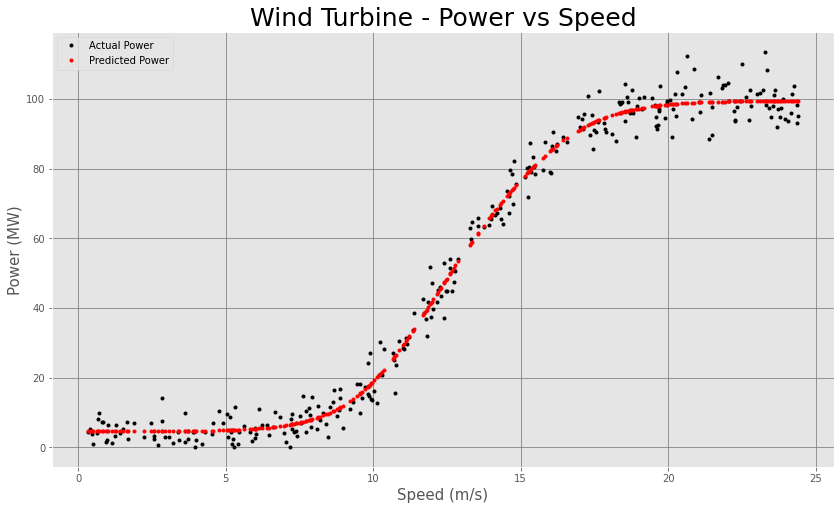

In [34]:
# Now let's see what the train dataset looks like for both the actual data and the predicted values from the model
plt.plot(X_train, y_train, 'k.', label='Actual Power')
plt.plot(X_train, model.predict(X_train), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

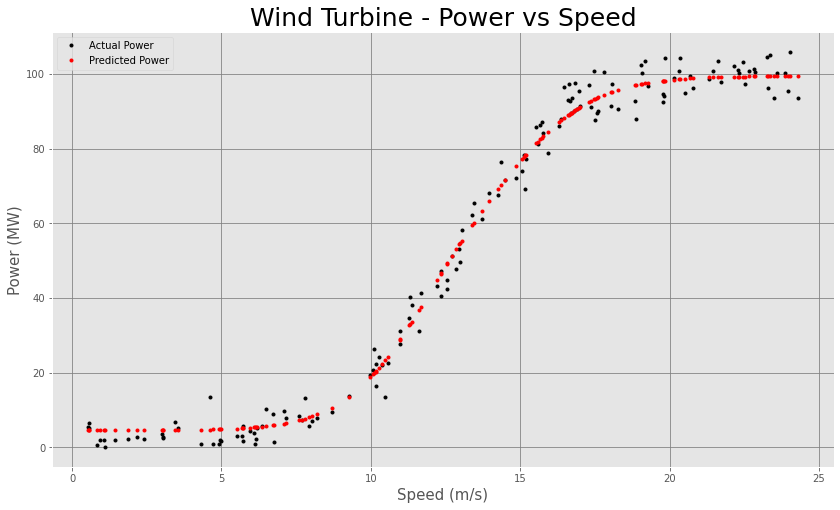

In [35]:
# The ultimate test is how the test dataset fits to its predicted reusults
# Now let's see how the test sample actual and predicted results compare, using the trained model
plt.plot(X_test, y_test, 'k.', label='Actual Power')
plt.plot(X_test, model.predict(X_test), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

In [36]:
# Evaluate the neural network on the test data.
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 946us/step - loss: 14.7332


14.73316764831543